In [1791]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import torch
from torch.nn.functional import conv2d, conv1d, relu_, sigmoid, hardtanh,  relu, unfold, fold
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

localConv=torch.nn.backends.thnn.backend.SpatialConvolutionLocal

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
import seaborn as sns
import pickle as pkl
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from htmresearch.frameworks.cans.utils import *

import warnings
warnings.filterwarnings('ignore')

colors = ["r", "b", "y", "black", "orange"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [746]:
def calculateModuleScales(scales, numModules):
    model = KMeans(n_clusters=numModules)
    clusters = model.fit_predict(scales.reshape(-1, 1))
    moduleScales = []
    for i in range(numModules):
        values = clusters == i
        moduleScales.append(np.median(scales[values]))
    return(clusters, moduleScales)
    

In [1137]:
def calculatePathIntegrationSpeeds(vels, gcn, numModules, simLength=20., dt=None):
    oldDt = gcn.dt
    if dt is not None:
        gcn.dt = dt
    moduleSpeeds = np.zeros((len(vels), numModules))
    for i, vel in enumerate(vels):
        results, histResults, instResults = inhibGCN2.simulate(simLength,
                                           logFreq=int(0.01/gcn.dt),
                                           startFrom=simLength/2.,
                                           vel=vel,
                                           boosting=False)

        activityScales = compute_scales(results[:, :]/np.mean(results[:, :], axis=0,
                                                                 keepdims=True), filler = 1000000)
        modules, moduleScales = calculateModuleScales(activityScales, numModules)
        
        moduleScales = sorted(moduleScales, reverse=True)
        moduleSpeeds[i] = moduleScales
        
    gcn.dt = oldDt
    moduleSpeeds[np.isnan(moduleSpeeds)] = 10000000
    return(moduleSpeeds)
        

<IPython.core.display.Javascript object>


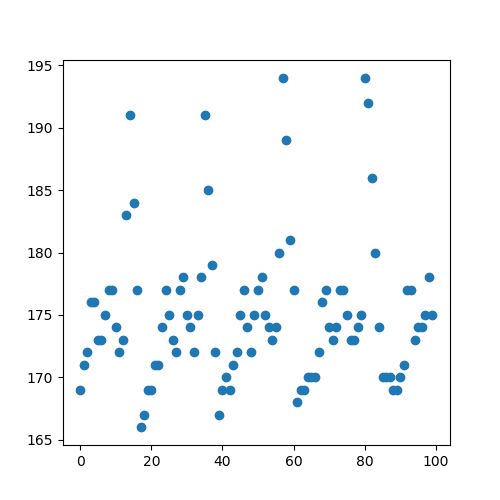

In [665]:
plt.figure()
plt.scatter(np.arange(scales.size), scales)
plt.show()

In [1031]:
def compute_scales(W, filler=-1):
    num_gc = W.shape[1]
    scales = np.zeros(num_gc)
    for i in range(num_gc):
        f   = (W[:,i] > 1.).astype(float)
        df  = f[1:] - f[:-1]
        ind = np.where(df == -1.)[0]
        ind = ind.astype(float)

        if len(ind) > 1:
            scales[i] = np.median(ind[1:] - ind[:-1])

        else:
            scales[i] = filler

    return scales

In [3]:
def localConvolution(activity, weights, kernel):
    outputSize = (activity.shape[-2], activity.shape[-1])
    padding = tuple((k//2 for k in kernel))
    stride = (1, 1)
    unfoldedActivity = unfold(activity, kernel, 1, padding, stride)
    results = (weights*unfoldedActivity).sum(dim = 1)
    return (results.view(1, 1, outputSize[0], outputSize[1]))

In [1250]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.03
def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.0
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return -1*np.exp(-beta * x)


def mexican_hat(x, sigma=1.):
    a = 2./(np.sqrt(3*sigma)*np.power(np.pi, 0.25))
    b = (1. - (x/(.8*sigma))**2 )
    c = np.exp( - x**2/(2.*sigma**2))
    return a*b*c


# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False):
    trajectory = np.zeros((int(length), 2))
    x = np.random.rand()
    y = np.random.rand()
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = (((np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if 0 < (movement[0] + x) < 1 and 0 < (movement[1] + y) < 1 or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                break

    return(trajectory)

In [1862]:
class GCN1D(object):
    def __init__(self,
                 numX=500,
                 inhibitionWindow=15,
                 inhibitionRadius=.5,                 
                 inhibitionStrength=50,
                 excitationWindow=5,
                 excitationCenterBlock=-1,
                 smoothingWindow=1,
                 boostEffect=10,
                 boostDecay=3.,
                 dt=0.005,
                 numPlaces=200,
                 placeAlpha=20,
                 placeMean=0.5,
                 placeMax=1.,
                 activityMeanAlpha=.1,
                 globalTonic=20,
                 tonicGradientX=0.,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactorP=.9,
                 negativeLearnFactorE=.9,
                 negativeLearnFactorI=.9,
                 learnFactorP=.9,
                 learnFactorE=.0,
                 initialWeightFactor=.2,
                 inhibitoryWeightDecay=60,
                 placeWeightDecay=60,
                 excitatoryWeightDecay=60,
                 boostGradientX=1,
                 decayGradientX=1,
                 wideningFactor=0,
                 gradientType="linear",
                 envSize=1,
                 weightFunction=mexican_hat,
                 normalize=False,
                 weightNoise=None,
                ):
        
        self.activity = torch.zeros([1., 1., numX], device=device, dtype=torch.float)
        self.inhibitoryWeights=torch.randn(1, 2*inhibitionWindow+1, numX,
                        device=device, dtype=torch.float)
        
        self.directions = {"s": torch.tensor([1], device=device, dtype=torch.float),
                           "n": torch.tensor([-1], device=device, dtype=torch.float),
                          }
        
        self.excitatoryWeights = dict((k, torch.randn(1, (2*excitationWindow+1),
                                                      numX,
                        device=device, dtype=torch.float)*initialWeightFactor)
                                      for k in self.directions.keys())
        
        self.excitatoryKernel = ((2*excitationWindow+1), (2*excitationWindow+1))

        
        self.numX = numX
        self.numPlaces=numPlaces
        self.placeMean = placeMean
        self.placeMax = placeMax
        
                
        self.smoothingKernel = torch.ones([1, 1, 1+2*smoothingWindow], dtype=torch.float,
                         device=device)
        size = (1+2*smoothingWindow)
        self.smoothingKernel /= size
        self.smoothingWindow = (smoothingWindow, )
        
        
        self.originalWeights = torch.tensor(self.inhibitoryWeights.cpu().numpy(), device=device, dtype=torch.float)
        if weightNoise is not None:
            mask = torch.zeros((1, 2*inhibitionWindow+1, self.numX), device=device, dtype=torch.float)
            mask.uniform_(0, weightNoise)
            self.inhibitoryWeights = mask*self.inhibitoryWeights
            
        self.longHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.activationHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.squaredHistory = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX], device=device, dtype=torch.float)
        
        if isinstance(gradientType, str) and "linear" in gradientType.lower():
            gradient = np.linspace(1, boostGradientX, numX)
            decayGradient = np.linspace(1., decayGradientX, numX)
            tonicGradient = np.linspace(1., tonicGradientX, numX)
        elif isinstance(gradientType, str) and "exponential" in gradientType.lower():
            base = np.power(boostGradientX, 1./numX)
            gradient = np.power(base, np.arange(0, numX))
            decayBase = np.power(decayGradientX, 1./numX)
            decayGradient = np.power(decayBase, np.arange(0, numX))
            tonicBase = np.power(tonicGradientX, 1./numX)
            tonicGradient = np.power(tonicBase, np.arange(0, numX))
        elif isinstance(gradientType, float):
            upper = np.power(boostGradientX, 1./gradientType)
            gradient = np.power(np.linspace(1., upper, numX), gradientType)
            decayUpper = np.power(decayGradientX, 1./gradientType)
            decayGradient = np.power(np.linspace(1., decayUpper, numX), gradientType)
            tonicUpper = np.power(tonicGradientX, 1./gradientType)
            tonicGradient = np.power(np.linspace(1., tonicUpper, numX), gradientType)
            
        self.boostEffect = torch.tensor(
            gradient * boostEffect, device=device, dtype=torch.float)
        self.alpha = torch.tensor(
            decayGradient * boostDecay, device=device, dtype=torch.float)
        self.globalTonic = torch.tensor(
            tonicGradient * globalTonic, device=device, dtype=torch.float)

        for i in range(1+2*inhibitionWindow):
                xDist = np.abs(i - (inhibitionWindow))
                dist = max(xDist - wideningFactor, 0)**2
                if dist <= 0:
                    weight = 0
                else:
                    weight = weightFunction(dist/inhibitionRadius)*inhibitionStrength
                self.inhibitoryWeights[:, i, :] = weight
                
        self.excitationMask = torch.zeros(1, (2*excitationWindow+1), 1,
                        device=device, dtype=torch.float)

        for i in range(1+2*excitationWindow):
            dist = np.abs(i - (excitationWindow))
            if dist > excitationCenterBlock:
                self.excitationMask[:, i, :] = 1.
  
        self.symmetrizer = torch.zeros((1+2*inhibitionWindow,
                                        1+2*inhibitionWindow),
                                       device=device,
                                       dtype=torch.float)

        
        self.symmetrizer[inhibitionWindow, inhibitionWindow] = 1.
        for i in range(1, inhibitionWindow+1):
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow+i, inhibitionWindow-i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow+i] = 1/2.
            self.symmetrizer[inhibitionWindow-i, inhibitionWindow-i] = 1/2.

        self.dt = dt
        self.decay = decayConstant
        self.activityMeanAlpha = activityMeanAlpha
        self.placeAlpha = placeAlpha
        self.inhibitionWindow = inhibitionWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = sigmaLoc
        self.learningRate = learningRate
        self.negativeLearnFactorP = negativeLearnFactorP
        self.negativeLearnFactorE = negativeLearnFactorE
        self.negativeLearnFactorI = negativeLearnFactorI
        self.learnFactorP = learnFactorP
        self.learnFactorE = learnFactorE
        self.inhibitoryWeightDecay = inhibitoryWeightDecay
        self.placeWeightDecay = placeWeightDecay
        self.excitatoryWeightDecay = excitatoryWeightDecay
        self.normalize = normalize
        
        self.inhibitoryKernel = ((2*inhibitionWindow+1), 1)
        self.excitatoryKernel = ((2*excitationWindow+1), 1)
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        self.places = torch.tensor(np.linspace(0, envSize, numPlaces), device=device, dtype=torch.float)
        self.envSize = envSize
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numPlaces),
                                         device=device, dtype=torch.float)
        
        torch.max(self.placeWeights, self.zero, out=self.placeWeights)
        torch.min(self.placeWeights, self.zero + self.placeMax, out=self.placeWeights)
        self.placeWeights *= self.placeMean/torch.mean(self.placeWeights, -1, keepdim=True)

        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        self.placeHistory = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow

    
    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """

        envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
                          np.exp(-1.*self.envelopeFactor *
                          ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
                          for p in np.arange(self.numX) - self.numX/2.]


        return np.asarray(envelopeX)
    
    def step(self, speed=1, vel=None, place=True, boosting=True): 
        if place:
            self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX)
        else:
            self.instantaneous.fill_(0.)
            
        self.instantaneous += localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                 self.inhibitoryWeights,
                                                 self.inhibitoryKernel).view(1, 1, self.numX)
        if vel is not None:
            for k, weights in self.excitatoryWeights.items():
                direction = self.directions[k]*vel
                if direction > self.zero:
                    self.instantaneous += direction*localConvolution(self.activity.view(1, 1, self.numX, 1),
                                                           weights,
                                                           self.excitatoryKernel).view(1, 1, self.numX)

        #self.instantaneous += conv1d(self.activity, self.filter, padding=self.inhibitionWindow)
        self.instantaneous += self.globalTonic
        self.instantaneous *= self.envelope
        if boosting:
            self.instantaneous -= self.activationHistory * self.boostEffect
        self.instantaneous *= speed
        self.instantaneous = hardtanh(self.instantaneous, 0, 1000)
        self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
        #torch.min(self.activity, self.zero + 1., out=self.activity)
        #self.activationHistory += ( - self.activity)*self.dt*self.envelope
        self.activationHistory = self.alpha*self.dt*((self.instantaneous)) +\
                                 (1. - self.alpha*self.dt)*self.activationHistory
        self.squaredHistory = self.activityMeanAlpha*self.dt*((self.instantaneous**2)) +\
                                 (1. - self.activityMeanAlpha*self.dt)*self.squaredHistory
        self.longHistory = self.activityMeanAlpha*self.dt*(self.instantaneous) +\
                                 (1. - self.activityMeanAlpha*self.dt)*self.longHistory
        
        if torch.sum(self.activity**2) > 0 and self.normalize:
            self.activity = self.activity/torch.sqrt(torch.sum(self.activity**2))
        
    def simulate(self,
                 time,
                 logFreq=10,
                 startFrom=0,
                 vel=0,
                 boosting=True,
                 placeActivity=True):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                 dtype=torch.float)
     
        if placeActivity:
            distances = torch.abs(self.places - 0.5)
            torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
            self.placeActivity.fill_(torch.mean(self.placeActivity))
        else:
            self.placeActivity.fill_(0.)
        
        self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        instOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step(place=placeActivity, vel=vel, boosting=boosting)
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX))
                histOutput[s].copy_(self.activationHistory.view(self.numX))
                instOutput[s].copy_(self.instantaneous.view(self.numX))
                s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy(), instOutput.cpu().numpy()
    
    
    def staticLearning(self,
                       time,
                       logFreq=10,
                       startFrom=0,
                       startingActivity=None,
                       startingHistory=None,
                       symmetrize=True):
        
        if startingActivity is None:
            self.activity = torch.tensor(np.random.rand(1, 1, self.numX)*0.1, device=device,
                                                     dtype=torch.float)
        else:
            self.activity = torch.tensor(startingActivity,
                                        device=device,
                                        dtype=torch.float).view((1, 1, self.numX))
        
        if startingHistory is None:  
            self.activationHistory = torch.tensor(np.random.rand(1, 1, self.numX)*0.0, device=device,
                                                 dtype=torch.float)
            
        else:
            self.activationHistory =torch.tensor(startingHistory,
                                                   device=device,
                                                   dtype=torch.float).view((1, 1, self.numX))
        
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
        histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)

        
        alphaboost = 1.
        s = 0
        for t in range(numSteps):
            self.step(place=False)
            
            if t*self.dt >= startFrom:
                self.covarianceInhibitoryUpdate()
                if symmetrize:
                    self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                self.decayInhibitoryWeights(toPattern=False)
                
                if t % logFreq == 0:
                    print("At {}".format(t*self.dt))
                    output[s].copy_(self.activity.view(self.numX))
                    histOutput[s].copy_(self.activationHistory.view(self.numX))
                    s += 1
                
        return output.cpu().numpy(), histOutput.cpu().numpy()
    
    
    def decayPlaceWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*(self.placeWeights**2)/self.placeWeightDecay
       
    def decayExcitatoryWeights(self):
        """
        Only decay excitatory weights
        """
        for k, weights in self.excitatoryWeights.items():
            weights -= self.dt*(torch.exp(torch.exp(weights*2.)))/self.excitatoryWeightDecay


    def decayInhibitoryWeights(self, toPattern=True):
        """
        Only decay inhibitory weights
        """
        if toPattern:
            self.inhibitoryWeights -= self.dt*(self.inhibitoryWeights -
                                               self.originalWeights)/self.inhibitoryWeightDecay
        else:
            self.inhibitoryWeights -= self.dt*self.inhibitoryWeights/self.inhibitoryWeightDecay

    def learn(self,
              runs,
              plotting=True,
              plotInterval=100,
              speed=1,
              offsets=(0,0),
              randomSpeed=False,
              logFreq=None,
              wrap=False,
              learnInhibitory=False,
              symmetrize=True,
              learnExcitatory=False,
              learnPlace=True,
              useExcitatory=False,
              boosting=True,
              preSimulateTime=200.,
              simulateTonicBoost=1.,
              learnStart=0):
        
        if plotting:
                fig, (ax1, ax2, ax3) = plt.subplots(3,1)
                ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.inputBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.historyBuffer = torch.zeros([self.stdpWindow, self.numX],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        self.velBuffer = torch.zeros([self.stdpWindow], device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.learningRate*self.dt
        self.bufferIndex = 0
        
        
        startingPoint = 0
        trajectories = []
        timings = []
        time = 0
        residTime = 0
            
        for run in range(runs):
            if randomSpeed:
                speed = (np.random.random() + 0.5)*speed
            
            if np.random.random() > 0.5:
                direction = 1
            else:
                direction = -1.

            length = self.envSize / speed

            runTimes = np.arange(0, length, self.dt)
            trajectory = np.linspace(0, direction*self.envSize, len(runTimes))
            trajectories.append(trajectory)
            timings.append(runTimes + time)
            time += length
            startingPoint += 1. / runs
            
        
        self.longHistory.fill_(1.)
        if logFreq is not None:
            numSteps = int(time/self.dt)
            numLogs = int(numSteps/logFreq)
            index = 0
            output = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            histOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            instOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)
            placeOutput = torch.zeros([numLogs, self.numX], device=device, dtype=torch.float)

        
        for run, (trajectory, times) in enumerate(zip(trajectories, timings)):
            print("Starting run {}".format(run))
            self.bufferIndex = 0
            velocity = np.diff(trajectory)/self.dt
            trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
            velocity = torch.tensor(velocity, device=device, dtype=torch.float)
            speed = torch.abs(velocity)
            distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)

            self.globalTonic *= simulateTonicBoost
            self.simulate(preSimulateTime, logFreq=100000, startFrom=10000, vel=torch.mean(velocity))
            self.globalTonic /= simulateTonicBoost
            
            for i, t in enumerate(times[:-1]):
                pos = trajectory[i] % self.envSize
                s = speed[i]/torch.mean(speed)
                vel = velocity[i]
                if wrap:
                    distances = torch.min(torch.abs(self.places - pos),
                                          torch.abs(self.envSize - self.places + pos))
                else:
                    distances = torch.abs(self.places - pos)
                    
                torch.exp(-1.*distances/(2*(self.sigmaLoc)), out=self.placeActivity)
                self.placeActivity *= s
                self.placeHistory = -self.placeAlpha*self.dt*self.placeActivity +\
                         (1. - self.placeAlpha*self.dt)*self.placeHistory
                if useExcitatory:
                    self.step(speed=s, vel=vel, boosting=boosting)
                else:
                    self.step(speed=s, boosting=boosting)
                #self.covariancePlaceUpdate()
                if i*self.dt > learnStart:
                    if learnInhibitory:
                        self.covarianceInhibitoryUpdate()
                        if symmetrize:
                            self.inhibitoryWeights = torch.matmul(self.symmetrizer, self.inhibitoryWeights)
                        self.decayInhibitoryWeights(toPattern=True)
                    self.stdpUpdate(i,
                                    vel=vel,
                                    learnPlace=learnPlace,
                                    learnExcitatory=learnExcitatory)
                    if learnPlace:
                        self.decayPlaceWeights()
                        torch.max(self.placeWeights, self.zero, out=self.placeWeights)
                       
                    if learnExcitatory:
                        for k, weights in self.excitatoryWeights.items():
                            weights = torch.max(weights, self.zero)
                            weights = torch.min(weights, self.zero + 20)
                            self.excitatoryWeights[k] = self.excitationMask*weights
                        self.decayExcitatoryWeights()
           
                if logFreq is not None and i % logFreq == 0:
                    output[index].copy_(self.activity.view(self.numX))
                    histOutput[index].copy_(self.activationHistory.view(self.numX))
                    instOutput[index].copy_(self.instantaneous.view(self.numX))
                    input = torch.matmul(self.placeWeights, self.placeActivity).view(self.numX)
                    input += self.globalTonic
                    if boosting:
                        input -= (self.activationHistory * self.boostEffect).view(self.numX)
                    relu_(input)
                    placeOutput[index].copy_(input)
                    index = index + 1
                
                if i % plotInterval == 0:
                    if plotting:
                        ax1.matshow(self.placeWeights.view(self.numX, self.numPlaces).cpu().numpy(), cmap = plt.get_cmap("coolwarm"))
                        ax2.clear()
                        ax2.plot(np.arange(self.numX), self.activity.view((self.numX,)).cpu().numpy())
                        ax3.clear()
                        ax3.scatter(self.places.cpu().numpy(), self.placeActivity.cpu().numpy())
                        ax1.set_title(str(t))
                        fig.canvas.draw()

#             self.stdpUpdate(i+1,
#                             vel=vel,
#                             learnPlace=learnPlace,
#                             learnExcitatory=learnExcitatory,
#                             clearBuffer=True)
            
        return(output, histOutput, instOutput, placeOutput)

        
    def BCMPlaceUpdate(self, presyn, postsyn, history):
        """
        Return: update
        """
        postsyn = postsyn.view(postsyn.numel())
        presyn = presyn.view(presyn.numel())
        history = history.view(history.numel())
        delta = torch.ger(postsyn*(postsyn - history), presyn)/(history[:, None] + 0.001)
        
        return (delta * self.learningRate * self.learnFactorP * self.dt)    
    
        
    def covariancePlaceUpdate(self):
        update = (torch.ger(self.instantaneous - self.longHistory).view(self.numX),
                                                    self.placeActivity).view(self.numX, self.numPlaces)
        self.placeWeights += self.dt*self.learningRate*self.learnFactorP*update
    
    
    def BCMRecurrentUpdate(self, kernel, presyn, postsyn, history):
        padding = tuple((k//2 for k in kernel))
        stride = (1, 1)
        unfoldedActivity = unfold(postsyn*(postsyn - history).view(1, 1, self.numX, 1),
                                  kernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt
        self.inhibitoryWeights += update
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)

    
    def stdpUpdate(self,
                   time,
                   vel=0,
                   clearBuffer=False,
                   learnPlace=True,
                   learnExcitatory=False,
                   adaptive=False,
                   boosting=False):
        if time < self.activityBuffer.shape[0]:
            input = torch.matmul(self.placeWeights, self.placeActivity)
            input += self.globalTonic
            if boosting:
                input += (self.activationHistory * self.boostEffect)
            relu_(input)
            self.inputBuffer[self.bufferIndex].copy_(input.view(self.numX,))
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
            self.historyBuffer[self.bufferIndex].copy_(self.activationHistory.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex] = vel
            
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                if learnPlace:
                    update = torch.ger(self.activity.view(self.numX),
                                        self.placeBuffer[i]* \
                                        self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                        self.learnFactorP
                    update -= torch.ger(self.activityBuffer[i],
                                         self.placeActivity *\
                                         self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                         self.negativeLearnFactorP *\
                                         self.learnFactorP

                    
                    self.placeWeights += update 
                
                    
        
                if learnExcitatory:
                    padding = tuple((k//2 for k in self.excitatoryKernel))
                    stride = (1, 1)
                    unfoldedActivity = unfold((self.instantaneous/self.longHistory + 0.001).view(1, 1, self.numX, 1),
                                              self.excitatoryKernel,
                                              1,
                                              padding,
                                              stride)

                    updateNeg = unfoldedActivity*\
                                self.stdpValues[t]*\
                                self.negativeLearnFactorE*\
                                (self.activityBuffer[i]/self.longHistory + 0.001).view(self.numX)*self.learnFactorE

                    unfoldedActivity = unfold((self.activityBuffer[i]/self.longHistory + 0.001).view(1, 1, self.numX, 1),
                                              self.excitatoryKernel,
                                              1,
                                              padding,
                                              stride)

                    updatePos = unfoldedActivity*\
                                 self.stdpValues[t]*\
                                 (self.instantaneous/self.longHistory + 0.001).view(self.numX)*self.learnFactorE    

                    for k, weights in self.excitatoryWeights.items():
                        dForward = torch.max(self.directions[k]*self.velBuffer[i], self.zero)
                        dBackward = torch.max(self.directions[k]*vel, self.zero)
                        weights += dForward*updatePos - dBackward*updateNeg


            self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
            input = torch.matmul(self.placeWeights, self.placeActivity)
            input += self.globalTonic
            if boosting:
                input -= self.activationHistory * self.boostEffect
            self.inputBuffer[self.bufferIndex].copy_(input.view(self.numX,))
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
            self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex] = vel

        if clearBuffer:
            for j in range(self.stdpWindow):
                for t in range(self.stdpWindow):
                    i = (j + self.bufferIndex - t) % self.stdpWindow
                    if learnPlace:
                        update = torch.ger(self.activityBuffer[j]/(self.longHistory + 0.001),
                                           self.placeBuffer[i]* \
                                                self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                                self.learnFactorP
                        update -= torch.ger(self.activityBuffer[i]/(self.longHistory + 0.001),
                                             self.placeBuffer[j] *\
                                                self.stdpValues[t]).view(self.numX, self.numPlaces) *\
                                              self.negativeLearnFactorP *\
                                                self.learnFactorP

                        self.placeWeights += update 

                self.bufferIndex = (self.bufferIndex + 1) % self.stdpWindow
                self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX,))
                self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
                self.historyBuffer[self.bufferIndex].copy_(self.activitionHistory.view(self.numX,))


    def covarianceInhibitoryUpdate(self):
        padding = tuple((k//2 for k in self.inhibitoryKernel))
        stride = (1, 1)
        unfoldedActivity = unfold(((self.instantaneous - 
                                   self.longHistory)/(self.longHistory + 0.001))\
                                  .view(1, 1, self.numX, 1),
                                  self.inhibitoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.longHistory)/(self.longHistory + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt
        positive = relu(update)
        negative = -relu(-update)
        self.inhibitoryWeights += positive * self.negativeLearnFactorI + negative
        self.inhibitoryWeights = torch.max(self.inhibitoryWeights, self.zero - 10.)
        self.inhibitoryWeights = torch.min(self.inhibitoryWeights, self.zero)
        return(update)
        
        
    def covarianceExcitatoryUpdate(self, vel):
        padding = tuple((k//2 for k in self.excitatoryKernel))
        stride = (1, 1)
        unfoldedActivity = unfold((self.instantaneous - self.activationHistory).view(1, 1, self.numX, 1),
                                  self.excitatoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*((self.instantaneous - self.activationHistory)/(self.longHistory**2 + 0.001)\
                                    ).view(self.numX)
        update = update*self.learningRate*self.dt*self.learnFactorE
        for k, dir in self.directions.items():
            match = torch.max(self.directions[k]*vel, self.zero)
            positive = relu(update*match)
            negative = -relu(-update*match)
            self.excitatoryWeights[k] += self.negativeLearnFactorE*negative + positive
        return(update)
    
    
    def bcmExcitatoryUpdate(self, vel, boosting=False):
        padding = tuple((k//2 for k in self.excitatoryKernel))
        stride = (1, 1)
        input = (self.placeWeights @ self.placeActivity).view(self.numX)
        input += self.globalTonic
        if boosting:
            input -= (self.activationHistory * self.boostEffect).view(self.numX)
        relu_(input)        
        unfoldedActivity = unfold(input.view(1, 1, self.numX, 1),
                                  self.excitatoryKernel,
                                  1,
                                  padding,
                                  stride)
        update = (unfoldedActivity)*\
                 (self.instantaneous*(self.instantaneous + self.activationHistory))/\
                 (-self.activationHistory+ 0.001).view(self.numX)
        update = update*self.learningRate*self.dt*self.learnFactorE
        for k, dir in self.directions.items():
            match = torch.max(self.directions[k]*vel, self.zero)
            positive = relu(update*match)
            negative = -relu(-update*match)
            self.excitatoryWeights[k] += self.negativeLearnFactorE*negative + positive
        return(update)
    
    
    def adaptiveSTDPUpdate(self, vel, boosting=False):
        """
        Call STDPUpdate before this to set up the buffers properly.
        It can be called with all learning rules set to false if necessary.
        """
        for t in range(self.stdpWindow):
            i = (self.bufferIndex - t) % self.stdpWindow

            padding = tuple((k//2 for k in self.excitatoryKernel))
            stride = (1, 1)
            input = (self.placeWeights @ self.placeActivity).view(self.numX)
            input += self.globalTonic
            if boosting:
                input -= (self.activationHistory * self.boostEffect).view(self.numX)
            relu_(input)
            unfoldedActivity = unfold((input/(self.longHistory + 0.001)).\
                                      view(1, 1, self.numX, 1),
                                      self.excitatoryKernel,
                                      1,
                                      padding,
                                      stride)

            updateNeg = unfoldedActivity*\
                        self.stdpValues[t]*\
                        self.negativeLearnFactorE*\
                        (self.activityBuffer[i].view(self.numX) - self.historyBuffer[i])*self.learnFactorE

            unfoldedActivity = unfold((self.inputBuffer[i]/\
                                      (self.longHistory + 0.001)).view(1, 1, self.numX, 1),
                                      self.excitatoryKernel,
                                      1,
                                      padding,
                                      stride)

            updatePos = unfoldedActivity*\
                         self.stdpValues[t]*\
                         (self.instantaneous.view(self.numX) -\
                          self.activationHistory.view(self.numX))*self.learnFactorE    

            for k, weights in self.excitatoryWeights.items():
                dForward = torch.max(self.directions[k]*self.velBuffer[i], self.zero)
                dBackward = torch.max(self.directions[k]*vel, self.zero)
                weights += dForward*updatePos - dBackward*updateNeg
        



In [1863]:
with open(os.getcwd() + "\\perfectmodel.pkl", "rb") as f:
    inhibGCN2 = pkl.load(f)

<IPython.core.display.Javascript object>


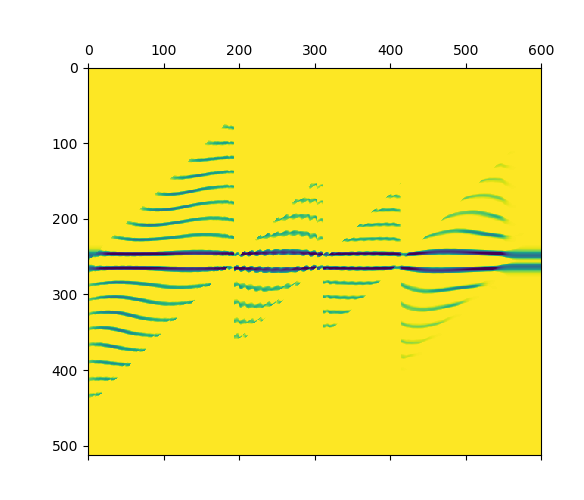

<IPython.core.display.Javascript object>


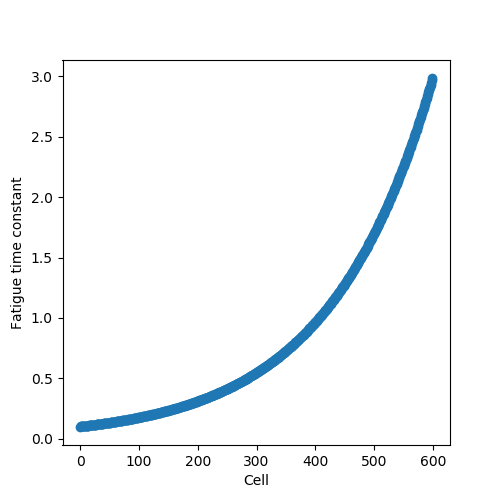

<IPython.core.display.Javascript object>


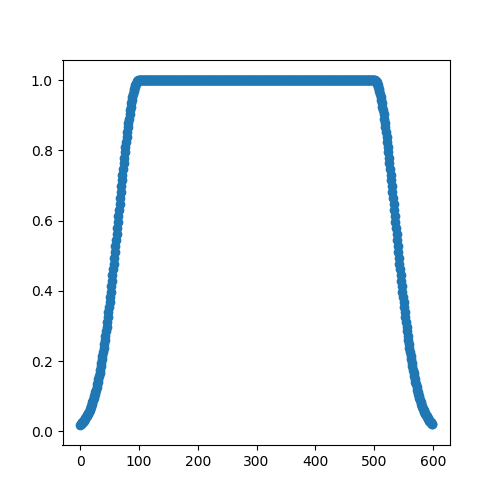

<IPython.core.display.Javascript object>


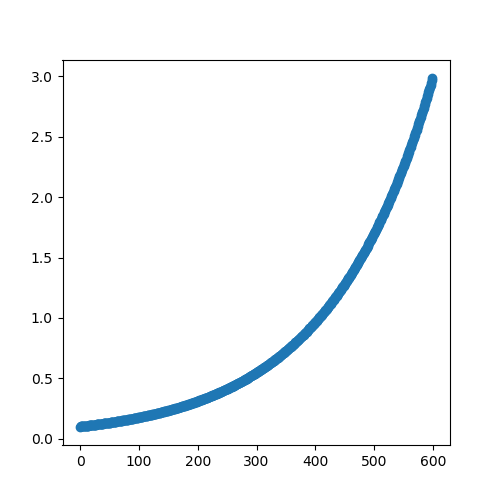

In [1712]:
plt.rcParams['figure.figsize'] = [5, 5]

# hatGCN = GCN1D(500,
#             10,
#             20.,
#             5.,
#             globalTonic=.025,
#             tonicGradientX=0,
#             stdpWindow=1,
#             dt=0.01,
#             boostEffect=.5,
#             boostDecay=1.,
#             placeAlpha=100.,
#             decayConstant=.5,
#             numPlaces=500,
#             learningRate=100.,
#             initialWeightFactor=.02,
#             boostGradientX=19.5,
#             decayGradientX=0.,
#             weightDecay=500,
#             wideningFactor=2,
#             negativeLearnFactorE=.9,
#             envelopeWidth=10,
#             envelopeFactor=2,
#             sigmaLoc=.0005,
#             gradientType="exponential",
#             envSize=5.,
#             weightFunction=mexican_hat,
#             normalize=True,
#             weightNoise=2.)


inhibGCN3 = GCN1D(600,
            256,
            1.,
            500.,
            excitationWindow=256,
            excitationCenterBlock=-1,
            globalTonic=20.,
            tonicGradientX=1.,
            stdpWindow=10,
            dt=0.01,
            boostEffect=10.,
            boostDecay=.1,
            activityMeanAlpha=.1,
            placeAlpha=0.01,
            decayConstant=.03,
            numPlaces=500,
            placeMax=.5,
            placeMean=.25,
            learningRate=.01,
            initialWeightFactor=.02,
            boostGradientX=1.,
            decayGradientX=30.,
            inhibitoryWeightDecay=3000,
            placeWeightDecay=100,
            excitatoryWeightDecay=100000,
            wideningFactor=0.,
            negativeLearnFactorP=.0,
            negativeLearnFactorE=1.5,
            negativeLearnFactorI=5,
            learnFactorP=1000.,
            learnFactorE=10.,
            envelopeWidth=100,
            envelopeFactor=4.,
            sigmaLoc=.01,
            gradientType="exponential",
            envSize=5.,
            weightFunction=w_0,
            normalize=False,
            weightNoise=2.)


#GCN.randomLesions(10, 10, 5)
plt.matshow(inhibGCN2.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.boostEffect.shape[0]), (inhibGCN2.alpha))
plt.xlabel("Cell")
plt.ylabel("Fatigue time constant")
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.envelope.shape[0]), inhibGCN2.envelope)
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.alpha.shape[0]), inhibGCN2.alpha)
plt.show()


<IPython.core.display.Javascript object>


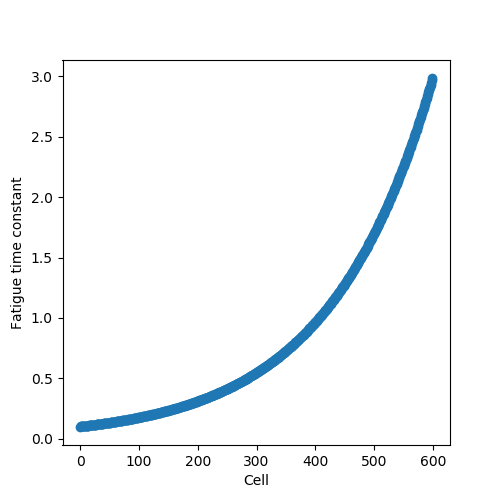

In [1512]:
plt.figure()
plt.scatter(np.arange(inhibGCN2.boostEffect.shape[0]), (inhibGCN2.alpha))
plt.xlabel("Cell")
plt.ylabel("Fatigue time constant")
plt.show()

In [1735]:
plt.rcParams['figure.figsize'] = [5, 5]
results, histResults, instResults = inhibGCN3.simulate(1000,
                                                      logFreq=int(0.01/inhibGCN2.dt),
                                                      startFrom = 0.,
                                                      boosting=True)

At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 8.43
At 8.44
At 8.45
At 8.46
At 8.47
At 8.48
At 8.49
At 8.5
At 8.51
At 8.52
At 8.53
At 8.540000000000001
At 8.55
At 8.56
At 8.57
At 8.58
At 8.59
At 8.6
At 8.61
At 8.620000000000001
At 8.63
At 8.64
At 8.65
At 8.66
At 8.67
At 8.68
At 8.69
At 8.700000000000001
At 8.71
At 8.72
At 8.73
At 8.74
At 8.75
At 8.76
At 8.77
At 8.78
At 8.790000000000001
At 8.8
At 8.81
At 8.82
At 8.83
At 8.84
At 8.85
At 8.86
At 8.870000000000001
At 8.88
At 8.89
At 8.9
At 8.91
At 8.92
At 8.93
At 8.94
At 8.950000000000001
At 8.96
At 8.97
At 8.98
At 8.99
At 9.0
At 9.01
At 9.02
At 9.03
At 9.040000000000001
At 9.05
At 9.06
At 9.07
At 9.08
At 9.09
At 9.1
At 9.11
At 9.120000000000001
At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9

At 16.38
At 16.39
At 16.4
At 16.41
At 16.42
At 16.43
At 16.44
At 16.45
At 16.46
At 16.47
At 16.48
At 16.490000000000002
At 16.5
At 16.51
At 16.52
At 16.53
At 16.54
At 16.55
At 16.56
At 16.57
At 16.580000000000002
At 16.59
At 16.6
At 16.61
At 16.62
At 16.63
At 16.64
At 16.65
At 16.66
At 16.67
At 16.68
At 16.69
At 16.7
At 16.71
At 16.72
At 16.73
At 16.740000000000002
At 16.75
At 16.76
At 16.77
At 16.78
At 16.79
At 16.8
At 16.81
At 16.82
At 16.830000000000002
At 16.84
At 16.85
At 16.86
At 16.87
At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At 17.26
At 17.27
At 17.28
At 17.29
At 17.3
At 17.31
At 17.32
At 17.330000000000002
At 17.34
At 17.35
At 17.36
At

At 24.240000000000002
At 24.25
At 24.26
At 24.27
At 24.28
At 24.29
At 24.3
At 24.310000000000002
At 24.32
At 24.330000000000002
At 24.34
At 24.35
At 24.36
At 24.37
At 24.38
At 24.39
At 24.400000000000002
At 24.41
At 24.42
At 24.43
At 24.44
At 24.45
At 24.46
At 24.47
At 24.48
At 24.490000000000002
At 24.5
At 24.51
At 24.52
At 24.53
At 24.54
At 24.55
At 24.560000000000002
At 24.57
At 24.580000000000002
At 24.59
At 24.6
At 24.61
At 24.62
At 24.63
At 24.64
At 24.650000000000002
At 24.66
At 24.67
At 24.68
At 24.69
At 24.7
At 24.71
At 24.72
At 24.73
At 24.740000000000002
At 24.75
At 24.76
At 24.77
At 24.78
At 24.79
At 24.8
At 24.810000000000002
At 24.82
At 24.830000000000002
At 24.84
At 24.85
At 24.86
At 24.87
At 24.88
At 24.89
At 24.900000000000002
At 24.91
At 24.92
At 24.93
At 24.94
At 24.95
At 24.96
At 24.97
At 24.98
At 24.990000000000002
At 25.0
At 25.01
At 25.02
At 25.03
At 25.04
At 25.05
At 25.060000000000002
At 25.07
At 25.080000000000002
At 25.09
At 25.1
At 25.11
At 25.12
At 25.13
At

At 32.2
At 32.21
At 32.22
At 32.230000000000004
At 32.24
At 32.25
At 32.26
At 32.27
At 32.28
At 32.29
At 32.3
At 32.31
At 32.32
At 32.33
At 32.34
At 32.35
At 32.36
At 32.37
At 32.38
At 32.39
At 32.4
At 32.410000000000004
At 32.42
At 32.43
At 32.44
At 32.45
At 32.46
At 32.47
At 32.480000000000004
At 32.49
At 32.5
At 32.51
At 32.52
At 32.53
At 32.54
At 32.55
At 32.56
At 32.57
At 32.58
At 32.59
At 32.6
At 32.61
At 32.62
At 32.63
At 32.64
At 32.65
At 32.660000000000004
At 32.67
At 32.68
At 32.69
At 32.7
At 32.71
At 32.72
At 32.730000000000004
At 32.74
At 32.75
At 32.76
At 32.77
At 32.78
At 32.79
At 32.8
At 32.81
At 32.82
At 32.83
At 32.84
At 32.85
At 32.86
At 32.87
At 32.88
At 32.89
At 32.9
At 32.910000000000004
At 32.92
At 32.93
At 32.94
At 32.95
At 32.96
At 32.97
At 32.980000000000004
At 32.99
At 33.0
At 33.01
At 33.02
At 33.03
At 33.04
At 33.05
At 33.06
At 33.07
At 33.08
At 33.09
At 33.1
At 33.11
At 33.12
At 33.13
At 33.14
At 33.15
At 33.160000000000004
At 33.17
At 33.18
At 33.19
At 33.

At 40.22
At 40.230000000000004
At 40.24
At 40.25
At 40.26
At 40.27
At 40.28
At 40.29
At 40.300000000000004
At 40.31
At 40.32
At 40.33
At 40.34
At 40.35
At 40.36
At 40.37
At 40.38
At 40.39
At 40.4
At 40.410000000000004
At 40.42
At 40.43
At 40.44
At 40.45
At 40.46
At 40.47
At 40.480000000000004
At 40.49
At 40.5
At 40.51
At 40.52
At 40.53
At 40.54
At 40.550000000000004
At 40.56
At 40.57
At 40.58
At 40.59
At 40.6
At 40.61
At 40.62
At 40.63
At 40.64
At 40.65
At 40.660000000000004
At 40.67
At 40.68
At 40.69
At 40.7
At 40.71
At 40.72
At 40.730000000000004
At 40.74
At 40.75
At 40.76
At 40.77
At 40.78
At 40.79
At 40.800000000000004
At 40.81
At 40.82
At 40.83
At 40.84
At 40.85
At 40.86
At 40.87
At 40.88
At 40.89
At 40.9
At 40.910000000000004
At 40.92
At 40.93
At 40.94
At 40.95
At 40.96
At 40.97
At 40.980000000000004
At 40.99
At 41.0
At 41.01
At 41.02
At 41.03
At 41.04
At 41.050000000000004
At 41.06
At 41.07
At 41.08
At 41.09
At 41.1
At 41.11
At 41.12
At 41.13
At 41.14
At 41.15
At 41.160000000000

At 48.58
At 48.59
At 48.6
At 48.61
At 48.620000000000005
At 48.63
At 48.64
At 48.65
At 48.660000000000004
At 48.67
At 48.68
At 48.69
At 48.7
At 48.71
At 48.72
At 48.730000000000004
At 48.74
At 48.75
At 48.76
At 48.77
At 48.78
At 48.79
At 48.800000000000004
At 48.81
At 48.82
At 48.83
At 48.84
At 48.85
At 48.86
At 48.870000000000005
At 48.88
At 48.89
At 48.9
At 48.910000000000004
At 48.92
At 48.93
At 48.94
At 48.95
At 48.96
At 48.97
At 48.980000000000004
At 48.99
At 49.0
At 49.01
At 49.02
At 49.03
At 49.04
At 49.050000000000004
At 49.06
At 49.07
At 49.08
At 49.09
At 49.1
At 49.11
At 49.120000000000005
At 49.13
At 49.14
At 49.15
At 49.160000000000004
At 49.17
At 49.18
At 49.19
At 49.2
At 49.21
At 49.22
At 49.230000000000004
At 49.24
At 49.25
At 49.26
At 49.27
At 49.28
At 49.29
At 49.300000000000004
At 49.31
At 49.32
At 49.33
At 49.34
At 49.35
At 49.36
At 49.370000000000005
At 49.38
At 49.39
At 49.4
At 49.410000000000004
At 49.42
At 49.43
At 49.44
At 49.45
At 49.46
At 49.47
At 49.480000000

At 56.6
At 56.61
At 56.620000000000005
At 56.63
At 56.64
At 56.65
At 56.660000000000004
At 56.67
At 56.68
At 56.69
At 56.7
At 56.71
At 56.72
At 56.730000000000004
At 56.74
At 56.75
At 56.76
At 56.77
At 56.78
At 56.79
At 56.800000000000004
At 56.81
At 56.82
At 56.83
At 56.84
At 56.85
At 56.86
At 56.870000000000005
At 56.88
At 56.89
At 56.9
At 56.910000000000004
At 56.92
At 56.93
At 56.94
At 56.95
At 56.96
At 56.97
At 56.980000000000004
At 56.99
At 57.0
At 57.01
At 57.02
At 57.03
At 57.04
At 57.050000000000004
At 57.06
At 57.07
At 57.08
At 57.09
At 57.1
At 57.11
At 57.120000000000005
At 57.13
At 57.14
At 57.15
At 57.160000000000004
At 57.17
At 57.18
At 57.19
At 57.2
At 57.21
At 57.22
At 57.230000000000004
At 57.24
At 57.25
At 57.26
At 57.27
At 57.28
At 57.29
At 57.300000000000004
At 57.31
At 57.32
At 57.33
At 57.34
At 57.35
At 57.36
At 57.370000000000005
At 57.38
At 57.39
At 57.4
At 57.410000000000004
At 57.42
At 57.43
At 57.44
At 57.45
At 57.46
At 57.47
At 57.480000000000004
At 57.49
At

At 64.47
At 64.48
At 64.49
At 64.5
At 64.51
At 64.52
At 64.53
At 64.54
At 64.55
At 64.56
At 64.57000000000001
At 64.58
At 64.59
At 64.6
At 64.61
At 64.62
At 64.63
At 64.64
At 64.65
At 64.66
At 64.67
At 64.68
At 64.69
At 64.7
At 64.71000000000001
At 64.72
At 64.73
At 64.74
At 64.75
At 64.76
At 64.77
At 64.78
At 64.79
At 64.8
At 64.81
At 64.82000000000001
At 64.83
At 64.84
At 64.85
At 64.86
At 64.87
At 64.88
At 64.89
At 64.9
At 64.91
At 64.92
At 64.93
At 64.94
At 64.95
At 64.96000000000001
At 64.97
At 64.98
At 64.99
At 65.0
At 65.01
At 65.02
At 65.03
At 65.04
At 65.05
At 65.06
At 65.07000000000001
At 65.08
At 65.09
At 65.1
At 65.11
At 65.12
At 65.13
At 65.14
At 65.15
At 65.16
At 65.17
At 65.18
At 65.19
At 65.2
At 65.21000000000001
At 65.22
At 65.23
At 65.24
At 65.25
At 65.26
At 65.27
At 65.28
At 65.29
At 65.3
At 65.31
At 65.32000000000001
At 65.33
At 65.34
At 65.35
At 65.36
At 65.37
At 65.38
At 65.39
At 65.4
At 65.41
At 65.42
At 65.43
At 65.44
At 65.45
At 65.46000000000001
At 65.47
At 65

At 73.13
At 73.14
At 73.15
At 73.16
At 73.17
At 73.18
At 73.19
At 73.2
At 73.21000000000001
At 73.22
At 73.23
At 73.24
At 73.25
At 73.26
At 73.27
At 73.28
At 73.29
At 73.3
At 73.31
At 73.32000000000001
At 73.33
At 73.34
At 73.35000000000001
At 73.36
At 73.37
At 73.38
At 73.39
At 73.4
At 73.41
At 73.42
At 73.43
At 73.44
At 73.45
At 73.46000000000001
At 73.47
At 73.48
At 73.49
At 73.5
At 73.51
At 73.52
At 73.53
At 73.54
At 73.55
At 73.56
At 73.57000000000001
At 73.58
At 73.59
At 73.60000000000001
At 73.61
At 73.62
At 73.63
At 73.64
At 73.65
At 73.66
At 73.67
At 73.68
At 73.69
At 73.7
At 73.71000000000001
At 73.72
At 73.73
At 73.74
At 73.75
At 73.76
At 73.77
At 73.78
At 73.79
At 73.8
At 73.81
At 73.82000000000001
At 73.83
At 73.84
At 73.85000000000001
At 73.86
At 73.87
At 73.88
At 73.89
At 73.9
At 73.91
At 73.92
At 73.93
At 73.94
At 73.95
At 73.96000000000001
At 73.97
At 73.98
At 73.99
At 74.0
At 74.01
At 74.02
At 74.03
At 74.04
At 74.05
At 74.06
At 74.07000000000001
At 74.08
At 74.09
At 

At 81.14
At 81.15
At 81.16
At 81.17
At 81.18
At 81.19
At 81.2
At 81.21000000000001
At 81.22
At 81.23
At 81.24
At 81.25
At 81.26
At 81.27
At 81.28
At 81.29
At 81.3
At 81.31
At 81.32000000000001
At 81.33
At 81.34
At 81.35000000000001
At 81.36
At 81.37
At 81.38
At 81.39
At 81.4
At 81.41
At 81.42
At 81.43
At 81.44
At 81.45
At 81.46000000000001
At 81.47
At 81.48
At 81.49
At 81.5
At 81.51
At 81.52
At 81.53
At 81.54
At 81.55
At 81.56
At 81.57000000000001
At 81.58
At 81.59
At 81.60000000000001
At 81.61
At 81.62
At 81.63
At 81.64
At 81.65
At 81.66
At 81.67
At 81.68
At 81.69
At 81.7
At 81.71000000000001
At 81.72
At 81.73
At 81.74
At 81.75
At 81.76
At 81.77
At 81.78
At 81.79
At 81.8
At 81.81
At 81.82000000000001
At 81.83
At 81.84
At 81.85000000000001
At 81.86
At 81.87
At 81.88
At 81.89
At 81.9
At 81.91
At 81.92
At 81.93
At 81.94
At 81.95
At 81.96000000000001
At 81.97
At 81.98
At 81.99
At 82.0
At 82.01
At 82.02
At 82.03
At 82.04
At 82.05
At 82.06
At 82.07000000000001
At 82.08
At 82.09
At 82.100000

At 89.15
At 89.16
At 89.17
At 89.18
At 89.19
At 89.2
At 89.21000000000001
At 89.22
At 89.23
At 89.24
At 89.25
At 89.26
At 89.27
At 89.28
At 89.29
At 89.3
At 89.31
At 89.32000000000001
At 89.33
At 89.34
At 89.35000000000001
At 89.36
At 89.37
At 89.38
At 89.39
At 89.4
At 89.41
At 89.42
At 89.43
At 89.44
At 89.45
At 89.46000000000001
At 89.47
At 89.48
At 89.49
At 89.5
At 89.51
At 89.52
At 89.53
At 89.54
At 89.55
At 89.56
At 89.57000000000001
At 89.58
At 89.59
At 89.60000000000001
At 89.61
At 89.62
At 89.63
At 89.64
At 89.65
At 89.66
At 89.67
At 89.68
At 89.69
At 89.7
At 89.71000000000001
At 89.72
At 89.73
At 89.74
At 89.75
At 89.76
At 89.77
At 89.78
At 89.79
At 89.8
At 89.81
At 89.82000000000001
At 89.83
At 89.84
At 89.85000000000001
At 89.86
At 89.87
At 89.88
At 89.89
At 89.9
At 89.91
At 89.92
At 89.93
At 89.94
At 89.95
At 89.96000000000001
At 89.97
At 89.98
At 89.99
At 90.0
At 90.01
At 90.02
At 90.03
At 90.04
At 90.05
At 90.06
At 90.07000000000001
At 90.08
At 90.09
At 90.10000000000001


At 97.21000000000001
At 97.22
At 97.23
At 97.24000000000001
At 97.25
At 97.26
At 97.27
At 97.28
At 97.29
At 97.3
At 97.31
At 97.32000000000001
At 97.33
At 97.34
At 97.35000000000001
At 97.36
At 97.37
At 97.38
At 97.39
At 97.4
At 97.41
At 97.42
At 97.43
At 97.44
At 97.45
At 97.46000000000001
At 97.47
At 97.48
At 97.49000000000001
At 97.5
At 97.51
At 97.52
At 97.53
At 97.54
At 97.55
At 97.56
At 97.57000000000001
At 97.58
At 97.59
At 97.60000000000001
At 97.61
At 97.62
At 97.63
At 97.64
At 97.65
At 97.66
At 97.67
At 97.68
At 97.69
At 97.7
At 97.71000000000001
At 97.72
At 97.73
At 97.74000000000001
At 97.75
At 97.76
At 97.77
At 97.78
At 97.79
At 97.8
At 97.81
At 97.82000000000001
At 97.83
At 97.84
At 97.85000000000001
At 97.86
At 97.87
At 97.88
At 97.89
At 97.9
At 97.91
At 97.92
At 97.93
At 97.94
At 97.95
At 97.96000000000001
At 97.97
At 97.98
At 97.99000000000001
At 98.0
At 98.01
At 98.02
At 98.03
At 98.04
At 98.05
At 98.06
At 98.07000000000001
At 98.08
At 98.09
At 98.10000000000001
At 98

At 104.39
At 104.4
At 104.41
At 104.42
At 104.43
At 104.44
At 104.45
At 104.46000000000001
At 104.47
At 104.48
At 104.49000000000001
At 104.5
At 104.51
At 104.52
At 104.53
At 104.54
At 104.55
At 104.56
At 104.57000000000001
At 104.58
At 104.59
At 104.60000000000001
At 104.61
At 104.62
At 104.63
At 104.64
At 104.65
At 104.66
At 104.67
At 104.68
At 104.69
At 104.7
At 104.71000000000001
At 104.72
At 104.73
At 104.74000000000001
At 104.75
At 104.76
At 104.77
At 104.78
At 104.79
At 104.8
At 104.81
At 104.82000000000001
At 104.83
At 104.84
At 104.85000000000001
At 104.86
At 104.87
At 104.88
At 104.89
At 104.9
At 104.91
At 104.92
At 104.93
At 104.94
At 104.95
At 104.96000000000001
At 104.97
At 104.98
At 104.99000000000001
At 105.0
At 105.01
At 105.02
At 105.03
At 105.04
At 105.05
At 105.06
At 105.07000000000001
At 105.08
At 105.09
At 105.10000000000001
At 105.11
At 105.12
At 105.13
At 105.14
At 105.15
At 105.16
At 105.17
At 105.18
At 105.19
At 105.2
At 105.21000000000001
At 105.22
At 105.23
A

At 111.63
At 111.64
At 111.65
At 111.66
At 111.67
At 111.68
At 111.69
At 111.7
At 111.71000000000001
At 111.72
At 111.73
At 111.74000000000001
At 111.75
At 111.76
At 111.77
At 111.78
At 111.79
At 111.8
At 111.81
At 111.82000000000001
At 111.83
At 111.84
At 111.85000000000001
At 111.86
At 111.87
At 111.88
At 111.89
At 111.9
At 111.91
At 111.92
At 111.93
At 111.94
At 111.95
At 111.96000000000001
At 111.97
At 111.98
At 111.99000000000001
At 112.0
At 112.01
At 112.02
At 112.03
At 112.04
At 112.05
At 112.06
At 112.07000000000001
At 112.08
At 112.09
At 112.10000000000001
At 112.11
At 112.12
At 112.13
At 112.14
At 112.15
At 112.16
At 112.17
At 112.18
At 112.19
At 112.2
At 112.21000000000001
At 112.22
At 112.23
At 112.24000000000001
At 112.25
At 112.26
At 112.27
At 112.28
At 112.29
At 112.3
At 112.31
At 112.32000000000001
At 112.33
At 112.34
At 112.35000000000001
At 112.36
At 112.37
At 112.38
At 112.39
At 112.4
At 112.41
At 112.42
At 112.43
At 112.44
At 112.45
At 112.46000000000001
At 112.47
A

At 118.88
At 118.89
At 118.9
At 118.91
At 118.92
At 118.93
At 118.94
At 118.95
At 118.96000000000001
At 118.97
At 118.98
At 118.99000000000001
At 119.0
At 119.01
At 119.02
At 119.03
At 119.04
At 119.05
At 119.06
At 119.07000000000001
At 119.08
At 119.09
At 119.10000000000001
At 119.11
At 119.12
At 119.13
At 119.14
At 119.15
At 119.16
At 119.17
At 119.18
At 119.19
At 119.2
At 119.21000000000001
At 119.22
At 119.23
At 119.24000000000001
At 119.25
At 119.26
At 119.27
At 119.28
At 119.29
At 119.3
At 119.31
At 119.32000000000001
At 119.33
At 119.34
At 119.35000000000001
At 119.36
At 119.37
At 119.38
At 119.39
At 119.4
At 119.41
At 119.42
At 119.43
At 119.44
At 119.45
At 119.46000000000001
At 119.47
At 119.48
At 119.49000000000001
At 119.5
At 119.51
At 119.52
At 119.53
At 119.54
At 119.55
At 119.56
At 119.57000000000001
At 119.58
At 119.59
At 119.60000000000001
At 119.61
At 119.62
At 119.63
At 119.64
At 119.65
At 119.66
At 119.67
At 119.68
At 119.69
At 119.7
At 119.71000000000001
At 119.72
A

At 126.18
At 126.19
At 126.2
At 126.21000000000001
At 126.22
At 126.23
At 126.24000000000001
At 126.25
At 126.26
At 126.27
At 126.28
At 126.29
At 126.3
At 126.31
At 126.32000000000001
At 126.33
At 126.34
At 126.35000000000001
At 126.36
At 126.37
At 126.38000000000001
At 126.39
At 126.4
At 126.41
At 126.42
At 126.43
At 126.44
At 126.45
At 126.46000000000001
At 126.47
At 126.48
At 126.49000000000001
At 126.5
At 126.51
At 126.52
At 126.53
At 126.54
At 126.55
At 126.56
At 126.57000000000001
At 126.58
At 126.59
At 126.60000000000001
At 126.61
At 126.62
At 126.63000000000001
At 126.64
At 126.65
At 126.66
At 126.67
At 126.68
At 126.69
At 126.7
At 126.71000000000001
At 126.72
At 126.73
At 126.74000000000001
At 126.75
At 126.76
At 126.77
At 126.78
At 126.79
At 126.8
At 126.81
At 126.82000000000001
At 126.83
At 126.84
At 126.85000000000001
At 126.86
At 126.87
At 126.88000000000001
At 126.89
At 126.9
At 126.91
At 126.92
At 126.93
At 126.94
At 126.95
At 126.96000000000001
At 126.97
At 126.98
At 12

At 133.73
At 133.74
At 133.75
At 133.76
At 133.77
At 133.78
At 133.79
At 133.8
At 133.81
At 133.82
At 133.83
At 133.84
At 133.85
At 133.86
At 133.87
At 133.88
At 133.89000000000001
At 133.9
At 133.91
At 133.92000000000002
At 133.93
At 133.94
At 133.95
At 133.96
At 133.97
At 133.98
At 133.99
At 134.0
At 134.01
At 134.02
At 134.03
At 134.04
At 134.05
At 134.06
At 134.07
At 134.08
At 134.09
At 134.1
At 134.11
At 134.12
At 134.13
At 134.14000000000001
At 134.15
At 134.16
At 134.17000000000002
At 134.18
At 134.19
At 134.2
At 134.21
At 134.22
At 134.23
At 134.24
At 134.25
At 134.26
At 134.27
At 134.28
At 134.29
At 134.3
At 134.31
At 134.32
At 134.33
At 134.34
At 134.35
At 134.36
At 134.37
At 134.38
At 134.39000000000001
At 134.4
At 134.41
At 134.42000000000002
At 134.43
At 134.44
At 134.45
At 134.46
At 134.47
At 134.48
At 134.49
At 134.5
At 134.51
At 134.52
At 134.53
At 134.54
At 134.55
At 134.56
At 134.57
At 134.58
At 134.59
At 134.6
At 134.61
At 134.62
At 134.63
At 134.64000000000001
At 13

At 141.58
At 141.59
At 141.6
At 141.61
At 141.62
At 141.63
At 141.64000000000001
At 141.65
At 141.66
At 141.67000000000002
At 141.68
At 141.69
At 141.70000000000002
At 141.71
At 141.72
At 141.73
At 141.74
At 141.75
At 141.76
At 141.77
At 141.78
At 141.79
At 141.8
At 141.81
At 141.82
At 141.83
At 141.84
At 141.85
At 141.86
At 141.87
At 141.88
At 141.89000000000001
At 141.9
At 141.91
At 141.92000000000002
At 141.93
At 141.94
At 141.95000000000002
At 141.96
At 141.97
At 141.98
At 141.99
At 142.0
At 142.01
At 142.02
At 142.03
At 142.04
At 142.05
At 142.06
At 142.07
At 142.08
At 142.09
At 142.1
At 142.11
At 142.12
At 142.13
At 142.14000000000001
At 142.15
At 142.16
At 142.17000000000002
At 142.18
At 142.19
At 142.20000000000002
At 142.21
At 142.22
At 142.23
At 142.24
At 142.25
At 142.26
At 142.27
At 142.28
At 142.29
At 142.3
At 142.31
At 142.32
At 142.33
At 142.34
At 142.35
At 142.36
At 142.37
At 142.38
At 142.39000000000001
At 142.4
At 142.41
At 142.42000000000002
At 142.43
At 142.44
At 14

At 149.06
At 149.07
At 149.08
At 149.09
At 149.1
At 149.11
At 149.12
At 149.13
At 149.14000000000001
At 149.15
At 149.16
At 149.17000000000002
At 149.18
At 149.19
At 149.20000000000002
At 149.21
At 149.22
At 149.23
At 149.24
At 149.25
At 149.26
At 149.27
At 149.28
At 149.29
At 149.3
At 149.31
At 149.32
At 149.33
At 149.34
At 149.35
At 149.36
At 149.37
At 149.38
At 149.39000000000001
At 149.4
At 149.41
At 149.42000000000002
At 149.43
At 149.44
At 149.45000000000002
At 149.46
At 149.47
At 149.48
At 149.49
At 149.5
At 149.51
At 149.52
At 149.53
At 149.54
At 149.55
At 149.56
At 149.57
At 149.58
At 149.59
At 149.6
At 149.61
At 149.62
At 149.63
At 149.64000000000001
At 149.65
At 149.66
At 149.67000000000002
At 149.68
At 149.69
At 149.70000000000002
At 149.71
At 149.72
At 149.73
At 149.74
At 149.75
At 149.76
At 149.77
At 149.78
At 149.79
At 149.8
At 149.81
At 149.82
At 149.83
At 149.84
At 149.85
At 149.86
At 149.87
At 149.88
At 149.89000000000001
At 149.9
At 149.91
At 149.92000000000002
At 14

At 156.72
At 156.73
At 156.74
At 156.75
At 156.76
At 156.77
At 156.78
At 156.79
At 156.8
At 156.81
At 156.82
At 156.83
At 156.84
At 156.85
At 156.86
At 156.87
At 156.88
At 156.89000000000001
At 156.9
At 156.91
At 156.92000000000002
At 156.93
At 156.94
At 156.95000000000002
At 156.96
At 156.97
At 156.98
At 156.99
At 157.0
At 157.01
At 157.02
At 157.03
At 157.04
At 157.05
At 157.06
At 157.07
At 157.08
At 157.09
At 157.1
At 157.11
At 157.12
At 157.13
At 157.14000000000001
At 157.15
At 157.16
At 157.17000000000002
At 157.18
At 157.19
At 157.20000000000002
At 157.21
At 157.22
At 157.23
At 157.24
At 157.25
At 157.26
At 157.27
At 157.28
At 157.29
At 157.3
At 157.31
At 157.32
At 157.33
At 157.34
At 157.35
At 157.36
At 157.37
At 157.38
At 157.39000000000001
At 157.4
At 157.41
At 157.42000000000002
At 157.43
At 157.44
At 157.45000000000002
At 157.46
At 157.47
At 157.48
At 157.49
At 157.5
At 157.51
At 157.52
At 157.53
At 157.54
At 157.55
At 157.56
At 157.57
At 157.58
At 157.59
At 157.6
At 157.61


At 164.45000000000002
At 164.46
At 164.47
At 164.48
At 164.49
At 164.5
At 164.51
At 164.52
At 164.53
At 164.54
At 164.55
At 164.56
At 164.57
At 164.58
At 164.59
At 164.6
At 164.61
At 164.62
At 164.63
At 164.64000000000001
At 164.65
At 164.66
At 164.67000000000002
At 164.68
At 164.69
At 164.70000000000002
At 164.71
At 164.72
At 164.73
At 164.74
At 164.75
At 164.76
At 164.77
At 164.78
At 164.79
At 164.8
At 164.81
At 164.82
At 164.83
At 164.84
At 164.85
At 164.86
At 164.87
At 164.88
At 164.89000000000001
At 164.9
At 164.91
At 164.92000000000002
At 164.93
At 164.94
At 164.95000000000002
At 164.96
At 164.97
At 164.98
At 164.99
At 165.0
At 165.01
At 165.02
At 165.03
At 165.04
At 165.05
At 165.06
At 165.07
At 165.08
At 165.09
At 165.1
At 165.11
At 165.12
At 165.13
At 165.14000000000001
At 165.15
At 165.16
At 165.17000000000002
At 165.18
At 165.19
At 165.20000000000002
At 165.21
At 165.22
At 165.23
At 165.24
At 165.25
At 165.26
At 165.27
At 165.28
At 165.29
At 165.3
At 165.31
At 165.32
At 165.

At 171.73
At 171.74
At 171.75
At 171.76
At 171.77
At 171.78
At 171.79
At 171.8
At 171.81
At 171.82
At 171.83
At 171.84
At 171.85
At 171.86
At 171.87
At 171.88
At 171.89000000000001
At 171.9
At 171.91
At 171.92000000000002
At 171.93
At 171.94
At 171.95000000000002
At 171.96
At 171.97
At 171.98
At 171.99
At 172.0
At 172.01
At 172.02
At 172.03
At 172.04
At 172.05
At 172.06
At 172.07
At 172.08
At 172.09
At 172.1
At 172.11
At 172.12
At 172.13
At 172.14000000000001
At 172.15
At 172.16
At 172.17000000000002
At 172.18
At 172.19
At 172.20000000000002
At 172.21
At 172.22
At 172.23
At 172.24
At 172.25
At 172.26
At 172.27
At 172.28
At 172.29
At 172.3
At 172.31
At 172.32
At 172.33
At 172.34
At 172.35
At 172.36
At 172.37
At 172.38
At 172.39000000000001
At 172.4
At 172.41
At 172.42000000000002
At 172.43
At 172.44
At 172.45000000000002
At 172.46
At 172.47
At 172.48
At 172.49
At 172.5
At 172.51
At 172.52
At 172.53
At 172.54
At 172.55
At 172.56
At 172.57
At 172.58
At 172.59
At 172.6
At 172.61
At 172.62


At 179.6
At 179.61
At 179.62
At 179.63
At 179.64000000000001
At 179.65
At 179.66
At 179.67000000000002
At 179.68
At 179.69
At 179.70000000000002
At 179.71
At 179.72
At 179.73
At 179.74
At 179.75
At 179.76
At 179.77
At 179.78
At 179.79
At 179.8
At 179.81
At 179.82
At 179.83
At 179.84
At 179.85
At 179.86
At 179.87
At 179.88
At 179.89000000000001
At 179.9
At 179.91
At 179.92000000000002
At 179.93
At 179.94
At 179.95000000000002
At 179.96
At 179.97
At 179.98
At 179.99
At 180.0
At 180.01
At 180.02
At 180.03
At 180.04
At 180.05
At 180.06
At 180.07
At 180.08
At 180.09
At 180.1
At 180.11
At 180.12
At 180.13
At 180.14000000000001
At 180.15
At 180.16
At 180.17000000000002
At 180.18
At 180.19
At 180.20000000000002
At 180.21
At 180.22
At 180.23
At 180.24
At 180.25
At 180.26
At 180.27
At 180.28
At 180.29
At 180.3
At 180.31
At 180.32
At 180.33
At 180.34
At 180.35
At 180.36
At 180.37
At 180.38
At 180.39000000000001
At 180.4
At 180.41
At 180.42000000000002
At 180.43
At 180.44
At 180.45000000000002
At 

At 187.06
At 187.07
At 187.08
At 187.09
At 187.1
At 187.11
At 187.12
At 187.13
At 187.14000000000001
At 187.15
At 187.16
At 187.17000000000002
At 187.18
At 187.19
At 187.20000000000002
At 187.21
At 187.22
At 187.23
At 187.24
At 187.25
At 187.26
At 187.27
At 187.28
At 187.29
At 187.3
At 187.31
At 187.32
At 187.33
At 187.34
At 187.35
At 187.36
At 187.37
At 187.38
At 187.39000000000001
At 187.4
At 187.41
At 187.42000000000002
At 187.43
At 187.44
At 187.45000000000002
At 187.46
At 187.47
At 187.48
At 187.49
At 187.5
At 187.51
At 187.52
At 187.53
At 187.54
At 187.55
At 187.56
At 187.57
At 187.58
At 187.59
At 187.6
At 187.61
At 187.62
At 187.63
At 187.64000000000001
At 187.65
At 187.66
At 187.67000000000002
At 187.68
At 187.69
At 187.70000000000002
At 187.71
At 187.72
At 187.73
At 187.74
At 187.75
At 187.76
At 187.77
At 187.78
At 187.79
At 187.8
At 187.81
At 187.82
At 187.83
At 187.84
At 187.85
At 187.86
At 187.87
At 187.88
At 187.89000000000001
At 187.9
At 187.91
At 187.92000000000002
At 18

At 194.9
At 194.91
At 194.92000000000002
At 194.93
At 194.94
At 194.95000000000002
At 194.96
At 194.97
At 194.98000000000002
At 194.99
At 195.0
At 195.01
At 195.02
At 195.03
At 195.04
At 195.05
At 195.06
At 195.07
At 195.08
At 195.09
At 195.1
At 195.11
At 195.12
At 195.13
At 195.14000000000001
At 195.15
At 195.16
At 195.17000000000002
At 195.18
At 195.19
At 195.20000000000002
At 195.21
At 195.22
At 195.23000000000002
At 195.24
At 195.25
At 195.26
At 195.27
At 195.28
At 195.29
At 195.3
At 195.31
At 195.32
At 195.33
At 195.34
At 195.35
At 195.36
At 195.37
At 195.38
At 195.39000000000001
At 195.4
At 195.41
At 195.42000000000002
At 195.43
At 195.44
At 195.45000000000002
At 195.46
At 195.47
At 195.48000000000002
At 195.49
At 195.5
At 195.51
At 195.52
At 195.53
At 195.54
At 195.55
At 195.56
At 195.57
At 195.58
At 195.59
At 195.6
At 195.61
At 195.62
At 195.63
At 195.64000000000001
At 195.65
At 195.66
At 195.67000000000002
At 195.68
At 195.69
At 195.70000000000002
At 195.71
At 195.72
At 195.73

At 201.97
At 201.98000000000002
At 201.99
At 202.0
At 202.01
At 202.02
At 202.03
At 202.04
At 202.05
At 202.06
At 202.07
At 202.08
At 202.09
At 202.1
At 202.11
At 202.12
At 202.13
At 202.14000000000001
At 202.15
At 202.16
At 202.17000000000002
At 202.18
At 202.19
At 202.20000000000002
At 202.21
At 202.22
At 202.23000000000002
At 202.24
At 202.25
At 202.26
At 202.27
At 202.28
At 202.29
At 202.3
At 202.31
At 202.32
At 202.33
At 202.34
At 202.35
At 202.36
At 202.37
At 202.38
At 202.39000000000001
At 202.4
At 202.41
At 202.42000000000002
At 202.43
At 202.44
At 202.45000000000002
At 202.46
At 202.47
At 202.48000000000002
At 202.49
At 202.5
At 202.51
At 202.52
At 202.53
At 202.54
At 202.55
At 202.56
At 202.57
At 202.58
At 202.59
At 202.6
At 202.61
At 202.62
At 202.63
At 202.64000000000001
At 202.65
At 202.66
At 202.67000000000002
At 202.68
At 202.69
At 202.70000000000002
At 202.71
At 202.72
At 202.73000000000002
At 202.74
At 202.75
At 202.76
At 202.77
At 202.78
At 202.79
At 202.8
At 202.81
A

At 209.27
At 209.28
At 209.29
At 209.3
At 209.31
At 209.32
At 209.33
At 209.34
At 209.35
At 209.36
At 209.37
At 209.38
At 209.39000000000001
At 209.4
At 209.41
At 209.42000000000002
At 209.43
At 209.44
At 209.45000000000002
At 209.46
At 209.47
At 209.48000000000002
At 209.49
At 209.5
At 209.51
At 209.52
At 209.53
At 209.54
At 209.55
At 209.56
At 209.57
At 209.58
At 209.59
At 209.6
At 209.61
At 209.62
At 209.63
At 209.64000000000001
At 209.65
At 209.66
At 209.67000000000002
At 209.68
At 209.69
At 209.70000000000002
At 209.71
At 209.72
At 209.73000000000002
At 209.74
At 209.75
At 209.76
At 209.77
At 209.78
At 209.79
At 209.8
At 209.81
At 209.82
At 209.83
At 209.84
At 209.85
At 209.86
At 209.87
At 209.88
At 209.89000000000001
At 209.9
At 209.91
At 209.92000000000002
At 209.93
At 209.94
At 209.95000000000002
At 209.96
At 209.97
At 209.98000000000002
At 209.99
At 210.0
At 210.01
At 210.02
At 210.03
At 210.04
At 210.05
At 210.06
At 210.07
At 210.08
At 210.09
At 210.1
At 210.11
At 210.12
At 2

At 216.5
At 216.51
At 216.52
At 216.53
At 216.54
At 216.55
At 216.56
At 216.57
At 216.58
At 216.59
At 216.6
At 216.61
At 216.62
At 216.63
At 216.64000000000001
At 216.65
At 216.66
At 216.67000000000002
At 216.68
At 216.69
At 216.70000000000002
At 216.71
At 216.72
At 216.73000000000002
At 216.74
At 216.75
At 216.76
At 216.77
At 216.78
At 216.79
At 216.8
At 216.81
At 216.82
At 216.83
At 216.84
At 216.85
At 216.86
At 216.87
At 216.88
At 216.89000000000001
At 216.9
At 216.91
At 216.92000000000002
At 216.93
At 216.94
At 216.95000000000002
At 216.96
At 216.97
At 216.98000000000002
At 216.99
At 217.0
At 217.01
At 217.02
At 217.03
At 217.04
At 217.05
At 217.06
At 217.07
At 217.08
At 217.09
At 217.1
At 217.11
At 217.12
At 217.13
At 217.14000000000001
At 217.15
At 217.16
At 217.17000000000002
At 217.18
At 217.19
At 217.20000000000002
At 217.21
At 217.22
At 217.23000000000002
At 217.24
At 217.25
At 217.26
At 217.27
At 217.28
At 217.29
At 217.3
At 217.31
At 217.32
At 217.33
At 217.34
At 217.35
At 

At 223.68
At 223.69
At 223.70000000000002
At 223.71
At 223.72
At 223.73000000000002
At 223.74
At 223.75
At 223.76
At 223.77
At 223.78
At 223.79
At 223.8
At 223.81
At 223.82
At 223.83
At 223.84
At 223.85
At 223.86
At 223.87
At 223.88
At 223.89000000000001
At 223.9
At 223.91
At 223.92000000000002
At 223.93
At 223.94
At 223.95000000000002
At 223.96
At 223.97
At 223.98000000000002
At 223.99
At 224.0
At 224.01
At 224.02
At 224.03
At 224.04
At 224.05
At 224.06
At 224.07
At 224.08
At 224.09
At 224.1
At 224.11
At 224.12
At 224.13
At 224.14000000000001
At 224.15
At 224.16
At 224.17000000000002
At 224.18
At 224.19
At 224.20000000000002
At 224.21
At 224.22
At 224.23000000000002
At 224.24
At 224.25
At 224.26
At 224.27
At 224.28
At 224.29
At 224.3
At 224.31
At 224.32
At 224.33
At 224.34
At 224.35
At 224.36
At 224.37
At 224.38
At 224.39000000000001
At 224.4
At 224.41
At 224.42000000000002
At 224.43
At 224.44
At 224.45000000000002
At 224.46
At 224.47
At 224.48000000000002
At 224.49
At 224.5
At 224.51

At 230.93
At 230.94
At 230.95000000000002
At 230.96
At 230.97
At 230.98000000000002
At 230.99
At 231.0
At 231.01
At 231.02
At 231.03
At 231.04
At 231.05
At 231.06
At 231.07
At 231.08
At 231.09
At 231.1
At 231.11
At 231.12
At 231.13
At 231.14000000000001
At 231.15
At 231.16
At 231.17000000000002
At 231.18
At 231.19
At 231.20000000000002
At 231.21
At 231.22
At 231.23000000000002
At 231.24
At 231.25
At 231.26
At 231.27
At 231.28
At 231.29
At 231.3
At 231.31
At 231.32
At 231.33
At 231.34
At 231.35
At 231.36
At 231.37
At 231.38
At 231.39000000000001
At 231.4
At 231.41
At 231.42000000000002
At 231.43
At 231.44
At 231.45000000000002
At 231.46
At 231.47
At 231.48000000000002
At 231.49
At 231.5
At 231.51
At 231.52
At 231.53
At 231.54
At 231.55
At 231.56
At 231.57
At 231.58
At 231.59
At 231.6
At 231.61
At 231.62
At 231.63
At 231.64000000000001
At 231.65
At 231.66
At 231.67000000000002
At 231.68
At 231.69
At 231.70000000000002
At 231.71
At 231.72
At 231.73000000000002
At 231.74
At 231.75
At 231.7

At 237.98000000000002
At 237.99
At 238.0
At 238.01
At 238.02
At 238.03
At 238.04
At 238.05
At 238.06
At 238.07
At 238.08
At 238.09
At 238.1
At 238.11
At 238.12
At 238.13
At 238.14000000000001
At 238.15
At 238.16
At 238.17000000000002
At 238.18
At 238.19
At 238.20000000000002
At 238.21
At 238.22
At 238.23000000000002
At 238.24
At 238.25
At 238.26
At 238.27
At 238.28
At 238.29
At 238.3
At 238.31
At 238.32
At 238.33
At 238.34
At 238.35
At 238.36
At 238.37
At 238.38
At 238.39000000000001
At 238.4
At 238.41
At 238.42000000000002
At 238.43
At 238.44
At 238.45000000000002
At 238.46
At 238.47
At 238.48000000000002
At 238.49
At 238.5
At 238.51
At 238.52
At 238.53
At 238.54
At 238.55
At 238.56
At 238.57
At 238.58
At 238.59
At 238.6
At 238.61
At 238.62
At 238.63
At 238.64000000000001
At 238.65
At 238.66
At 238.67000000000002
At 238.68
At 238.69
At 238.70000000000002
At 238.71
At 238.72
At 238.73000000000002
At 238.74
At 238.75
At 238.76
At 238.77
At 238.78
At 238.79
At 238.8
At 238.81
At 238.82
A

At 244.97
At 244.98000000000002
At 244.99
At 245.0
At 245.01
At 245.02
At 245.03
At 245.04
At 245.05
At 245.06
At 245.07
At 245.08
At 245.09
At 245.1
At 245.11
At 245.12
At 245.13
At 245.14000000000001
At 245.15
At 245.16
At 245.17000000000002
At 245.18
At 245.19
At 245.20000000000002
At 245.21
At 245.22
At 245.23000000000002
At 245.24
At 245.25
At 245.26
At 245.27
At 245.28
At 245.29
At 245.3
At 245.31
At 245.32
At 245.33
At 245.34
At 245.35
At 245.36
At 245.37
At 245.38
At 245.39000000000001
At 245.4
At 245.41
At 245.42000000000002
At 245.43
At 245.44
At 245.45000000000002
At 245.46
At 245.47
At 245.48000000000002
At 245.49
At 245.5
At 245.51
At 245.52
At 245.53
At 245.54
At 245.55
At 245.56
At 245.57
At 245.58
At 245.59
At 245.6
At 245.61
At 245.62
At 245.63
At 245.64000000000001
At 245.65
At 245.66
At 245.67000000000002
At 245.68
At 245.69
At 245.70000000000002
At 245.71
At 245.72
At 245.73000000000002
At 245.74
At 245.75
At 245.76
At 245.77
At 245.78
At 245.79
At 245.8
At 245.81
A

At 251.76000000000002
At 251.77
At 251.78
At 251.79
At 251.8
At 251.81
At 251.82
At 251.83
At 251.84
At 251.85
At 251.86
At 251.87
At 251.88
At 251.89000000000001
At 251.9
At 251.91
At 251.92000000000002
At 251.93
At 251.94
At 251.95000000000002
At 251.96
At 251.97
At 251.98000000000002
At 251.99
At 252.0
At 252.01000000000002
At 252.02
At 252.03
At 252.04
At 252.05
At 252.06
At 252.07
At 252.08
At 252.09
At 252.1
At 252.11
At 252.12
At 252.13
At 252.14000000000001
At 252.15
At 252.16
At 252.17000000000002
At 252.18
At 252.19
At 252.20000000000002
At 252.21
At 252.22
At 252.23000000000002
At 252.24
At 252.25
At 252.26000000000002
At 252.27
At 252.28
At 252.29
At 252.3
At 252.31
At 252.32
At 252.33
At 252.34
At 252.35
At 252.36
At 252.37
At 252.38
At 252.39000000000001
At 252.4
At 252.41
At 252.42000000000002
At 252.43
At 252.44
At 252.45000000000002
At 252.46
At 252.47
At 252.48000000000002
At 252.49
At 252.5
At 252.51000000000002
At 252.52
At 252.53
At 252.54
At 252.55
At 252.56
At 25

At 259.27
At 259.28000000000003
At 259.29
At 259.3
At 259.31
At 259.32
At 259.33
At 259.34000000000003
At 259.35
At 259.36
At 259.37
At 259.38
At 259.39
At 259.4
At 259.41
At 259.42
At 259.43
At 259.44
At 259.45
At 259.46
At 259.47
At 259.48
At 259.49
At 259.5
At 259.51
At 259.52
At 259.53000000000003
At 259.54
At 259.55
At 259.56
At 259.57
At 259.58
At 259.59000000000003
At 259.6
At 259.61
At 259.62
At 259.63
At 259.64
At 259.65
At 259.66
At 259.67
At 259.68
At 259.69
At 259.7
At 259.71
At 259.72
At 259.73
At 259.74
At 259.75
At 259.76
At 259.77
At 259.78000000000003
At 259.79
At 259.8
At 259.81
At 259.82
At 259.83
At 259.84000000000003
At 259.85
At 259.86
At 259.87
At 259.88
At 259.89
At 259.9
At 259.91
At 259.92
At 259.93
At 259.94
At 259.95
At 259.96
At 259.97
At 259.98
At 259.99
At 260.0
At 260.01
At 260.02
At 260.03000000000003
At 260.04
At 260.05
At 260.06
At 260.07
At 260.08
At 260.09000000000003
At 260.1
At 260.11
At 260.12
At 260.13
At 260.14
At 260.15
At 260.16
At 260.17
At 

At 267.29
At 267.3
At 267.31
At 267.32
At 267.33
At 267.34000000000003
At 267.35
At 267.36
At 267.37
At 267.38
At 267.39
At 267.4
At 267.41
At 267.42
At 267.43
At 267.44
At 267.45
At 267.46
At 267.47
At 267.48
At 267.49
At 267.5
At 267.51
At 267.52
At 267.53000000000003
At 267.54
At 267.55
At 267.56
At 267.57
At 267.58
At 267.59000000000003
At 267.6
At 267.61
At 267.62
At 267.63
At 267.64
At 267.65
At 267.66
At 267.67
At 267.68
At 267.69
At 267.7
At 267.71
At 267.72
At 267.73
At 267.74
At 267.75
At 267.76
At 267.77
At 267.78000000000003
At 267.79
At 267.8
At 267.81
At 267.82
At 267.83
At 267.84000000000003
At 267.85
At 267.86
At 267.87
At 267.88
At 267.89
At 267.9
At 267.91
At 267.92
At 267.93
At 267.94
At 267.95
At 267.96
At 267.97
At 267.98
At 267.99
At 268.0
At 268.01
At 268.02
At 268.03000000000003
At 268.04
At 268.05
At 268.06
At 268.07
At 268.08
At 268.09000000000003
At 268.1
At 268.11
At 268.12
At 268.13
At 268.14
At 268.15
At 268.16
At 268.17
At 268.18
At 268.19
At 268.2
At 268

At 274.87
At 274.88
At 274.89
At 274.90000000000003
At 274.91
At 274.92
At 274.93
At 274.94
At 274.95
At 274.96
At 274.97
At 274.98
At 274.99
At 275.0
At 275.01
At 275.02
At 275.03000000000003
At 275.04
At 275.05
At 275.06
At 275.07
At 275.08
At 275.09000000000003
At 275.1
At 275.11
At 275.12
At 275.13
At 275.14
At 275.15000000000003
At 275.16
At 275.17
At 275.18
At 275.19
At 275.2
At 275.21
At 275.22
At 275.23
At 275.24
At 275.25
At 275.26
At 275.27
At 275.28000000000003
At 275.29
At 275.3
At 275.31
At 275.32
At 275.33
At 275.34000000000003
At 275.35
At 275.36
At 275.37
At 275.38
At 275.39
At 275.40000000000003
At 275.41
At 275.42
At 275.43
At 275.44
At 275.45
At 275.46
At 275.47
At 275.48
At 275.49
At 275.5
At 275.51
At 275.52
At 275.53000000000003
At 275.54
At 275.55
At 275.56
At 275.57
At 275.58
At 275.59000000000003
At 275.6
At 275.61
At 275.62
At 275.63
At 275.64
At 275.65000000000003
At 275.66
At 275.67
At 275.68
At 275.69
At 275.7
At 275.71
At 275.72
At 275.73
At 275.74
At 275.

At 282.59000000000003
At 282.6
At 282.61
At 282.62
At 282.63
At 282.64
At 282.65000000000003
At 282.66
At 282.67
At 282.68
At 282.69
At 282.7
At 282.71
At 282.72
At 282.73
At 282.74
At 282.75
At 282.76
At 282.77
At 282.78000000000003
At 282.79
At 282.8
At 282.81
At 282.82
At 282.83
At 282.84000000000003
At 282.85
At 282.86
At 282.87
At 282.88
At 282.89
At 282.90000000000003
At 282.91
At 282.92
At 282.93
At 282.94
At 282.95
At 282.96
At 282.97
At 282.98
At 282.99
At 283.0
At 283.01
At 283.02
At 283.03000000000003
At 283.04
At 283.05
At 283.06
At 283.07
At 283.08
At 283.09000000000003
At 283.1
At 283.11
At 283.12
At 283.13
At 283.14
At 283.15000000000003
At 283.16
At 283.17
At 283.18
At 283.19
At 283.2
At 283.21
At 283.22
At 283.23
At 283.24
At 283.25
At 283.26
At 283.27
At 283.28000000000003
At 283.29
At 283.3
At 283.31
At 283.32
At 283.33
At 283.34000000000003
At 283.35
At 283.36
At 283.37
At 283.38
At 283.39
At 283.40000000000003
At 283.41
At 283.42
At 283.43
At 283.44
At 283.45
At 28

At 290.40000000000003
At 290.41
At 290.42
At 290.43
At 290.44
At 290.45
At 290.46
At 290.47
At 290.48
At 290.49
At 290.5
At 290.51
At 290.52
At 290.53000000000003
At 290.54
At 290.55
At 290.56
At 290.57
At 290.58
At 290.59000000000003
At 290.6
At 290.61
At 290.62
At 290.63
At 290.64
At 290.65000000000003
At 290.66
At 290.67
At 290.68
At 290.69
At 290.7
At 290.71
At 290.72
At 290.73
At 290.74
At 290.75
At 290.76
At 290.77
At 290.78000000000003
At 290.79
At 290.8
At 290.81
At 290.82
At 290.83
At 290.84000000000003
At 290.85
At 290.86
At 290.87
At 290.88
At 290.89
At 290.90000000000003
At 290.91
At 290.92
At 290.93
At 290.94
At 290.95
At 290.96
At 290.97
At 290.98
At 290.99
At 291.0
At 291.01
At 291.02
At 291.03000000000003
At 291.04
At 291.05
At 291.06
At 291.07
At 291.08
At 291.09000000000003
At 291.1
At 291.11
At 291.12
At 291.13
At 291.14
At 291.15000000000003
At 291.16
At 291.17
At 291.18
At 291.19
At 291.2
At 291.21
At 291.22
At 291.23
At 291.24
At 291.25
At 291.26
At 291.27
At 291.

At 297.89
At 297.90000000000003
At 297.91
At 297.92
At 297.93
At 297.94
At 297.95
At 297.96
At 297.97
At 297.98
At 297.99
At 298.0
At 298.01
At 298.02
At 298.03000000000003
At 298.04
At 298.05
At 298.06
At 298.07
At 298.08
At 298.09000000000003
At 298.1
At 298.11
At 298.12
At 298.13
At 298.14
At 298.15000000000003
At 298.16
At 298.17
At 298.18
At 298.19
At 298.2
At 298.21
At 298.22
At 298.23
At 298.24
At 298.25
At 298.26
At 298.27
At 298.28000000000003
At 298.29
At 298.3
At 298.31
At 298.32
At 298.33
At 298.34000000000003
At 298.35
At 298.36
At 298.37
At 298.38
At 298.39
At 298.40000000000003
At 298.41
At 298.42
At 298.43
At 298.44
At 298.45
At 298.46
At 298.47
At 298.48
At 298.49
At 298.5
At 298.51
At 298.52
At 298.53000000000003
At 298.54
At 298.55
At 298.56
At 298.57
At 298.58
At 298.59000000000003
At 298.6
At 298.61
At 298.62
At 298.63
At 298.64
At 298.65000000000003
At 298.66
At 298.67
At 298.68
At 298.69
At 298.7
At 298.71
At 298.72
At 298.73
At 298.74
At 298.75
At 298.76
At 298.

At 305.38
At 305.39
At 305.40000000000003
At 305.41
At 305.42
At 305.43
At 305.44
At 305.45
At 305.46
At 305.47
At 305.48
At 305.49
At 305.5
At 305.51
At 305.52
At 305.53000000000003
At 305.54
At 305.55
At 305.56
At 305.57
At 305.58
At 305.59000000000003
At 305.6
At 305.61
At 305.62
At 305.63
At 305.64
At 305.65000000000003
At 305.66
At 305.67
At 305.68
At 305.69
At 305.7
At 305.71
At 305.72
At 305.73
At 305.74
At 305.75
At 305.76
At 305.77
At 305.78000000000003
At 305.79
At 305.8
At 305.81
At 305.82
At 305.83
At 305.84000000000003
At 305.85
At 305.86
At 305.87
At 305.88
At 305.89
At 305.90000000000003
At 305.91
At 305.92
At 305.93
At 305.94
At 305.95
At 305.96
At 305.97
At 305.98
At 305.99
At 306.0
At 306.01
At 306.02
At 306.03000000000003
At 306.04
At 306.05
At 306.06
At 306.07
At 306.08
At 306.09000000000003
At 306.1
At 306.11
At 306.12
At 306.13
At 306.14
At 306.15000000000003
At 306.16
At 306.17
At 306.18
At 306.19
At 306.2
At 306.21
At 306.22
At 306.23
At 306.24
At 306.25
At 306.

At 313.35
At 313.36
At 313.37
At 313.38
At 313.39
At 313.40000000000003
At 313.41
At 313.42
At 313.43
At 313.44
At 313.45
At 313.46
At 313.47
At 313.48
At 313.49
At 313.5
At 313.51
At 313.52
At 313.53000000000003
At 313.54
At 313.55
At 313.56
At 313.57
At 313.58
At 313.59000000000003
At 313.6
At 313.61
At 313.62
At 313.63
At 313.64
At 313.65000000000003
At 313.66
At 313.67
At 313.68
At 313.69
At 313.7
At 313.71
At 313.72
At 313.73
At 313.74
At 313.75
At 313.76
At 313.77
At 313.78000000000003
At 313.79
At 313.8
At 313.81
At 313.82
At 313.83
At 313.84000000000003
At 313.85
At 313.86
At 313.87
At 313.88
At 313.89
At 313.90000000000003
At 313.91
At 313.92
At 313.93
At 313.94
At 313.95
At 313.96
At 313.97
At 313.98
At 313.99
At 314.0
At 314.01
At 314.02
At 314.03000000000003
At 314.04
At 314.05
At 314.06
At 314.07
At 314.08
At 314.09000000000003
At 314.1
At 314.11
At 314.12
At 314.13
At 314.14
At 314.15000000000003
At 314.16
At 314.17
At 314.18
At 314.19
At 314.2
At 314.21
At 314.22
At 314.

At 321.09000000000003
At 321.1
At 321.11
At 321.12
At 321.13
At 321.14
At 321.15000000000003
At 321.16
At 321.17
At 321.18
At 321.19
At 321.2
At 321.21
At 321.22
At 321.23
At 321.24
At 321.25
At 321.26
At 321.27
At 321.28000000000003
At 321.29
At 321.3
At 321.31
At 321.32
At 321.33
At 321.34000000000003
At 321.35
At 321.36
At 321.37
At 321.38
At 321.39
At 321.40000000000003
At 321.41
At 321.42
At 321.43
At 321.44
At 321.45
At 321.46
At 321.47
At 321.48
At 321.49
At 321.5
At 321.51
At 321.52
At 321.53000000000003
At 321.54
At 321.55
At 321.56
At 321.57
At 321.58
At 321.59000000000003
At 321.6
At 321.61
At 321.62
At 321.63
At 321.64
At 321.65000000000003
At 321.66
At 321.67
At 321.68
At 321.69
At 321.7
At 321.71
At 321.72
At 321.73
At 321.74
At 321.75
At 321.76
At 321.77
At 321.78000000000003
At 321.79
At 321.8
At 321.81
At 321.82
At 321.83
At 321.84000000000003
At 321.85
At 321.86
At 321.87
At 321.88
At 321.89
At 321.90000000000003
At 321.91
At 321.92
At 321.93
At 321.94
At 321.95
At 32

At 328.44
At 328.45
At 328.46
At 328.47
At 328.48
At 328.49
At 328.5
At 328.51
At 328.52
At 328.53000000000003
At 328.54
At 328.55
At 328.56
At 328.57
At 328.58
At 328.59000000000003
At 328.6
At 328.61
At 328.62
At 328.63
At 328.64
At 328.65000000000003
At 328.66
At 328.67
At 328.68
At 328.69
At 328.7
At 328.71
At 328.72
At 328.73
At 328.74
At 328.75
At 328.76
At 328.77
At 328.78000000000003
At 328.79
At 328.8
At 328.81
At 328.82
At 328.83
At 328.84000000000003
At 328.85
At 328.86
At 328.87
At 328.88
At 328.89
At 328.90000000000003
At 328.91
At 328.92
At 328.93
At 328.94
At 328.95
At 328.96
At 328.97
At 328.98
At 328.99
At 329.0
At 329.01
At 329.02
At 329.03000000000003
At 329.04
At 329.05
At 329.06
At 329.07
At 329.08
At 329.09000000000003
At 329.1
At 329.11
At 329.12
At 329.13
At 329.14
At 329.15000000000003
At 329.16
At 329.17
At 329.18
At 329.19
At 329.2
At 329.21
At 329.22
At 329.23
At 329.24
At 329.25
At 329.26
At 329.27
At 329.28000000000003
At 329.29
At 329.3
At 329.31
At 329.3

At 336.40000000000003
At 336.41
At 336.42
At 336.43
At 336.44
At 336.45
At 336.46
At 336.47
At 336.48
At 336.49
At 336.5
At 336.51
At 336.52
At 336.53000000000003
At 336.54
At 336.55
At 336.56
At 336.57
At 336.58
At 336.59000000000003
At 336.6
At 336.61
At 336.62
At 336.63
At 336.64
At 336.65000000000003
At 336.66
At 336.67
At 336.68
At 336.69
At 336.7
At 336.71
At 336.72
At 336.73
At 336.74
At 336.75
At 336.76
At 336.77
At 336.78000000000003
At 336.79
At 336.8
At 336.81
At 336.82
At 336.83
At 336.84000000000003
At 336.85
At 336.86
At 336.87
At 336.88
At 336.89
At 336.90000000000003
At 336.91
At 336.92
At 336.93
At 336.94
At 336.95
At 336.96
At 336.97
At 336.98
At 336.99
At 337.0
At 337.01
At 337.02
At 337.03000000000003
At 337.04
At 337.05
At 337.06
At 337.07
At 337.08
At 337.09000000000003
At 337.1
At 337.11
At 337.12
At 337.13
At 337.14
At 337.15000000000003
At 337.16
At 337.17
At 337.18
At 337.19
At 337.2
At 337.21
At 337.22
At 337.23
At 337.24
At 337.25
At 337.26
At 337.27
At 337.

At 343.91
At 343.92
At 343.93
At 343.94
At 343.95
At 343.96
At 343.97
At 343.98
At 343.99
At 344.0
At 344.01
At 344.02
At 344.03000000000003
At 344.04
At 344.05
At 344.06
At 344.07
At 344.08
At 344.09000000000003
At 344.1
At 344.11
At 344.12
At 344.13
At 344.14
At 344.15000000000003
At 344.16
At 344.17
At 344.18
At 344.19
At 344.2
At 344.21
At 344.22
At 344.23
At 344.24
At 344.25
At 344.26
At 344.27
At 344.28000000000003
At 344.29
At 344.3
At 344.31
At 344.32
At 344.33
At 344.34000000000003
At 344.35
At 344.36
At 344.37
At 344.38
At 344.39
At 344.40000000000003
At 344.41
At 344.42
At 344.43
At 344.44
At 344.45
At 344.46
At 344.47
At 344.48
At 344.49
At 344.5
At 344.51
At 344.52
At 344.53000000000003
At 344.54
At 344.55
At 344.56
At 344.57
At 344.58
At 344.59000000000003
At 344.6
At 344.61
At 344.62
At 344.63
At 344.64
At 344.65000000000003
At 344.66
At 344.67
At 344.68
At 344.69
At 344.7
At 344.71
At 344.72
At 344.73
At 344.74
At 344.75
At 344.76
At 344.77
At 344.78000000000003
At 344.

At 351.38
At 351.39
At 351.40000000000003
At 351.41
At 351.42
At 351.43
At 351.44
At 351.45
At 351.46
At 351.47
At 351.48
At 351.49
At 351.5
At 351.51
At 351.52
At 351.53000000000003
At 351.54
At 351.55
At 351.56
At 351.57
At 351.58
At 351.59000000000003
At 351.6
At 351.61
At 351.62
At 351.63
At 351.64
At 351.65000000000003
At 351.66
At 351.67
At 351.68
At 351.69
At 351.7
At 351.71
At 351.72
At 351.73
At 351.74
At 351.75
At 351.76
At 351.77
At 351.78000000000003
At 351.79
At 351.8
At 351.81
At 351.82
At 351.83
At 351.84000000000003
At 351.85
At 351.86
At 351.87
At 351.88
At 351.89
At 351.90000000000003
At 351.91
At 351.92
At 351.93
At 351.94
At 351.95
At 351.96
At 351.97
At 351.98
At 351.99
At 352.0
At 352.01
At 352.02
At 352.03000000000003
At 352.04
At 352.05
At 352.06
At 352.07
At 352.08
At 352.09000000000003
At 352.1
At 352.11
At 352.12
At 352.13
At 352.14
At 352.15000000000003
At 352.16
At 352.17
At 352.18
At 352.19
At 352.2
At 352.21
At 352.22
At 352.23
At 352.24
At 352.25
At 352.

At 358.86
At 358.87
At 358.88
At 358.89
At 358.90000000000003
At 358.91
At 358.92
At 358.93
At 358.94
At 358.95
At 358.96
At 358.97
At 358.98
At 358.99
At 359.0
At 359.01
At 359.02
At 359.03000000000003
At 359.04
At 359.05
At 359.06
At 359.07
At 359.08
At 359.09000000000003
At 359.1
At 359.11
At 359.12
At 359.13
At 359.14
At 359.15000000000003
At 359.16
At 359.17
At 359.18
At 359.19
At 359.2
At 359.21
At 359.22
At 359.23
At 359.24
At 359.25
At 359.26
At 359.27
At 359.28000000000003
At 359.29
At 359.3
At 359.31
At 359.32
At 359.33
At 359.34000000000003
At 359.35
At 359.36
At 359.37
At 359.38
At 359.39
At 359.40000000000003
At 359.41
At 359.42
At 359.43
At 359.44
At 359.45
At 359.46
At 359.47
At 359.48
At 359.49
At 359.5
At 359.51
At 359.52
At 359.53000000000003
At 359.54
At 359.55
At 359.56
At 359.57
At 359.58
At 359.59000000000003
At 359.6
At 359.61
At 359.62
At 359.63
At 359.64
At 359.65000000000003
At 359.66
At 359.67
At 359.68
At 359.69
At 359.7
At 359.71
At 359.72
At 359.73
At 359.

At 366.66
At 366.67
At 366.68
At 366.69
At 366.7
At 366.71
At 366.72
At 366.73
At 366.74
At 366.75
At 366.76
At 366.77
At 366.78000000000003
At 366.79
At 366.8
At 366.81
At 366.82
At 366.83
At 366.84000000000003
At 366.85
At 366.86
At 366.87
At 366.88
At 366.89
At 366.90000000000003
At 366.91
At 366.92
At 366.93
At 366.94
At 366.95
At 366.96
At 366.97
At 366.98
At 366.99
At 367.0
At 367.01
At 367.02
At 367.03000000000003
At 367.04
At 367.05
At 367.06
At 367.07
At 367.08
At 367.09000000000003
At 367.1
At 367.11
At 367.12
At 367.13
At 367.14
At 367.15000000000003
At 367.16
At 367.17
At 367.18
At 367.19
At 367.2
At 367.21
At 367.22
At 367.23
At 367.24
At 367.25
At 367.26
At 367.27
At 367.28000000000003
At 367.29
At 367.3
At 367.31
At 367.32
At 367.33
At 367.34000000000003
At 367.35
At 367.36
At 367.37
At 367.38
At 367.39
At 367.40000000000003
At 367.41
At 367.42
At 367.43
At 367.44
At 367.45
At 367.46
At 367.47
At 367.48
At 367.49
At 367.5
At 367.51
At 367.52
At 367.53000000000003
At 367.

At 373.89
At 373.90000000000003
At 373.91
At 373.92
At 373.93
At 373.94
At 373.95
At 373.96
At 373.97
At 373.98
At 373.99
At 374.0
At 374.01
At 374.02
At 374.03000000000003
At 374.04
At 374.05
At 374.06
At 374.07
At 374.08
At 374.09000000000003
At 374.1
At 374.11
At 374.12
At 374.13
At 374.14
At 374.15000000000003
At 374.16
At 374.17
At 374.18
At 374.19
At 374.2
At 374.21
At 374.22
At 374.23
At 374.24
At 374.25
At 374.26
At 374.27
At 374.28000000000003
At 374.29
At 374.3
At 374.31
At 374.32
At 374.33
At 374.34000000000003
At 374.35
At 374.36
At 374.37
At 374.38
At 374.39
At 374.40000000000003
At 374.41
At 374.42
At 374.43
At 374.44
At 374.45
At 374.46
At 374.47
At 374.48
At 374.49
At 374.5
At 374.51
At 374.52
At 374.53000000000003
At 374.54
At 374.55
At 374.56
At 374.57
At 374.58
At 374.59000000000003
At 374.6
At 374.61
At 374.62
At 374.63
At 374.64
At 374.65000000000003
At 374.66
At 374.67
At 374.68
At 374.69
At 374.7
At 374.71
At 374.72
At 374.73
At 374.74
At 374.75
At 374.76
At 374.

At 381.46
At 381.47
At 381.48
At 381.49
At 381.5
At 381.51
At 381.52
At 381.53000000000003
At 381.54
At 381.55
At 381.56
At 381.57
At 381.58
At 381.59000000000003
At 381.6
At 381.61
At 381.62
At 381.63
At 381.64
At 381.65000000000003
At 381.66
At 381.67
At 381.68
At 381.69
At 381.7
At 381.71
At 381.72
At 381.73
At 381.74
At 381.75
At 381.76
At 381.77
At 381.78000000000003
At 381.79
At 381.8
At 381.81
At 381.82
At 381.83
At 381.84000000000003
At 381.85
At 381.86
At 381.87
At 381.88
At 381.89
At 381.90000000000003
At 381.91
At 381.92
At 381.93
At 381.94
At 381.95
At 381.96
At 381.97
At 381.98
At 381.99
At 382.0
At 382.01
At 382.02
At 382.03000000000003
At 382.04
At 382.05
At 382.06
At 382.07
At 382.08
At 382.09000000000003
At 382.1
At 382.11
At 382.12
At 382.13
At 382.14
At 382.15000000000003
At 382.16
At 382.17
At 382.18
At 382.19
At 382.2
At 382.21
At 382.22
At 382.23
At 382.24
At 382.25
At 382.26
At 382.27
At 382.28000000000003
At 382.29
At 382.3
At 382.31
At 382.32
At 382.33
At 382.3

At 389.05
At 389.06
At 389.07
At 389.08
At 389.09000000000003
At 389.1
At 389.11
At 389.12
At 389.13
At 389.14
At 389.15000000000003
At 389.16
At 389.17
At 389.18
At 389.19
At 389.2
At 389.21000000000004
At 389.22
At 389.23
At 389.24
At 389.25
At 389.26
At 389.27
At 389.28000000000003
At 389.29
At 389.3
At 389.31
At 389.32
At 389.33
At 389.34000000000003
At 389.35
At 389.36
At 389.37
At 389.38
At 389.39
At 389.40000000000003
At 389.41
At 389.42
At 389.43
At 389.44
At 389.45
At 389.46000000000004
At 389.47
At 389.48
At 389.49
At 389.5
At 389.51
At 389.52
At 389.53000000000003
At 389.54
At 389.55
At 389.56
At 389.57
At 389.58
At 389.59000000000003
At 389.6
At 389.61
At 389.62
At 389.63
At 389.64
At 389.65000000000003
At 389.66
At 389.67
At 389.68
At 389.69
At 389.7
At 389.71000000000004
At 389.72
At 389.73
At 389.74
At 389.75
At 389.76
At 389.77
At 389.78000000000003
At 389.79
At 389.8
At 389.81
At 389.82
At 389.83
At 389.84000000000003
At 389.85
At 389.86
At 389.87
At 389.88
At 389.89
A

At 396.34000000000003
At 396.35
At 396.36
At 396.37
At 396.38
At 396.39
At 396.40000000000003
At 396.41
At 396.42
At 396.43
At 396.44
At 396.45
At 396.46000000000004
At 396.47
At 396.48
At 396.49
At 396.5
At 396.51
At 396.52
At 396.53000000000003
At 396.54
At 396.55
At 396.56
At 396.57
At 396.58
At 396.59000000000003
At 396.6
At 396.61
At 396.62
At 396.63
At 396.64
At 396.65000000000003
At 396.66
At 396.67
At 396.68
At 396.69
At 396.7
At 396.71000000000004
At 396.72
At 396.73
At 396.74
At 396.75
At 396.76
At 396.77
At 396.78000000000003
At 396.79
At 396.8
At 396.81
At 396.82
At 396.83
At 396.84000000000003
At 396.85
At 396.86
At 396.87
At 396.88
At 396.89
At 396.90000000000003
At 396.91
At 396.92
At 396.93
At 396.94
At 396.95
At 396.96000000000004
At 396.97
At 396.98
At 396.99
At 397.0
At 397.01
At 397.02
At 397.03000000000003
At 397.04
At 397.05
At 397.06
At 397.07
At 397.08
At 397.09000000000003
At 397.1
At 397.11
At 397.12
At 397.13
At 397.14
At 397.15000000000003
At 397.16
At 397.1

At 403.34000000000003
At 403.35
At 403.36
At 403.37
At 403.38
At 403.39
At 403.40000000000003
At 403.41
At 403.42
At 403.43
At 403.44
At 403.45
At 403.46000000000004
At 403.47
At 403.48
At 403.49
At 403.5
At 403.51
At 403.52
At 403.53000000000003
At 403.54
At 403.55
At 403.56
At 403.57
At 403.58
At 403.59000000000003
At 403.6
At 403.61
At 403.62
At 403.63
At 403.64
At 403.65000000000003
At 403.66
At 403.67
At 403.68
At 403.69
At 403.7
At 403.71000000000004
At 403.72
At 403.73
At 403.74
At 403.75
At 403.76
At 403.77
At 403.78000000000003
At 403.79
At 403.8
At 403.81
At 403.82
At 403.83
At 403.84000000000003
At 403.85
At 403.86
At 403.87
At 403.88
At 403.89
At 403.90000000000003
At 403.91
At 403.92
At 403.93
At 403.94
At 403.95
At 403.96000000000004
At 403.97
At 403.98
At 403.99
At 404.0
At 404.01
At 404.02
At 404.03000000000003
At 404.04
At 404.05
At 404.06
At 404.07
At 404.08
At 404.09000000000003
At 404.1
At 404.11
At 404.12
At 404.13
At 404.14
At 404.15000000000003
At 404.16
At 404.1

At 410.46000000000004
At 410.47
At 410.48
At 410.49
At 410.5
At 410.51
At 410.52
At 410.53000000000003
At 410.54
At 410.55
At 410.56
At 410.57
At 410.58
At 410.59000000000003
At 410.6
At 410.61
At 410.62
At 410.63
At 410.64
At 410.65000000000003
At 410.66
At 410.67
At 410.68
At 410.69
At 410.7
At 410.71000000000004
At 410.72
At 410.73
At 410.74
At 410.75
At 410.76
At 410.77
At 410.78000000000003
At 410.79
At 410.8
At 410.81
At 410.82
At 410.83
At 410.84000000000003
At 410.85
At 410.86
At 410.87
At 410.88
At 410.89
At 410.90000000000003
At 410.91
At 410.92
At 410.93
At 410.94
At 410.95
At 410.96000000000004
At 410.97
At 410.98
At 410.99
At 411.0
At 411.01
At 411.02
At 411.03000000000003
At 411.04
At 411.05
At 411.06
At 411.07
At 411.08
At 411.09000000000003
At 411.1
At 411.11
At 411.12
At 411.13
At 411.14
At 411.15000000000003
At 411.16
At 411.17
At 411.18
At 411.19
At 411.2
At 411.21000000000004
At 411.22
At 411.23
At 411.24
At 411.25
At 411.26
At 411.27
At 411.28000000000003
At 411.29

At 418.16
At 418.17
At 418.18
At 418.19
At 418.2
At 418.21000000000004
At 418.22
At 418.23
At 418.24
At 418.25
At 418.26
At 418.27
At 418.28000000000003
At 418.29
At 418.3
At 418.31
At 418.32
At 418.33
At 418.34000000000003
At 418.35
At 418.36
At 418.37
At 418.38
At 418.39
At 418.40000000000003
At 418.41
At 418.42
At 418.43
At 418.44
At 418.45
At 418.46000000000004
At 418.47
At 418.48
At 418.49
At 418.5
At 418.51
At 418.52
At 418.53000000000003
At 418.54
At 418.55
At 418.56
At 418.57
At 418.58
At 418.59000000000003
At 418.6
At 418.61
At 418.62
At 418.63
At 418.64
At 418.65000000000003
At 418.66
At 418.67
At 418.68
At 418.69
At 418.7
At 418.71000000000004
At 418.72
At 418.73
At 418.74
At 418.75
At 418.76
At 418.77
At 418.78000000000003
At 418.79
At 418.8
At 418.81
At 418.82
At 418.83
At 418.84000000000003
At 418.85
At 418.86
At 418.87
At 418.88
At 418.89
At 418.90000000000003
At 418.91
At 418.92
At 418.93
At 418.94
At 418.95
At 418.96000000000004
At 418.97
At 418.98
At 418.99
At 419.0
A

At 425.21000000000004
At 425.22
At 425.23
At 425.24
At 425.25
At 425.26
At 425.27
At 425.28000000000003
At 425.29
At 425.3
At 425.31
At 425.32
At 425.33
At 425.34000000000003
At 425.35
At 425.36
At 425.37
At 425.38
At 425.39
At 425.40000000000003
At 425.41
At 425.42
At 425.43
At 425.44
At 425.45
At 425.46000000000004
At 425.47
At 425.48
At 425.49
At 425.5
At 425.51
At 425.52
At 425.53000000000003
At 425.54
At 425.55
At 425.56
At 425.57
At 425.58
At 425.59000000000003
At 425.6
At 425.61
At 425.62
At 425.63
At 425.64
At 425.65000000000003
At 425.66
At 425.67
At 425.68
At 425.69
At 425.7
At 425.71000000000004
At 425.72
At 425.73
At 425.74
At 425.75
At 425.76
At 425.77
At 425.78000000000003
At 425.79
At 425.8
At 425.81
At 425.82
At 425.83
At 425.84000000000003
At 425.85
At 425.86
At 425.87
At 425.88
At 425.89
At 425.90000000000003
At 425.91
At 425.92
At 425.93
At 425.94
At 425.95
At 425.96000000000004
At 425.97
At 425.98
At 425.99
At 426.0
At 426.01
At 426.02
At 426.03000000000003
At 426.0

At 432.29
At 432.3
At 432.31
At 432.32
At 432.33
At 432.34000000000003
At 432.35
At 432.36
At 432.37
At 432.38
At 432.39
At 432.40000000000003
At 432.41
At 432.42
At 432.43
At 432.44
At 432.45
At 432.46000000000004
At 432.47
At 432.48
At 432.49
At 432.5
At 432.51
At 432.52
At 432.53000000000003
At 432.54
At 432.55
At 432.56
At 432.57
At 432.58
At 432.59000000000003
At 432.6
At 432.61
At 432.62
At 432.63
At 432.64
At 432.65000000000003
At 432.66
At 432.67
At 432.68
At 432.69
At 432.7
At 432.71000000000004
At 432.72
At 432.73
At 432.74
At 432.75
At 432.76
At 432.77
At 432.78000000000003
At 432.79
At 432.8
At 432.81
At 432.82
At 432.83
At 432.84000000000003
At 432.85
At 432.86
At 432.87
At 432.88
At 432.89
At 432.90000000000003
At 432.91
At 432.92
At 432.93
At 432.94
At 432.95
At 432.96000000000004
At 432.97
At 432.98
At 432.99
At 433.0
At 433.01
At 433.02
At 433.03000000000003
At 433.04
At 433.05
At 433.06
At 433.07
At 433.08
At 433.09000000000003
At 433.1
At 433.11
At 433.12
At 433.13
A

At 439.36
At 439.37
At 439.38
At 439.39
At 439.40000000000003
At 439.41
At 439.42
At 439.43
At 439.44
At 439.45
At 439.46000000000004
At 439.47
At 439.48
At 439.49
At 439.5
At 439.51
At 439.52
At 439.53000000000003
At 439.54
At 439.55
At 439.56
At 439.57
At 439.58
At 439.59000000000003
At 439.6
At 439.61
At 439.62
At 439.63
At 439.64
At 439.65000000000003
At 439.66
At 439.67
At 439.68
At 439.69
At 439.7
At 439.71000000000004
At 439.72
At 439.73
At 439.74
At 439.75
At 439.76
At 439.77
At 439.78000000000003
At 439.79
At 439.8
At 439.81
At 439.82
At 439.83
At 439.84000000000003
At 439.85
At 439.86
At 439.87
At 439.88
At 439.89
At 439.90000000000003
At 439.91
At 439.92
At 439.93
At 439.94
At 439.95
At 439.96000000000004
At 439.97
At 439.98
At 439.99
At 440.0
At 440.01
At 440.02
At 440.03000000000003
At 440.04
At 440.05
At 440.06
At 440.07
At 440.08
At 440.09000000000003
At 440.1
At 440.11
At 440.12
At 440.13
At 440.14
At 440.15000000000003
At 440.16
At 440.17
At 440.18
At 440.19
At 440.2
A

At 446.46000000000004
At 446.47
At 446.48
At 446.49
At 446.5
At 446.51
At 446.52
At 446.53000000000003
At 446.54
At 446.55
At 446.56
At 446.57
At 446.58
At 446.59000000000003
At 446.6
At 446.61
At 446.62
At 446.63
At 446.64
At 446.65000000000003
At 446.66
At 446.67
At 446.68
At 446.69
At 446.7
At 446.71000000000004
At 446.72
At 446.73
At 446.74
At 446.75
At 446.76
At 446.77
At 446.78000000000003
At 446.79
At 446.8
At 446.81
At 446.82
At 446.83
At 446.84000000000003
At 446.85
At 446.86
At 446.87
At 446.88
At 446.89
At 446.90000000000003
At 446.91
At 446.92
At 446.93
At 446.94
At 446.95
At 446.96000000000004
At 446.97
At 446.98
At 446.99
At 447.0
At 447.01
At 447.02
At 447.03000000000003
At 447.04
At 447.05
At 447.06
At 447.07
At 447.08
At 447.09000000000003
At 447.1
At 447.11
At 447.12
At 447.13
At 447.14
At 447.15000000000003
At 447.16
At 447.17
At 447.18
At 447.19
At 447.2
At 447.21000000000004
At 447.22
At 447.23
At 447.24
At 447.25
At 447.26
At 447.27
At 447.28000000000003
At 447.29

At 453.73
At 453.74
At 453.75
At 453.76
At 453.77
At 453.78000000000003
At 453.79
At 453.8
At 453.81
At 453.82
At 453.83
At 453.84000000000003
At 453.85
At 453.86
At 453.87
At 453.88
At 453.89
At 453.90000000000003
At 453.91
At 453.92
At 453.93
At 453.94
At 453.95
At 453.96000000000004
At 453.97
At 453.98
At 453.99
At 454.0
At 454.01
At 454.02
At 454.03000000000003
At 454.04
At 454.05
At 454.06
At 454.07
At 454.08
At 454.09000000000003
At 454.1
At 454.11
At 454.12
At 454.13
At 454.14
At 454.15000000000003
At 454.16
At 454.17
At 454.18
At 454.19
At 454.2
At 454.21000000000004
At 454.22
At 454.23
At 454.24
At 454.25
At 454.26
At 454.27
At 454.28000000000003
At 454.29
At 454.3
At 454.31
At 454.32
At 454.33
At 454.34000000000003
At 454.35
At 454.36
At 454.37
At 454.38
At 454.39
At 454.40000000000003
At 454.41
At 454.42
At 454.43
At 454.44
At 454.45
At 454.46000000000004
At 454.47
At 454.48
At 454.49
At 454.5
At 454.51
At 454.52
At 454.53000000000003
At 454.54
At 454.55
At 454.56
At 454.57


At 461.17
At 461.18
At 461.19
At 461.2
At 461.21000000000004
At 461.22
At 461.23
At 461.24
At 461.25
At 461.26
At 461.27
At 461.28000000000003
At 461.29
At 461.3
At 461.31
At 461.32
At 461.33
At 461.34000000000003
At 461.35
At 461.36
At 461.37
At 461.38
At 461.39
At 461.40000000000003
At 461.41
At 461.42
At 461.43
At 461.44
At 461.45
At 461.46000000000004
At 461.47
At 461.48
At 461.49
At 461.5
At 461.51
At 461.52
At 461.53000000000003
At 461.54
At 461.55
At 461.56
At 461.57
At 461.58
At 461.59000000000003
At 461.6
At 461.61
At 461.62
At 461.63
At 461.64
At 461.65000000000003
At 461.66
At 461.67
At 461.68
At 461.69
At 461.7
At 461.71000000000004
At 461.72
At 461.73
At 461.74
At 461.75
At 461.76
At 461.77
At 461.78000000000003
At 461.79
At 461.8
At 461.81
At 461.82
At 461.83
At 461.84000000000003
At 461.85
At 461.86
At 461.87
At 461.88
At 461.89
At 461.90000000000003
At 461.91
At 461.92
At 461.93
At 461.94
At 461.95
At 461.96000000000004
At 461.97
At 461.98
At 461.99
At 462.0
At 462.01
A

At 468.61
At 468.62
At 468.63
At 468.64
At 468.65000000000003
At 468.66
At 468.67
At 468.68
At 468.69
At 468.7
At 468.71000000000004
At 468.72
At 468.73
At 468.74
At 468.75
At 468.76
At 468.77
At 468.78000000000003
At 468.79
At 468.8
At 468.81
At 468.82
At 468.83
At 468.84000000000003
At 468.85
At 468.86
At 468.87
At 468.88
At 468.89
At 468.90000000000003
At 468.91
At 468.92
At 468.93
At 468.94
At 468.95
At 468.96000000000004
At 468.97
At 468.98
At 468.99
At 469.0
At 469.01
At 469.02
At 469.03000000000003
At 469.04
At 469.05
At 469.06
At 469.07
At 469.08
At 469.09000000000003
At 469.1
At 469.11
At 469.12
At 469.13
At 469.14
At 469.15000000000003
At 469.16
At 469.17
At 469.18
At 469.19
At 469.2
At 469.21000000000004
At 469.22
At 469.23
At 469.24
At 469.25
At 469.26
At 469.27
At 469.28000000000003
At 469.29
At 469.3
At 469.31
At 469.32
At 469.33
At 469.34000000000003
At 469.35
At 469.36
At 469.37
At 469.38
At 469.39
At 469.40000000000003
At 469.41
At 469.42
At 469.43
At 469.44
At 469.45


At 476.24
At 476.25
At 476.26
At 476.27
At 476.28000000000003
At 476.29
At 476.3
At 476.31
At 476.32
At 476.33
At 476.34000000000003
At 476.35
At 476.36
At 476.37
At 476.38
At 476.39
At 476.40000000000003
At 476.41
At 476.42
At 476.43
At 476.44
At 476.45
At 476.46000000000004
At 476.47
At 476.48
At 476.49
At 476.5
At 476.51
At 476.52
At 476.53000000000003
At 476.54
At 476.55
At 476.56
At 476.57
At 476.58
At 476.59000000000003
At 476.6
At 476.61
At 476.62
At 476.63
At 476.64
At 476.65000000000003
At 476.66
At 476.67
At 476.68
At 476.69
At 476.7
At 476.71000000000004
At 476.72
At 476.73
At 476.74
At 476.75
At 476.76
At 476.77
At 476.78000000000003
At 476.79
At 476.8
At 476.81
At 476.82
At 476.83
At 476.84000000000003
At 476.85
At 476.86
At 476.87
At 476.88
At 476.89
At 476.90000000000003
At 476.91
At 476.92
At 476.93
At 476.94
At 476.95
At 476.96000000000004
At 476.97
At 476.98
At 476.99
At 477.0
At 477.01
At 477.02
At 477.03000000000003
At 477.04
At 477.05
At 477.06
At 477.07
At 477.08


At 483.79
At 483.8
At 483.81
At 483.82
At 483.83
At 483.84000000000003
At 483.85
At 483.86
At 483.87
At 483.88
At 483.89
At 483.90000000000003
At 483.91
At 483.92
At 483.93
At 483.94
At 483.95
At 483.96000000000004
At 483.97
At 483.98
At 483.99
At 484.0
At 484.01
At 484.02
At 484.03000000000003
At 484.04
At 484.05
At 484.06
At 484.07
At 484.08
At 484.09000000000003
At 484.1
At 484.11
At 484.12
At 484.13
At 484.14
At 484.15000000000003
At 484.16
At 484.17
At 484.18
At 484.19
At 484.2
At 484.21000000000004
At 484.22
At 484.23
At 484.24
At 484.25
At 484.26
At 484.27
At 484.28000000000003
At 484.29
At 484.3
At 484.31
At 484.32
At 484.33
At 484.34000000000003
At 484.35
At 484.36
At 484.37
At 484.38
At 484.39
At 484.40000000000003
At 484.41
At 484.42
At 484.43
At 484.44
At 484.45
At 484.46000000000004
At 484.47
At 484.48
At 484.49
At 484.5
At 484.51
At 484.52
At 484.53000000000003
At 484.54
At 484.55
At 484.56
At 484.57
At 484.58
At 484.59000000000003
At 484.6
At 484.61
At 484.62
At 484.63
A

At 490.77
At 490.78000000000003
At 490.79
At 490.8
At 490.81
At 490.82
At 490.83
At 490.84000000000003
At 490.85
At 490.86
At 490.87
At 490.88
At 490.89
At 490.90000000000003
At 490.91
At 490.92
At 490.93
At 490.94
At 490.95
At 490.96000000000004
At 490.97
At 490.98
At 490.99
At 491.0
At 491.01
At 491.02
At 491.03000000000003
At 491.04
At 491.05
At 491.06
At 491.07
At 491.08
At 491.09000000000003
At 491.1
At 491.11
At 491.12
At 491.13
At 491.14
At 491.15000000000003
At 491.16
At 491.17
At 491.18
At 491.19
At 491.2
At 491.21000000000004
At 491.22
At 491.23
At 491.24
At 491.25
At 491.26
At 491.27
At 491.28000000000003
At 491.29
At 491.3
At 491.31
At 491.32
At 491.33
At 491.34000000000003
At 491.35
At 491.36
At 491.37
At 491.38
At 491.39
At 491.40000000000003
At 491.41
At 491.42
At 491.43
At 491.44
At 491.45
At 491.46000000000004
At 491.47
At 491.48
At 491.49
At 491.5
At 491.51
At 491.52
At 491.53000000000003
At 491.54
At 491.55
At 491.56
At 491.57
At 491.58
At 491.59000000000003
At 491.6

At 498.0
At 498.01
At 498.02000000000004
At 498.03000000000003
At 498.04
At 498.05
At 498.06
At 498.07
At 498.08
At 498.09000000000003
At 498.1
At 498.11
At 498.12
At 498.13
At 498.14
At 498.15000000000003
At 498.16
At 498.17
At 498.18
At 498.19
At 498.2
At 498.21000000000004
At 498.22
At 498.23
At 498.24
At 498.25
At 498.26
At 498.27000000000004
At 498.28000000000003
At 498.29
At 498.3
At 498.31
At 498.32
At 498.33
At 498.34000000000003
At 498.35
At 498.36
At 498.37
At 498.38
At 498.39
At 498.40000000000003
At 498.41
At 498.42
At 498.43
At 498.44
At 498.45
At 498.46000000000004
At 498.47
At 498.48
At 498.49
At 498.5
At 498.51
At 498.52000000000004
At 498.53000000000003
At 498.54
At 498.55
At 498.56
At 498.57
At 498.58
At 498.59000000000003
At 498.6
At 498.61
At 498.62
At 498.63
At 498.64
At 498.65000000000003
At 498.66
At 498.67
At 498.68
At 498.69
At 498.7
At 498.71000000000004
At 498.72
At 498.73
At 498.74
At 498.75
At 498.76
At 498.77000000000004
At 498.78000000000003
At 498.79
At 

At 505.11
At 505.12
At 505.13
At 505.14
At 505.15000000000003
At 505.16
At 505.17
At 505.18
At 505.19
At 505.2
At 505.21000000000004
At 505.22
At 505.23
At 505.24
At 505.25
At 505.26
At 505.27000000000004
At 505.28000000000003
At 505.29
At 505.3
At 505.31
At 505.32
At 505.33
At 505.34000000000003
At 505.35
At 505.36
At 505.37
At 505.38
At 505.39
At 505.40000000000003
At 505.41
At 505.42
At 505.43
At 505.44
At 505.45
At 505.46000000000004
At 505.47
At 505.48
At 505.49
At 505.5
At 505.51
At 505.52000000000004
At 505.53000000000003
At 505.54
At 505.55
At 505.56
At 505.57
At 505.58
At 505.59000000000003
At 505.6
At 505.61
At 505.62
At 505.63
At 505.64
At 505.65000000000003
At 505.66
At 505.67
At 505.68
At 505.69
At 505.7
At 505.71000000000004
At 505.72
At 505.73
At 505.74
At 505.75
At 505.76
At 505.77000000000004
At 505.78000000000003
At 505.79
At 505.8
At 505.81
At 505.82
At 505.83
At 505.84000000000003
At 505.85
At 505.86
At 505.87
At 505.88
At 505.89
At 505.90000000000003
At 505.91
At 5

At 512.14
At 512.15
At 512.16
At 512.17
At 512.1800000000001
At 512.19
At 512.2
At 512.21
At 512.22
At 512.23
At 512.24
At 512.25
At 512.26
At 512.27
At 512.28
At 512.29
At 512.3
At 512.3100000000001
At 512.32
At 512.33
At 512.34
At 512.35
At 512.36
At 512.37
At 512.38
At 512.39
At 512.4
At 512.41
At 512.42
At 512.4300000000001
At 512.44
At 512.45
At 512.46
At 512.47
At 512.48
At 512.49
At 512.5
At 512.51
At 512.52
At 512.53
At 512.54
At 512.55
At 512.5600000000001
At 512.57
At 512.58
At 512.59
At 512.6
At 512.61
At 512.62
At 512.63
At 512.64
At 512.65
At 512.66
At 512.67
At 512.6800000000001
At 512.69
At 512.7
At 512.71
At 512.72
At 512.73
At 512.74
At 512.75
At 512.76
At 512.77
At 512.78
At 512.79
At 512.8
At 512.8100000000001
At 512.82
At 512.83
At 512.84
At 512.85
At 512.86
At 512.87
At 512.88
At 512.89
At 512.9
At 512.91
At 512.92
At 512.9300000000001
At 512.94
At 512.95
At 512.96
At 512.97
At 512.98
At 512.99
At 513.0
At 513.01
At 513.02
At 513.03
At 513.04
At 513.05
At 513.06000

At 520.09
At 520.1
At 520.11
At 520.12
At 520.13
At 520.14
At 520.15
At 520.16
At 520.17
At 520.1800000000001
At 520.19
At 520.2
At 520.21
At 520.22
At 520.23
At 520.24
At 520.25
At 520.26
At 520.27
At 520.28
At 520.29
At 520.3
At 520.3100000000001
At 520.32
At 520.33
At 520.34
At 520.35
At 520.36
At 520.37
At 520.38
At 520.39
At 520.4
At 520.41
At 520.42
At 520.4300000000001
At 520.44
At 520.45
At 520.46
At 520.47
At 520.48
At 520.49
At 520.5
At 520.51
At 520.52
At 520.53
At 520.54
At 520.55
At 520.5600000000001
At 520.57
At 520.58
At 520.59
At 520.6
At 520.61
At 520.62
At 520.63
At 520.64
At 520.65
At 520.66
At 520.67
At 520.6800000000001
At 520.69
At 520.7
At 520.71
At 520.72
At 520.73
At 520.74
At 520.75
At 520.76
At 520.77
At 520.78
At 520.79
At 520.8
At 520.8100000000001
At 520.82
At 520.83
At 520.84
At 520.85
At 520.86
At 520.87
At 520.88
At 520.89
At 520.9
At 520.91
At 520.92
At 520.9300000000001
At 520.94
At 520.95
At 520.96
At 520.97
At 520.98
At 520.99
At 521.0
At 521.01
At 

At 527.8
At 527.8100000000001
At 527.82
At 527.83
At 527.84
At 527.85
At 527.86
At 527.87
At 527.88
At 527.89
At 527.9
At 527.91
At 527.92
At 527.9300000000001
At 527.94
At 527.95
At 527.96
At 527.97
At 527.98
At 527.99
At 528.0
At 528.01
At 528.02
At 528.03
At 528.04
At 528.05
At 528.0600000000001
At 528.07
At 528.08
At 528.09
At 528.1
At 528.11
At 528.12
At 528.13
At 528.14
At 528.15
At 528.16
At 528.17
At 528.1800000000001
At 528.19
At 528.2
At 528.21
At 528.22
At 528.23
At 528.24
At 528.25
At 528.26
At 528.27
At 528.28
At 528.29
At 528.3
At 528.3100000000001
At 528.32
At 528.33
At 528.34
At 528.35
At 528.36
At 528.37
At 528.38
At 528.39
At 528.4
At 528.41
At 528.42
At 528.4300000000001
At 528.44
At 528.45
At 528.46
At 528.47
At 528.48
At 528.49
At 528.5
At 528.51
At 528.52
At 528.53
At 528.54
At 528.55
At 528.5600000000001
At 528.57
At 528.58
At 528.59
At 528.6
At 528.61
At 528.62
At 528.63
At 528.64
At 528.65
At 528.66
At 528.67
At 528.6800000000001
At 528.69
At 528.7
At 528.71
At

At 535.94
At 535.95
At 535.96
At 535.97
At 535.98
At 535.99
At 536.0
At 536.01
At 536.02
At 536.03
At 536.04
At 536.05
At 536.0600000000001
At 536.07
At 536.08
At 536.09
At 536.1
At 536.11
At 536.12
At 536.13
At 536.14
At 536.15
At 536.16
At 536.17
At 536.1800000000001
At 536.19
At 536.2
At 536.21
At 536.22
At 536.23
At 536.24
At 536.25
At 536.26
At 536.27
At 536.28
At 536.29
At 536.3
At 536.3100000000001
At 536.32
At 536.33
At 536.34
At 536.35
At 536.36
At 536.37
At 536.38
At 536.39
At 536.4
At 536.41
At 536.42
At 536.4300000000001
At 536.44
At 536.45
At 536.46
At 536.47
At 536.48
At 536.49
At 536.5
At 536.51
At 536.52
At 536.53
At 536.54
At 536.55
At 536.5600000000001
At 536.57
At 536.58
At 536.59
At 536.6
At 536.61
At 536.62
At 536.63
At 536.64
At 536.65
At 536.66
At 536.67
At 536.6800000000001
At 536.69
At 536.7
At 536.71
At 536.72
At 536.73
At 536.74
At 536.75
At 536.76
At 536.77
At 536.78
At 536.79
At 536.8
At 536.8100000000001
At 536.82
At 536.83
At 536.84
At 536.85
At 536.86
At

At 543.58
At 543.59
At 543.6
At 543.61
At 543.62
At 543.63
At 543.64
At 543.65
At 543.66
At 543.67
At 543.6800000000001
At 543.69
At 543.7
At 543.71
At 543.72
At 543.73
At 543.74
At 543.75
At 543.76
At 543.77
At 543.78
At 543.79
At 543.8
At 543.8100000000001
At 543.82
At 543.83
At 543.84
At 543.85
At 543.86
At 543.87
At 543.88
At 543.89
At 543.9
At 543.91
At 543.92
At 543.9300000000001
At 543.94
At 543.95
At 543.96
At 543.97
At 543.98
At 543.99
At 544.0
At 544.01
At 544.02
At 544.03
At 544.04
At 544.05
At 544.0600000000001
At 544.07
At 544.08
At 544.09
At 544.1
At 544.11
At 544.12
At 544.13
At 544.14
At 544.15
At 544.16
At 544.17
At 544.1800000000001
At 544.19
At 544.2
At 544.21
At 544.22
At 544.23
At 544.24
At 544.25
At 544.26
At 544.27
At 544.28
At 544.29
At 544.3
At 544.3100000000001
At 544.32
At 544.33
At 544.34
At 544.35
At 544.36
At 544.37
At 544.38
At 544.39
At 544.4
At 544.41
At 544.42
At 544.4300000000001
At 544.44
At 544.45
At 544.46
At 544.47
At 544.48
At 544.49
At 544.5
At 

At 551.5600000000001
At 551.57
At 551.58
At 551.59
At 551.6
At 551.61
At 551.62
At 551.63
At 551.64
At 551.65
At 551.66
At 551.67
At 551.6800000000001
At 551.69
At 551.7
At 551.71
At 551.72
At 551.73
At 551.74
At 551.75
At 551.76
At 551.77
At 551.78
At 551.79
At 551.8000000000001
At 551.8100000000001
At 551.82
At 551.83
At 551.84
At 551.85
At 551.86
At 551.87
At 551.88
At 551.89
At 551.9
At 551.91
At 551.92
At 551.9300000000001
At 551.94
At 551.95
At 551.96
At 551.97
At 551.98
At 551.99
At 552.0
At 552.01
At 552.02
At 552.03
At 552.04
At 552.0500000000001
At 552.0600000000001
At 552.07
At 552.08
At 552.09
At 552.1
At 552.11
At 552.12
At 552.13
At 552.14
At 552.15
At 552.16
At 552.17
At 552.1800000000001
At 552.19
At 552.2
At 552.21
At 552.22
At 552.23
At 552.24
At 552.25
At 552.26
At 552.27
At 552.28
At 552.29
At 552.3000000000001
At 552.3100000000001
At 552.32
At 552.33
At 552.34
At 552.35
At 552.36
At 552.37
At 552.38
At 552.39
At 552.4
At 552.41
At 552.42
At 552.4300000000001
At 552

At 559.44
At 559.45
At 559.46
At 559.47
At 559.48
At 559.49
At 559.5
At 559.51
At 559.52
At 559.53
At 559.54
At 559.5500000000001
At 559.5600000000001
At 559.57
At 559.58
At 559.59
At 559.6
At 559.61
At 559.62
At 559.63
At 559.64
At 559.65
At 559.66
At 559.67
At 559.6800000000001
At 559.69
At 559.7
At 559.71
At 559.72
At 559.73
At 559.74
At 559.75
At 559.76
At 559.77
At 559.78
At 559.79
At 559.8000000000001
At 559.8100000000001
At 559.82
At 559.83
At 559.84
At 559.85
At 559.86
At 559.87
At 559.88
At 559.89
At 559.9
At 559.91
At 559.92
At 559.9300000000001
At 559.94
At 559.95
At 559.96
At 559.97
At 559.98
At 559.99
At 560.0
At 560.01
At 560.02
At 560.03
At 560.04
At 560.0500000000001
At 560.0600000000001
At 560.07
At 560.08
At 560.09
At 560.1
At 560.11
At 560.12
At 560.13
At 560.14
At 560.15
At 560.16
At 560.17
At 560.1800000000001
At 560.19
At 560.2
At 560.21
At 560.22
At 560.23
At 560.24
At 560.25
At 560.26
At 560.27
At 560.28
At 560.29
At 560.3000000000001
At 560.3100000000001
At 560

At 567.34
At 567.35
At 567.36
At 567.37
At 567.38
At 567.39
At 567.4
At 567.41
At 567.42
At 567.4300000000001
At 567.44
At 567.45
At 567.46
At 567.47
At 567.48
At 567.49
At 567.5
At 567.51
At 567.52
At 567.53
At 567.54
At 567.5500000000001
At 567.5600000000001
At 567.57
At 567.58
At 567.59
At 567.6
At 567.61
At 567.62
At 567.63
At 567.64
At 567.65
At 567.66
At 567.67
At 567.6800000000001
At 567.69
At 567.7
At 567.71
At 567.72
At 567.73
At 567.74
At 567.75
At 567.76
At 567.77
At 567.78
At 567.79
At 567.8000000000001
At 567.8100000000001
At 567.82
At 567.83
At 567.84
At 567.85
At 567.86
At 567.87
At 567.88
At 567.89
At 567.9
At 567.91
At 567.92
At 567.9300000000001
At 567.94
At 567.95
At 567.96
At 567.97
At 567.98
At 567.99
At 568.0
At 568.01
At 568.02
At 568.03
At 568.04
At 568.0500000000001
At 568.0600000000001
At 568.07
At 568.08
At 568.09
At 568.1
At 568.11
At 568.12
At 568.13
At 568.14
At 568.15
At 568.16
At 568.17
At 568.1800000000001
At 568.19
At 568.2
At 568.21
At 568.22
At 568.2

At 575.3000000000001
At 575.3100000000001
At 575.32
At 575.33
At 575.34
At 575.35
At 575.36
At 575.37
At 575.38
At 575.39
At 575.4
At 575.41
At 575.42
At 575.4300000000001
At 575.44
At 575.45
At 575.46
At 575.47
At 575.48
At 575.49
At 575.5
At 575.51
At 575.52
At 575.53
At 575.54
At 575.5500000000001
At 575.5600000000001
At 575.57
At 575.58
At 575.59
At 575.6
At 575.61
At 575.62
At 575.63
At 575.64
At 575.65
At 575.66
At 575.67
At 575.6800000000001
At 575.69
At 575.7
At 575.71
At 575.72
At 575.73
At 575.74
At 575.75
At 575.76
At 575.77
At 575.78
At 575.79
At 575.8000000000001
At 575.8100000000001
At 575.82
At 575.83
At 575.84
At 575.85
At 575.86
At 575.87
At 575.88
At 575.89
At 575.9
At 575.91
At 575.92
At 575.9300000000001
At 575.94
At 575.95
At 575.96
At 575.97
At 575.98
At 575.99
At 576.0
At 576.01
At 576.02
At 576.03
At 576.04
At 576.0500000000001
At 576.0600000000001
At 576.07
At 576.08
At 576.09
At 576.1
At 576.11
At 576.12
At 576.13
At 576.14
At 576.15
At 576.16
At 576.17
At 576

At 583.13
At 583.14
At 583.15
At 583.16
At 583.17
At 583.1800000000001
At 583.19
At 583.2
At 583.21
At 583.22
At 583.23
At 583.24
At 583.25
At 583.26
At 583.27
At 583.28
At 583.29
At 583.3000000000001
At 583.3100000000001
At 583.32
At 583.33
At 583.34
At 583.35
At 583.36
At 583.37
At 583.38
At 583.39
At 583.4
At 583.41
At 583.42
At 583.4300000000001
At 583.44
At 583.45
At 583.46
At 583.47
At 583.48
At 583.49
At 583.5
At 583.51
At 583.52
At 583.53
At 583.54
At 583.5500000000001
At 583.5600000000001
At 583.57
At 583.58
At 583.59
At 583.6
At 583.61
At 583.62
At 583.63
At 583.64
At 583.65
At 583.66
At 583.67
At 583.6800000000001
At 583.69
At 583.7
At 583.71
At 583.72
At 583.73
At 583.74
At 583.75
At 583.76
At 583.77
At 583.78
At 583.79
At 583.8000000000001
At 583.8100000000001
At 583.82
At 583.83
At 583.84
At 583.85
At 583.86
At 583.87
At 583.88
At 583.89
At 583.9
At 583.91
At 583.92
At 583.9300000000001
At 583.94
At 583.95
At 583.96
At 583.97
At 583.98
At 583.99
At 584.0
At 584.01
At 584.

At 591.16
At 591.17
At 591.1800000000001
At 591.19
At 591.2
At 591.21
At 591.22
At 591.23
At 591.24
At 591.25
At 591.26
At 591.27
At 591.28
At 591.29
At 591.3000000000001
At 591.3100000000001
At 591.32
At 591.33
At 591.34
At 591.35
At 591.36
At 591.37
At 591.38
At 591.39
At 591.4
At 591.41
At 591.42
At 591.4300000000001
At 591.44
At 591.45
At 591.46
At 591.47
At 591.48
At 591.49
At 591.5
At 591.51
At 591.52
At 591.53
At 591.54
At 591.5500000000001
At 591.5600000000001
At 591.57
At 591.58
At 591.59
At 591.6
At 591.61
At 591.62
At 591.63
At 591.64
At 591.65
At 591.66
At 591.67
At 591.6800000000001
At 591.69
At 591.7
At 591.71
At 591.72
At 591.73
At 591.74
At 591.75
At 591.76
At 591.77
At 591.78
At 591.79
At 591.8000000000001
At 591.8100000000001
At 591.82
At 591.83
At 591.84
At 591.85
At 591.86
At 591.87
At 591.88
At 591.89
At 591.9
At 591.91
At 591.92
At 591.9300000000001
At 591.94
At 591.95
At 591.96
At 591.97
At 591.98
At 591.99
At 592.0
At 592.01
At 592.02
At 592.03
At 592.04
At 592.

At 599.13
At 599.14
At 599.15
At 599.16
At 599.17
At 599.1800000000001
At 599.19
At 599.2
At 599.21
At 599.22
At 599.23
At 599.24
At 599.25
At 599.26
At 599.27
At 599.28
At 599.29
At 599.3000000000001
At 599.3100000000001
At 599.32
At 599.33
At 599.34
At 599.35
At 599.36
At 599.37
At 599.38
At 599.39
At 599.4
At 599.41
At 599.42
At 599.4300000000001
At 599.44
At 599.45
At 599.46
At 599.47
At 599.48
At 599.49
At 599.5
At 599.51
At 599.52
At 599.53
At 599.54
At 599.5500000000001
At 599.5600000000001
At 599.57
At 599.58
At 599.59
At 599.6
At 599.61
At 599.62
At 599.63
At 599.64
At 599.65
At 599.66
At 599.67
At 599.6800000000001
At 599.69
At 599.7
At 599.71
At 599.72
At 599.73
At 599.74
At 599.75
At 599.76
At 599.77
At 599.78
At 599.79
At 599.8000000000001
At 599.8100000000001
At 599.82
At 599.83
At 599.84
At 599.85
At 599.86
At 599.87
At 599.88
At 599.89
At 599.9
At 599.91
At 599.92
At 599.9300000000001
At 599.94
At 599.95
At 599.96
At 599.97
At 599.98
At 599.99
At 600.0
At 600.01
At 600.

At 607.15
At 607.16
At 607.17
At 607.1800000000001
At 607.19
At 607.2
At 607.21
At 607.22
At 607.23
At 607.24
At 607.25
At 607.26
At 607.27
At 607.28
At 607.29
At 607.3000000000001
At 607.3100000000001
At 607.32
At 607.33
At 607.34
At 607.35
At 607.36
At 607.37
At 607.38
At 607.39
At 607.4
At 607.41
At 607.42
At 607.4300000000001
At 607.44
At 607.45
At 607.46
At 607.47
At 607.48
At 607.49
At 607.5
At 607.51
At 607.52
At 607.53
At 607.54
At 607.5500000000001
At 607.5600000000001
At 607.57
At 607.58
At 607.59
At 607.6
At 607.61
At 607.62
At 607.63
At 607.64
At 607.65
At 607.66
At 607.67
At 607.6800000000001
At 607.69
At 607.7
At 607.71
At 607.72
At 607.73
At 607.74
At 607.75
At 607.76
At 607.77
At 607.78
At 607.79
At 607.8000000000001
At 607.8100000000001
At 607.82
At 607.83
At 607.84
At 607.85
At 607.86
At 607.87
At 607.88
At 607.89
At 607.9
At 607.91
At 607.92
At 607.9300000000001
At 607.94
At 607.95
At 607.96
At 607.97
At 607.98
At 607.99
At 608.0
At 608.01
At 608.02
At 608.03
At 608.

At 615.12
At 615.13
At 615.14
At 615.15
At 615.16
At 615.17
At 615.1800000000001
At 615.19
At 615.2
At 615.21
At 615.22
At 615.23
At 615.24
At 615.25
At 615.26
At 615.27
At 615.28
At 615.29
At 615.3000000000001
At 615.3100000000001
At 615.32
At 615.33
At 615.34
At 615.35
At 615.36
At 615.37
At 615.38
At 615.39
At 615.4
At 615.41
At 615.42
At 615.4300000000001
At 615.44
At 615.45
At 615.46
At 615.47
At 615.48
At 615.49
At 615.5
At 615.51
At 615.52
At 615.53
At 615.54
At 615.5500000000001
At 615.5600000000001
At 615.57
At 615.58
At 615.59
At 615.6
At 615.61
At 615.62
At 615.63
At 615.64
At 615.65
At 615.66
At 615.67
At 615.6800000000001
At 615.69
At 615.7
At 615.71
At 615.72
At 615.73
At 615.74
At 615.75
At 615.76
At 615.77
At 615.78
At 615.79
At 615.8000000000001
At 615.8100000000001
At 615.82
At 615.83
At 615.84
At 615.85
At 615.86
At 615.87
At 615.88
At 615.89
At 615.9
At 615.91
At 615.92
At 615.9300000000001
At 615.94
At 615.95
At 615.96
At 615.97
At 615.98
At 615.99
At 616.0
At 616.

At 623.09
At 623.1
At 623.11
At 623.12
At 623.13
At 623.14
At 623.15
At 623.16
At 623.17
At 623.1800000000001
At 623.19
At 623.2
At 623.21
At 623.22
At 623.23
At 623.24
At 623.25
At 623.26
At 623.27
At 623.28
At 623.29
At 623.3000000000001
At 623.3100000000001
At 623.32
At 623.33
At 623.34
At 623.35
At 623.36
At 623.37
At 623.38
At 623.39
At 623.4
At 623.41
At 623.42
At 623.4300000000001
At 623.44
At 623.45
At 623.46
At 623.47
At 623.48
At 623.49
At 623.5
At 623.51
At 623.52
At 623.53
At 623.54
At 623.5500000000001
At 623.5600000000001
At 623.57
At 623.58
At 623.59
At 623.6
At 623.61
At 623.62
At 623.63
At 623.64
At 623.65
At 623.66
At 623.67
At 623.6800000000001
At 623.69
At 623.7
At 623.71
At 623.72
At 623.73
At 623.74
At 623.75
At 623.76
At 623.77
At 623.78
At 623.79
At 623.8000000000001
At 623.8100000000001
At 623.82
At 623.83
At 623.84
At 623.85
At 623.86
At 623.87
At 623.88
At 623.89
At 623.9
At 623.91
At 623.92
At 623.9300000000001
At 623.94
At 623.95
At 623.96
At 623.97
At 623.

At 631.04
At 631.0500000000001
At 631.0600000000001
At 631.07
At 631.08
At 631.09
At 631.1
At 631.11
At 631.12
At 631.13
At 631.14
At 631.15
At 631.16
At 631.17
At 631.1800000000001
At 631.19
At 631.2
At 631.21
At 631.22
At 631.23
At 631.24
At 631.25
At 631.26
At 631.27
At 631.28
At 631.29
At 631.3000000000001
At 631.3100000000001
At 631.32
At 631.33
At 631.34
At 631.35
At 631.36
At 631.37
At 631.38
At 631.39
At 631.4
At 631.41
At 631.42
At 631.4300000000001
At 631.44
At 631.45
At 631.46
At 631.47
At 631.48
At 631.49
At 631.5
At 631.51
At 631.52
At 631.53
At 631.54
At 631.5500000000001
At 631.5600000000001
At 631.57
At 631.58
At 631.59
At 631.6
At 631.61
At 631.62
At 631.63
At 631.64
At 631.65
At 631.66
At 631.67
At 631.6800000000001
At 631.69
At 631.7
At 631.71
At 631.72
At 631.73
At 631.74
At 631.75
At 631.76
At 631.77
At 631.78
At 631.79
At 631.8000000000001
At 631.8100000000001
At 631.82
At 631.83
At 631.84
At 631.85
At 631.86
At 631.87
At 631.88
At 631.89
At 631.9
At 631.91
At 631

At 638.6800000000001
At 638.69
At 638.7
At 638.71
At 638.72
At 638.73
At 638.74
At 638.75
At 638.76
At 638.77
At 638.78
At 638.79
At 638.8000000000001
At 638.8100000000001
At 638.82
At 638.83
At 638.84
At 638.85
At 638.86
At 638.87
At 638.88
At 638.89
At 638.9
At 638.91
At 638.92
At 638.9300000000001
At 638.94
At 638.95
At 638.96
At 638.97
At 638.98
At 638.99
At 639.0
At 639.01
At 639.02
At 639.03
At 639.04
At 639.0500000000001
At 639.0600000000001
At 639.07
At 639.08
At 639.09
At 639.1
At 639.11
At 639.12
At 639.13
At 639.14
At 639.15
At 639.16
At 639.17
At 639.1800000000001
At 639.19
At 639.2
At 639.21
At 639.22
At 639.23
At 639.24
At 639.25
At 639.26
At 639.27
At 639.28
At 639.29
At 639.3000000000001
At 639.3100000000001
At 639.32
At 639.33
At 639.34
At 639.35
At 639.36
At 639.37
At 639.38
At 639.39
At 639.4
At 639.41
At 639.42
At 639.4300000000001
At 639.44
At 639.45
At 639.46
At 639.47
At 639.48
At 639.49
At 639.5
At 639.51
At 639.52
At 639.53
At 639.54
At 639.5500000000001
At 639

At 646.32
At 646.33
At 646.34
At 646.35
At 646.36
At 646.37
At 646.38
At 646.39
At 646.4
At 646.41
At 646.42
At 646.4300000000001
At 646.44
At 646.45
At 646.46
At 646.47
At 646.48
At 646.49
At 646.5
At 646.51
At 646.52
At 646.53
At 646.54
At 646.5500000000001
At 646.5600000000001
At 646.57
At 646.58
At 646.59
At 646.6
At 646.61
At 646.62
At 646.63
At 646.64
At 646.65
At 646.66
At 646.67
At 646.6800000000001
At 646.69
At 646.7
At 646.71
At 646.72
At 646.73
At 646.74
At 646.75
At 646.76
At 646.77
At 646.78
At 646.79
At 646.8000000000001
At 646.8100000000001
At 646.82
At 646.83
At 646.84
At 646.85
At 646.86
At 646.87
At 646.88
At 646.89
At 646.9
At 646.91
At 646.92
At 646.9300000000001
At 646.94
At 646.95
At 646.96
At 646.97
At 646.98
At 646.99
At 647.0
At 647.01
At 647.02
At 647.03
At 647.04
At 647.0500000000001
At 647.0600000000001
At 647.07
At 647.08
At 647.09
At 647.1
At 647.11
At 647.12
At 647.13
At 647.14
At 647.15
At 647.16
At 647.17
At 647.1800000000001
At 647.19
At 647.2
At 647.2

At 653.98
At 653.99
At 654.0
At 654.01
At 654.02
At 654.03
At 654.04
At 654.0500000000001
At 654.0600000000001
At 654.07
At 654.08
At 654.09
At 654.1
At 654.11
At 654.12
At 654.13
At 654.14
At 654.15
At 654.16
At 654.17
At 654.1800000000001
At 654.19
At 654.2
At 654.21
At 654.22
At 654.23
At 654.24
At 654.25
At 654.26
At 654.27
At 654.28
At 654.29
At 654.3000000000001
At 654.3100000000001
At 654.32
At 654.33
At 654.34
At 654.35
At 654.36
At 654.37
At 654.38
At 654.39
At 654.4
At 654.41
At 654.42
At 654.4300000000001
At 654.44
At 654.45
At 654.46
At 654.47
At 654.48
At 654.49
At 654.5
At 654.51
At 654.52
At 654.53
At 654.54
At 654.5500000000001
At 654.5600000000001
At 654.57
At 654.58
At 654.59
At 654.6
At 654.61
At 654.62
At 654.63
At 654.64
At 654.65
At 654.66
At 654.67
At 654.6800000000001
At 654.69
At 654.7
At 654.71
At 654.72
At 654.73
At 654.74
At 654.75
At 654.76
At 654.77
At 654.78
At 654.79
At 654.8000000000001
At 654.8100000000001
At 654.82
At 654.83
At 654.84
At 654.85
At 654

At 661.66
At 661.67
At 661.6800000000001
At 661.69
At 661.7
At 661.71
At 661.72
At 661.73
At 661.74
At 661.75
At 661.76
At 661.77
At 661.78
At 661.79
At 661.8000000000001
At 661.8100000000001
At 661.82
At 661.83
At 661.84
At 661.85
At 661.86
At 661.87
At 661.88
At 661.89
At 661.9
At 661.91
At 661.92
At 661.9300000000001
At 661.94
At 661.95
At 661.96
At 661.97
At 661.98
At 661.99
At 662.0
At 662.01
At 662.02
At 662.03
At 662.04
At 662.0500000000001
At 662.0600000000001
At 662.07
At 662.08
At 662.09
At 662.1
At 662.11
At 662.12
At 662.13
At 662.14
At 662.15
At 662.16
At 662.17
At 662.1800000000001
At 662.19
At 662.2
At 662.21
At 662.22
At 662.23
At 662.24
At 662.25
At 662.26
At 662.27
At 662.28
At 662.29
At 662.3000000000001
At 662.3100000000001
At 662.32
At 662.33
At 662.34
At 662.35
At 662.36
At 662.37
At 662.38
At 662.39
At 662.4
At 662.41
At 662.42
At 662.4300000000001
At 662.44
At 662.45
At 662.46
At 662.47
At 662.48
At 662.49
At 662.5
At 662.51
At 662.52
At 662.53
At 662.54
At 662.

At 669.33
At 669.34
At 669.35
At 669.36
At 669.37
At 669.38
At 669.39
At 669.4
At 669.41
At 669.42
At 669.4300000000001
At 669.44
At 669.45
At 669.46
At 669.47
At 669.48
At 669.49
At 669.5
At 669.51
At 669.52
At 669.53
At 669.54
At 669.5500000000001
At 669.5600000000001
At 669.57
At 669.58
At 669.59
At 669.6
At 669.61
At 669.62
At 669.63
At 669.64
At 669.65
At 669.66
At 669.67
At 669.6800000000001
At 669.69
At 669.7
At 669.71
At 669.72
At 669.73
At 669.74
At 669.75
At 669.76
At 669.77
At 669.78
At 669.79
At 669.8000000000001
At 669.8100000000001
At 669.82
At 669.83
At 669.84
At 669.85
At 669.86
At 669.87
At 669.88
At 669.89
At 669.9
At 669.91
At 669.92
At 669.9300000000001
At 669.94
At 669.95
At 669.96
At 669.97
At 669.98
At 669.99
At 670.0
At 670.01
At 670.02
At 670.03
At 670.04
At 670.0500000000001
At 670.0600000000001
At 670.07
At 670.08
At 670.09
At 670.1
At 670.11
At 670.12
At 670.13
At 670.14
At 670.15
At 670.16
At 670.17
At 670.1800000000001
At 670.19
At 670.2
At 670.21
At 670.2

At 677.01
At 677.02
At 677.03
At 677.04
At 677.0500000000001
At 677.0600000000001
At 677.07
At 677.08
At 677.09
At 677.1
At 677.11
At 677.12
At 677.13
At 677.14
At 677.15
At 677.16
At 677.17
At 677.1800000000001
At 677.19
At 677.2
At 677.21
At 677.22
At 677.23
At 677.24
At 677.25
At 677.26
At 677.27
At 677.28
At 677.29
At 677.3000000000001
At 677.3100000000001
At 677.32
At 677.33
At 677.34
At 677.35
At 677.36
At 677.37
At 677.38
At 677.39
At 677.4
At 677.41
At 677.42
At 677.4300000000001
At 677.44
At 677.45
At 677.46
At 677.47
At 677.48
At 677.49
At 677.5
At 677.51
At 677.52
At 677.53
At 677.54
At 677.5500000000001
At 677.5600000000001
At 677.57
At 677.58
At 677.59
At 677.6
At 677.61
At 677.62
At 677.63
At 677.64
At 677.65
At 677.66
At 677.67
At 677.6800000000001
At 677.69
At 677.7
At 677.71
At 677.72
At 677.73
At 677.74
At 677.75
At 677.76
At 677.77
At 677.78
At 677.79
At 677.8000000000001
At 677.8100000000001
At 677.82
At 677.83
At 677.84
At 677.85
At 677.86
At 677.87
At 677.88
At 67

At 684.86
At 684.87
At 684.88
At 684.89
At 684.9
At 684.91
At 684.92
At 684.9300000000001
At 684.94
At 684.95
At 684.96
At 684.97
At 684.98
At 684.99
At 685.0
At 685.01
At 685.02
At 685.03
At 685.04
At 685.0500000000001
At 685.0600000000001
At 685.07
At 685.08
At 685.09
At 685.1
At 685.11
At 685.12
At 685.13
At 685.14
At 685.15
At 685.16
At 685.17
At 685.1800000000001
At 685.19
At 685.2
At 685.21
At 685.22
At 685.23
At 685.24
At 685.25
At 685.26
At 685.27
At 685.28
At 685.29
At 685.3000000000001
At 685.3100000000001
At 685.32
At 685.33
At 685.34
At 685.35
At 685.36
At 685.37
At 685.38
At 685.39
At 685.4
At 685.41
At 685.42
At 685.4300000000001
At 685.44
At 685.45
At 685.46
At 685.47
At 685.48
At 685.49
At 685.5
At 685.51
At 685.52
At 685.53
At 685.54
At 685.5500000000001
At 685.5600000000001
At 685.57
At 685.58
At 685.59
At 685.6
At 685.61
At 685.62
At 685.63
At 685.64
At 685.65
At 685.66
At 685.67
At 685.6800000000001
At 685.69
At 685.7
At 685.71
At 685.72
At 685.73
At 685.74
At 685.7

At 692.19
At 692.2
At 692.21
At 692.22
At 692.23
At 692.24
At 692.25
At 692.26
At 692.27
At 692.28
At 692.29
At 692.3000000000001
At 692.3100000000001
At 692.32
At 692.33
At 692.34
At 692.35
At 692.36
At 692.37
At 692.38
At 692.39
At 692.4
At 692.41
At 692.42
At 692.4300000000001
At 692.44
At 692.45
At 692.46
At 692.47
At 692.48
At 692.49
At 692.5
At 692.51
At 692.52
At 692.53
At 692.54
At 692.5500000000001
At 692.5600000000001
At 692.57
At 692.58
At 692.59
At 692.6
At 692.61
At 692.62
At 692.63
At 692.64
At 692.65
At 692.66
At 692.67
At 692.6800000000001
At 692.69
At 692.7
At 692.71
At 692.72
At 692.73
At 692.74
At 692.75
At 692.76
At 692.77
At 692.78
At 692.79
At 692.8000000000001
At 692.8100000000001
At 692.82
At 692.83
At 692.84
At 692.85
At 692.86
At 692.87
At 692.88
At 692.89
At 692.9
At 692.91
At 692.92
At 692.9300000000001
At 692.94
At 692.95
At 692.96
At 692.97
At 692.98
At 692.99
At 693.0
At 693.01
At 693.02
At 693.03
At 693.04
At 693.0500000000001
At 693.0600000000001
At 693

At 700.15
At 700.16
At 700.17
At 700.1800000000001
At 700.19
At 700.2
At 700.21
At 700.22
At 700.23
At 700.24
At 700.25
At 700.26
At 700.27
At 700.28
At 700.29
At 700.3000000000001
At 700.3100000000001
At 700.32
At 700.33
At 700.34
At 700.35
At 700.36
At 700.37
At 700.38
At 700.39
At 700.4
At 700.41
At 700.42
At 700.4300000000001
At 700.44
At 700.45
At 700.46
At 700.47
At 700.48
At 700.49
At 700.5
At 700.51
At 700.52
At 700.53
At 700.54
At 700.5500000000001
At 700.5600000000001
At 700.57
At 700.58
At 700.59
At 700.6
At 700.61
At 700.62
At 700.63
At 700.64
At 700.65
At 700.66
At 700.67
At 700.6800000000001
At 700.69
At 700.7
At 700.71
At 700.72
At 700.73
At 700.74
At 700.75
At 700.76
At 700.77
At 700.78
At 700.79
At 700.8000000000001
At 700.8100000000001
At 700.82
At 700.83
At 700.84
At 700.85
At 700.86
At 700.87
At 700.88
At 700.89
At 700.9
At 700.91
At 700.92
At 700.9300000000001
At 700.94
At 700.95
At 700.96
At 700.97
At 700.98
At 700.99
At 701.0
At 701.01
At 701.02
At 701.03
At 701.

At 707.62
At 707.63
At 707.64
At 707.65
At 707.66
At 707.67
At 707.6800000000001
At 707.69
At 707.7
At 707.71
At 707.72
At 707.73
At 707.74
At 707.75
At 707.76
At 707.77
At 707.78
At 707.79
At 707.8000000000001
At 707.8100000000001
At 707.82
At 707.83
At 707.84
At 707.85
At 707.86
At 707.87
At 707.88
At 707.89
At 707.9
At 707.91
At 707.92
At 707.9300000000001
At 707.94
At 707.95
At 707.96
At 707.97
At 707.98
At 707.99
At 708.0
At 708.01
At 708.02
At 708.03
At 708.04
At 708.0500000000001
At 708.0600000000001
At 708.07
At 708.08
At 708.09
At 708.1
At 708.11
At 708.12
At 708.13
At 708.14
At 708.15
At 708.16
At 708.17
At 708.1800000000001
At 708.19
At 708.2
At 708.21
At 708.22
At 708.23
At 708.24
At 708.25
At 708.26
At 708.27
At 708.28
At 708.29
At 708.3000000000001
At 708.3100000000001
At 708.32
At 708.33
At 708.34
At 708.35
At 708.36
At 708.37
At 708.38
At 708.39
At 708.4
At 708.41
At 708.42
At 708.4300000000001
At 708.44
At 708.45
At 708.46
At 708.47
At 708.48
At 708.49
At 708.5
At 708.

At 714.99
At 715.0
At 715.01
At 715.02
At 715.03
At 715.04
At 715.0500000000001
At 715.0600000000001
At 715.07
At 715.08
At 715.09
At 715.1
At 715.11
At 715.12
At 715.13
At 715.14
At 715.15
At 715.16
At 715.17
At 715.1800000000001
At 715.19
At 715.2
At 715.21
At 715.22
At 715.23
At 715.24
At 715.25
At 715.26
At 715.27
At 715.28
At 715.29
At 715.3000000000001
At 715.3100000000001
At 715.32
At 715.33
At 715.34
At 715.35
At 715.36
At 715.37
At 715.38
At 715.39
At 715.4
At 715.41
At 715.42
At 715.4300000000001
At 715.44
At 715.45
At 715.46
At 715.47
At 715.48
At 715.49
At 715.5
At 715.51
At 715.52
At 715.53
At 715.54
At 715.5500000000001
At 715.5600000000001
At 715.57
At 715.58
At 715.59
At 715.6
At 715.61
At 715.62
At 715.63
At 715.64
At 715.65
At 715.66
At 715.67
At 715.6800000000001
At 715.69
At 715.7
At 715.71
At 715.72
At 715.73
At 715.74
At 715.75
At 715.76
At 715.77
At 715.78
At 715.79
At 715.8000000000001
At 715.8100000000001
At 715.82
At 715.83
At 715.84
At 715.85
At 715.86
At 715

At 722.5500000000001
At 722.5600000000001
At 722.57
At 722.58
At 722.59
At 722.6
At 722.61
At 722.62
At 722.63
At 722.64
At 722.65
At 722.66
At 722.67
At 722.6800000000001
At 722.69
At 722.7
At 722.71
At 722.72
At 722.73
At 722.74
At 722.75
At 722.76
At 722.77
At 722.78
At 722.79
At 722.8000000000001
At 722.8100000000001
At 722.82
At 722.83
At 722.84
At 722.85
At 722.86
At 722.87
At 722.88
At 722.89
At 722.9
At 722.91
At 722.92
At 722.9300000000001
At 722.94
At 722.95
At 722.96
At 722.97
At 722.98
At 722.99
At 723.0
At 723.01
At 723.02
At 723.03
At 723.04
At 723.0500000000001
At 723.0600000000001
At 723.07
At 723.08
At 723.09
At 723.1
At 723.11
At 723.12
At 723.13
At 723.14
At 723.15
At 723.16
At 723.17
At 723.1800000000001
At 723.19
At 723.2
At 723.21
At 723.22
At 723.23
At 723.24
At 723.25
At 723.26
At 723.27
At 723.28
At 723.29
At 723.3000000000001
At 723.3100000000001
At 723.32
At 723.33
At 723.34
At 723.35
At 723.36
At 723.37
At 723.38
At 723.39
At 723.4
At 723.41
At 723.42
At 723

At 730.1800000000001
At 730.19
At 730.2
At 730.21
At 730.22
At 730.23
At 730.24
At 730.25
At 730.26
At 730.27
At 730.28
At 730.29
At 730.3000000000001
At 730.3100000000001
At 730.32
At 730.33
At 730.34
At 730.35
At 730.36
At 730.37
At 730.38
At 730.39
At 730.4
At 730.41
At 730.42
At 730.4300000000001
At 730.44
At 730.45
At 730.46
At 730.47
At 730.48
At 730.49
At 730.5
At 730.51
At 730.52
At 730.53
At 730.54
At 730.5500000000001
At 730.5600000000001
At 730.57
At 730.58
At 730.59
At 730.6
At 730.61
At 730.62
At 730.63
At 730.64
At 730.65
At 730.66
At 730.67
At 730.6800000000001
At 730.69
At 730.7
At 730.71
At 730.72
At 730.73
At 730.74
At 730.75
At 730.76
At 730.77
At 730.78
At 730.79
At 730.8000000000001
At 730.8100000000001
At 730.82
At 730.83
At 730.84
At 730.85
At 730.86
At 730.87
At 730.88
At 730.89
At 730.9
At 730.91
At 730.92
At 730.9300000000001
At 730.94
At 730.95
At 730.96
At 730.97
At 730.98
At 730.99
At 731.0
At 731.01
At 731.02
At 731.03
At 731.04
At 731.0500000000001
At 731

At 738.02
At 738.03
At 738.04
At 738.0500000000001
At 738.0600000000001
At 738.07
At 738.08
At 738.09
At 738.1
At 738.11
At 738.12
At 738.13
At 738.14
At 738.15
At 738.16
At 738.17
At 738.1800000000001
At 738.19
At 738.2
At 738.21
At 738.22
At 738.23
At 738.24
At 738.25
At 738.26
At 738.27
At 738.28
At 738.29
At 738.3000000000001
At 738.3100000000001
At 738.32
At 738.33
At 738.34
At 738.35
At 738.36
At 738.37
At 738.38
At 738.39
At 738.4
At 738.41
At 738.42
At 738.4300000000001
At 738.44
At 738.45
At 738.46
At 738.47
At 738.48
At 738.49
At 738.5
At 738.51
At 738.52
At 738.53
At 738.54
At 738.5500000000001
At 738.5600000000001
At 738.57
At 738.58
At 738.59
At 738.6
At 738.61
At 738.62
At 738.63
At 738.64
At 738.65
At 738.66
At 738.67
At 738.6800000000001
At 738.69
At 738.7
At 738.71
At 738.72
At 738.73
At 738.74
At 738.75
At 738.76
At 738.77
At 738.78
At 738.79
At 738.8000000000001
At 738.8100000000001
At 738.82
At 738.83
At 738.84
At 738.85
At 738.86
At 738.87
At 738.88
At 738.89
At 73

At 745.94
At 745.95
At 745.96
At 745.97
At 745.98
At 745.99
At 746.0
At 746.01
At 746.02
At 746.03
At 746.04
At 746.0500000000001
At 746.0600000000001
At 746.07
At 746.08
At 746.09
At 746.1
At 746.11
At 746.12
At 746.13
At 746.14
At 746.15
At 746.16
At 746.17
At 746.1800000000001
At 746.19
At 746.2
At 746.21
At 746.22
At 746.23
At 746.24
At 746.25
At 746.26
At 746.27
At 746.28
At 746.29
At 746.3000000000001
At 746.3100000000001
At 746.32
At 746.33
At 746.34
At 746.35
At 746.36
At 746.37
At 746.38
At 746.39
At 746.4
At 746.41
At 746.42
At 746.4300000000001
At 746.44
At 746.45
At 746.46
At 746.47
At 746.48
At 746.49
At 746.5
At 746.51
At 746.52
At 746.53
At 746.54
At 746.5500000000001
At 746.5600000000001
At 746.57
At 746.58
At 746.59
At 746.6
At 746.61
At 746.62
At 746.63
At 746.64
At 746.65
At 746.66
At 746.67
At 746.6800000000001
At 746.69
At 746.7
At 746.71
At 746.72
At 746.73
At 746.74
At 746.75
At 746.76
At 746.77
At 746.78
At 746.79
At 746.8000000000001
At 746.8100000000001
At 746

At 753.86
At 753.87
At 753.88
At 753.89
At 753.9
At 753.91
At 753.92
At 753.9300000000001
At 753.94
At 753.95
At 753.96
At 753.97
At 753.98
At 753.99
At 754.0
At 754.01
At 754.02
At 754.03
At 754.04
At 754.0500000000001
At 754.0600000000001
At 754.07
At 754.08
At 754.09
At 754.1
At 754.11
At 754.12
At 754.13
At 754.14
At 754.15
At 754.16
At 754.17
At 754.1800000000001
At 754.19
At 754.2
At 754.21
At 754.22
At 754.23
At 754.24
At 754.25
At 754.26
At 754.27
At 754.28
At 754.29
At 754.3000000000001
At 754.3100000000001
At 754.32
At 754.33
At 754.34
At 754.35
At 754.36
At 754.37
At 754.38
At 754.39
At 754.4
At 754.41
At 754.42
At 754.4300000000001
At 754.44
At 754.45
At 754.46
At 754.47
At 754.48
At 754.49
At 754.5
At 754.51
At 754.52
At 754.53
At 754.54
At 754.5500000000001
At 754.5600000000001
At 754.57
At 754.58
At 754.59
At 754.6
At 754.61
At 754.62
At 754.63
At 754.64
At 754.65
At 754.66
At 754.67
At 754.6800000000001
At 754.69
At 754.7
At 754.71
At 754.72
At 754.73
At 754.74
At 754.7

At 761.77
At 761.78
At 761.79
At 761.8000000000001
At 761.8100000000001
At 761.82
At 761.83
At 761.84
At 761.85
At 761.86
At 761.87
At 761.88
At 761.89
At 761.9
At 761.91
At 761.92
At 761.9300000000001
At 761.94
At 761.95
At 761.96
At 761.97
At 761.98
At 761.99
At 762.0
At 762.01
At 762.02
At 762.03
At 762.04
At 762.0500000000001
At 762.0600000000001
At 762.07
At 762.08
At 762.09
At 762.1
At 762.11
At 762.12
At 762.13
At 762.14
At 762.15
At 762.16
At 762.17
At 762.1800000000001
At 762.19
At 762.2
At 762.21
At 762.22
At 762.23
At 762.24
At 762.25
At 762.26
At 762.27
At 762.28
At 762.29
At 762.3000000000001
At 762.3100000000001
At 762.32
At 762.33
At 762.34
At 762.35
At 762.36
At 762.37
At 762.38
At 762.39
At 762.4
At 762.41
At 762.42
At 762.4300000000001
At 762.44
At 762.45
At 762.46
At 762.47
At 762.48
At 762.49
At 762.5
At 762.51
At 762.52
At 762.53
At 762.54
At 762.5500000000001
At 762.5600000000001
At 762.57
At 762.58
At 762.59
At 762.6
At 762.61
At 762.62
At 762.63
At 762.64
At 762

At 769.39
At 769.4
At 769.41
At 769.4200000000001
At 769.4300000000001
At 769.44
At 769.45
At 769.46
At 769.47
At 769.48
At 769.49
At 769.5
At 769.51
At 769.52
At 769.53
At 769.54
At 769.5500000000001
At 769.5600000000001
At 769.57
At 769.58
At 769.59
At 769.6
At 769.61
At 769.62
At 769.63
At 769.64
At 769.65
At 769.66
At 769.6700000000001
At 769.6800000000001
At 769.69
At 769.7
At 769.71
At 769.72
At 769.73
At 769.74
At 769.75
At 769.76
At 769.77
At 769.78
At 769.79
At 769.8000000000001
At 769.8100000000001
At 769.82
At 769.83
At 769.84
At 769.85
At 769.86
At 769.87
At 769.88
At 769.89
At 769.9
At 769.91
At 769.9200000000001
At 769.9300000000001
At 769.94
At 769.95
At 769.96
At 769.97
At 769.98
At 769.99
At 770.0
At 770.01
At 770.02
At 770.03
At 770.04
At 770.0500000000001
At 770.0600000000001
At 770.07
At 770.08
At 770.09
At 770.1
At 770.11
At 770.12
At 770.13
At 770.14
At 770.15
At 770.16
At 770.1700000000001
At 770.1800000000001
At 770.19
At 770.2
At 770.21
At 770.22
At 770.23
At 7

At 776.54
At 776.5500000000001
At 776.5600000000001
At 776.57
At 776.58
At 776.59
At 776.6
At 776.61
At 776.62
At 776.63
At 776.64
At 776.65
At 776.66
At 776.6700000000001
At 776.6800000000001
At 776.69
At 776.7
At 776.71
At 776.72
At 776.73
At 776.74
At 776.75
At 776.76
At 776.77
At 776.78
At 776.79
At 776.8000000000001
At 776.8100000000001
At 776.82
At 776.83
At 776.84
At 776.85
At 776.86
At 776.87
At 776.88
At 776.89
At 776.9
At 776.91
At 776.9200000000001
At 776.9300000000001
At 776.94
At 776.95
At 776.96
At 776.97
At 776.98
At 776.99
At 777.0
At 777.01
At 777.02
At 777.03
At 777.04
At 777.0500000000001
At 777.0600000000001
At 777.07
At 777.08
At 777.09
At 777.1
At 777.11
At 777.12
At 777.13
At 777.14
At 777.15
At 777.16
At 777.1700000000001
At 777.1800000000001
At 777.19
At 777.2
At 777.21
At 777.22
At 777.23
At 777.24
At 777.25
At 777.26
At 777.27
At 777.28
At 777.29
At 777.3000000000001
At 777.3100000000001
At 777.32
At 777.33
At 777.34
At 777.35
At 777.36
At 777.37
At 777.38
At

At 784.24
At 784.25
At 784.26
At 784.27
At 784.28
At 784.29
At 784.3000000000001
At 784.3100000000001
At 784.32
At 784.33
At 784.34
At 784.35
At 784.36
At 784.37
At 784.38
At 784.39
At 784.4
At 784.41
At 784.4200000000001
At 784.4300000000001
At 784.44
At 784.45
At 784.46
At 784.47
At 784.48
At 784.49
At 784.5
At 784.51
At 784.52
At 784.53
At 784.54
At 784.5500000000001
At 784.5600000000001
At 784.57
At 784.58
At 784.59
At 784.6
At 784.61
At 784.62
At 784.63
At 784.64
At 784.65
At 784.66
At 784.6700000000001
At 784.6800000000001
At 784.69
At 784.7
At 784.71
At 784.72
At 784.73
At 784.74
At 784.75
At 784.76
At 784.77
At 784.78
At 784.79
At 784.8000000000001
At 784.8100000000001
At 784.82
At 784.83
At 784.84
At 784.85
At 784.86
At 784.87
At 784.88
At 784.89
At 784.9
At 784.91
At 784.9200000000001
At 784.9300000000001
At 784.94
At 784.95
At 784.96
At 784.97
At 784.98
At 784.99
At 785.0
At 785.01
At 785.02
At 785.03
At 785.04
At 785.0500000000001
At 785.0600000000001
At 785.07
At 785.08
At

At 791.95
At 791.96
At 791.97
At 791.98
At 791.99
At 792.0
At 792.01
At 792.02
At 792.03
At 792.04
At 792.0500000000001
At 792.0600000000001
At 792.07
At 792.08
At 792.09
At 792.1
At 792.11
At 792.12
At 792.13
At 792.14
At 792.15
At 792.16
At 792.1700000000001
At 792.1800000000001
At 792.19
At 792.2
At 792.21
At 792.22
At 792.23
At 792.24
At 792.25
At 792.26
At 792.27
At 792.28
At 792.29
At 792.3000000000001
At 792.3100000000001
At 792.32
At 792.33
At 792.34
At 792.35
At 792.36
At 792.37
At 792.38
At 792.39
At 792.4
At 792.41
At 792.4200000000001
At 792.4300000000001
At 792.44
At 792.45
At 792.46
At 792.47
At 792.48
At 792.49
At 792.5
At 792.51
At 792.52
At 792.53
At 792.54
At 792.5500000000001
At 792.5600000000001
At 792.57
At 792.58
At 792.59
At 792.6
At 792.61
At 792.62
At 792.63
At 792.64
At 792.65
At 792.66
At 792.6700000000001
At 792.6800000000001
At 792.69
At 792.7
At 792.71
At 792.72
At 792.73
At 792.74
At 792.75
At 792.76
At 792.77
At 792.78
At 792.79
At 792.8000000000001
At 7

At 798.99
At 799.0
At 799.01
At 799.02
At 799.03
At 799.04
At 799.0500000000001
At 799.0600000000001
At 799.07
At 799.08
At 799.09
At 799.1
At 799.11
At 799.12
At 799.13
At 799.14
At 799.15
At 799.16
At 799.1700000000001
At 799.1800000000001
At 799.19
At 799.2
At 799.21
At 799.22
At 799.23
At 799.24
At 799.25
At 799.26
At 799.27
At 799.28
At 799.29
At 799.3000000000001
At 799.3100000000001
At 799.32
At 799.33
At 799.34
At 799.35
At 799.36
At 799.37
At 799.38
At 799.39
At 799.4
At 799.41
At 799.4200000000001
At 799.4300000000001
At 799.44
At 799.45
At 799.46
At 799.47
At 799.48
At 799.49
At 799.5
At 799.51
At 799.52
At 799.53
At 799.54
At 799.5500000000001
At 799.5600000000001
At 799.57
At 799.58
At 799.59
At 799.6
At 799.61
At 799.62
At 799.63
At 799.64
At 799.65
At 799.66
At 799.6700000000001
At 799.6800000000001
At 799.69
At 799.7
At 799.71
At 799.72
At 799.73
At 799.74
At 799.75
At 799.76
At 799.77
At 799.78
At 799.79
At 799.8000000000001
At 799.8100000000001
At 799.82
At 799.83
At 

At 806.79
At 806.8000000000001
At 806.8100000000001
At 806.82
At 806.83
At 806.84
At 806.85
At 806.86
At 806.87
At 806.88
At 806.89
At 806.9
At 806.91
At 806.9200000000001
At 806.9300000000001
At 806.94
At 806.95
At 806.96
At 806.97
At 806.98
At 806.99
At 807.0
At 807.01
At 807.02
At 807.03
At 807.04
At 807.0500000000001
At 807.0600000000001
At 807.07
At 807.08
At 807.09
At 807.1
At 807.11
At 807.12
At 807.13
At 807.14
At 807.15
At 807.16
At 807.1700000000001
At 807.1800000000001
At 807.19
At 807.2
At 807.21
At 807.22
At 807.23
At 807.24
At 807.25
At 807.26
At 807.27
At 807.28
At 807.29
At 807.3000000000001
At 807.3100000000001
At 807.32
At 807.33
At 807.34
At 807.35
At 807.36
At 807.37
At 807.38
At 807.39
At 807.4
At 807.41
At 807.4200000000001
At 807.4300000000001
At 807.44
At 807.45
At 807.46
At 807.47
At 807.48
At 807.49
At 807.5
At 807.51
At 807.52
At 807.53
At 807.54
At 807.5500000000001
At 807.5600000000001
At 807.57
At 807.58
At 807.59
At 807.6
At 807.61
At 807.62
At 807.63
At 

At 814.33
At 814.34
At 814.35
At 814.36
At 814.37
At 814.38
At 814.39
At 814.4
At 814.41
At 814.4200000000001
At 814.4300000000001
At 814.44
At 814.45
At 814.46
At 814.47
At 814.48
At 814.49
At 814.5
At 814.51
At 814.52
At 814.53
At 814.54
At 814.5500000000001
At 814.5600000000001
At 814.57
At 814.58
At 814.59
At 814.6
At 814.61
At 814.62
At 814.63
At 814.64
At 814.65
At 814.66
At 814.6700000000001
At 814.6800000000001
At 814.69
At 814.7
At 814.71
At 814.72
At 814.73
At 814.74
At 814.75
At 814.76
At 814.77
At 814.78
At 814.79
At 814.8000000000001
At 814.8100000000001
At 814.82
At 814.83
At 814.84
At 814.85
At 814.86
At 814.87
At 814.88
At 814.89
At 814.9
At 814.91
At 814.9200000000001
At 814.9300000000001
At 814.94
At 814.95
At 814.96
At 814.97
At 814.98
At 814.99
At 815.0
At 815.01
At 815.02
At 815.03
At 815.04
At 815.0500000000001
At 815.0600000000001
At 815.07
At 815.08
At 815.09
At 815.1
At 815.11
At 815.12
At 815.13
At 815.14
At 815.15
At 815.16
At 815.1700000000001
At 815.1800000

At 821.41
At 821.4200000000001
At 821.4300000000001
At 821.44
At 821.45
At 821.46
At 821.47
At 821.48
At 821.49
At 821.5
At 821.51
At 821.52
At 821.53
At 821.54
At 821.5500000000001
At 821.5600000000001
At 821.57
At 821.58
At 821.59
At 821.6
At 821.61
At 821.62
At 821.63
At 821.64
At 821.65
At 821.66
At 821.6700000000001
At 821.6800000000001
At 821.69
At 821.7
At 821.71
At 821.72
At 821.73
At 821.74
At 821.75
At 821.76
At 821.77
At 821.78
At 821.79
At 821.8000000000001
At 821.8100000000001
At 821.82
At 821.83
At 821.84
At 821.85
At 821.86
At 821.87
At 821.88
At 821.89
At 821.9
At 821.91
At 821.9200000000001
At 821.9300000000001
At 821.94
At 821.95
At 821.96
At 821.97
At 821.98
At 821.99
At 822.0
At 822.01
At 822.02
At 822.03
At 822.04
At 822.0500000000001
At 822.0600000000001
At 822.07
At 822.08
At 822.09
At 822.1
At 822.11
At 822.12
At 822.13
At 822.14
At 822.15
At 822.16
At 822.1700000000001
At 822.1800000000001
At 822.19
At 822.2
At 822.21
At 822.22
At 822.23
At 822.24
At 822.25
At 

At 828.5600000000001
At 828.57
At 828.58
At 828.59
At 828.6
At 828.61
At 828.62
At 828.63
At 828.64
At 828.65
At 828.66
At 828.6700000000001
At 828.6800000000001
At 828.69
At 828.7
At 828.71
At 828.72
At 828.73
At 828.74
At 828.75
At 828.76
At 828.77
At 828.78
At 828.79
At 828.8000000000001
At 828.8100000000001
At 828.82
At 828.83
At 828.84
At 828.85
At 828.86
At 828.87
At 828.88
At 828.89
At 828.9
At 828.91
At 828.9200000000001
At 828.9300000000001
At 828.94
At 828.95
At 828.96
At 828.97
At 828.98
At 828.99
At 829.0
At 829.01
At 829.02
At 829.03
At 829.04
At 829.0500000000001
At 829.0600000000001
At 829.07
At 829.08
At 829.09
At 829.1
At 829.11
At 829.12
At 829.13
At 829.14
At 829.15
At 829.16
At 829.1700000000001
At 829.1800000000001
At 829.19
At 829.2
At 829.21
At 829.22
At 829.23
At 829.24
At 829.25
At 829.26
At 829.27
At 829.28
At 829.29
At 829.3000000000001
At 829.3100000000001
At 829.32
At 829.33
At 829.34
At 829.35
At 829.36
At 829.37
At 829.38
At 829.39
At 829.4
At 829.41
At 8

At 835.7
At 835.71
At 835.72
At 835.73
At 835.74
At 835.75
At 835.76
At 835.77
At 835.78
At 835.79
At 835.8000000000001
At 835.8100000000001
At 835.82
At 835.83
At 835.84
At 835.85
At 835.86
At 835.87
At 835.88
At 835.89
At 835.9
At 835.91
At 835.9200000000001
At 835.9300000000001
At 835.94
At 835.95
At 835.96
At 835.97
At 835.98
At 835.99
At 836.0
At 836.01
At 836.02
At 836.03
At 836.04
At 836.0500000000001
At 836.0600000000001
At 836.07
At 836.08
At 836.09
At 836.1
At 836.11
At 836.12
At 836.13
At 836.14
At 836.15
At 836.16
At 836.1700000000001
At 836.1800000000001
At 836.19
At 836.2
At 836.21
At 836.22
At 836.23
At 836.24
At 836.25
At 836.26
At 836.27
At 836.28
At 836.29
At 836.3000000000001
At 836.3100000000001
At 836.32
At 836.33
At 836.34
At 836.35
At 836.36
At 836.37
At 836.38
At 836.39
At 836.4
At 836.41
At 836.4200000000001
At 836.4300000000001
At 836.44
At 836.45
At 836.46
At 836.47
At 836.48
At 836.49
At 836.5
At 836.51
At 836.52
At 836.53
At 836.54
At 836.5500000000001
At 8

At 843.48
At 843.49
At 843.5
At 843.51
At 843.52
At 843.53
At 843.54
At 843.5500000000001
At 843.5600000000001
At 843.57
At 843.58
At 843.59
At 843.6
At 843.61
At 843.62
At 843.63
At 843.64
At 843.65
At 843.66
At 843.6700000000001
At 843.6800000000001
At 843.69
At 843.7
At 843.71
At 843.72
At 843.73
At 843.74
At 843.75
At 843.76
At 843.77
At 843.78
At 843.79
At 843.8000000000001
At 843.8100000000001
At 843.82
At 843.83
At 843.84
At 843.85
At 843.86
At 843.87
At 843.88
At 843.89
At 843.9
At 843.91
At 843.9200000000001
At 843.9300000000001
At 843.94
At 843.95
At 843.96
At 843.97
At 843.98
At 843.99
At 844.0
At 844.01
At 844.02
At 844.03
At 844.04
At 844.0500000000001
At 844.0600000000001
At 844.07
At 844.08
At 844.09
At 844.1
At 844.11
At 844.12
At 844.13
At 844.14
At 844.15
At 844.16
At 844.1700000000001
At 844.1800000000001
At 844.19
At 844.2
At 844.21
At 844.22
At 844.23
At 844.24
At 844.25
At 844.26
At 844.27
At 844.28
At 844.29
At 844.3000000000001
At 844.3100000000001
At 844.32
At 

At 850.57
At 850.58
At 850.59
At 850.6
At 850.61
At 850.62
At 850.63
At 850.64
At 850.65
At 850.66
At 850.6700000000001
At 850.6800000000001
At 850.69
At 850.7
At 850.71
At 850.72
At 850.73
At 850.74
At 850.75
At 850.76
At 850.77
At 850.78
At 850.79
At 850.8000000000001
At 850.8100000000001
At 850.82
At 850.83
At 850.84
At 850.85
At 850.86
At 850.87
At 850.88
At 850.89
At 850.9
At 850.91
At 850.9200000000001
At 850.9300000000001
At 850.94
At 850.95
At 850.96
At 850.97
At 850.98
At 850.99
At 851.0
At 851.01
At 851.02
At 851.03
At 851.04
At 851.0500000000001
At 851.0600000000001
At 851.07
At 851.08
At 851.09
At 851.1
At 851.11
At 851.12
At 851.13
At 851.14
At 851.15
At 851.16
At 851.1700000000001
At 851.1800000000001
At 851.19
At 851.2
At 851.21
At 851.22
At 851.23
At 851.24
At 851.25
At 851.26
At 851.27
At 851.28
At 851.29
At 851.3000000000001
At 851.3100000000001
At 851.32
At 851.33
At 851.34
At 851.35
At 851.36
At 851.37
At 851.38
At 851.39
At 851.4
At 851.41
At 851.4200000000001
At 8

At 858.21
At 858.22
At 858.23
At 858.24
At 858.25
At 858.26
At 858.27
At 858.28
At 858.29
At 858.3000000000001
At 858.3100000000001
At 858.32
At 858.33
At 858.34
At 858.35
At 858.36
At 858.37
At 858.38
At 858.39
At 858.4
At 858.41
At 858.4200000000001
At 858.4300000000001
At 858.44
At 858.45
At 858.46
At 858.47
At 858.48
At 858.49
At 858.5
At 858.51
At 858.52
At 858.53
At 858.54
At 858.5500000000001
At 858.5600000000001
At 858.57
At 858.58
At 858.59
At 858.6
At 858.61
At 858.62
At 858.63
At 858.64
At 858.65
At 858.66
At 858.6700000000001
At 858.6800000000001
At 858.69
At 858.7
At 858.71
At 858.72
At 858.73
At 858.74
At 858.75
At 858.76
At 858.77
At 858.78
At 858.79
At 858.8000000000001
At 858.8100000000001
At 858.82
At 858.83
At 858.84
At 858.85
At 858.86
At 858.87
At 858.88
At 858.89
At 858.9
At 858.91
At 858.9200000000001
At 858.9300000000001
At 858.94
At 858.95
At 858.96
At 858.97
At 858.98
At 858.99
At 859.0
At 859.01
At 859.02
At 859.03
At 859.04
At 859.0500000000001
At 859.060000

At 865.83
At 865.84
At 865.85
At 865.86
At 865.87
At 865.88
At 865.89
At 865.9
At 865.91
At 865.9200000000001
At 865.9300000000001
At 865.94
At 865.95
At 865.96
At 865.97
At 865.98
At 865.99
At 866.0
At 866.01
At 866.02
At 866.03
At 866.04
At 866.0500000000001
At 866.0600000000001
At 866.07
At 866.08
At 866.09
At 866.1
At 866.11
At 866.12
At 866.13
At 866.14
At 866.15
At 866.16
At 866.1700000000001
At 866.1800000000001
At 866.19
At 866.2
At 866.21
At 866.22
At 866.23
At 866.24
At 866.25
At 866.26
At 866.27
At 866.28
At 866.29
At 866.3000000000001
At 866.3100000000001
At 866.32
At 866.33
At 866.34
At 866.35
At 866.36
At 866.37
At 866.38
At 866.39
At 866.4
At 866.41
At 866.4200000000001
At 866.4300000000001
At 866.44
At 866.45
At 866.46
At 866.47
At 866.48
At 866.49
At 866.5
At 866.51
At 866.52
At 866.53
At 866.54
At 866.5500000000001
At 866.5600000000001
At 866.57
At 866.58
At 866.59
At 866.6
At 866.61
At 866.62
At 866.63
At 866.64
At 866.65
At 866.66
At 866.6700000000001
At 866.6800000

At 873.4
At 873.41
At 873.4200000000001
At 873.4300000000001
At 873.44
At 873.45
At 873.46
At 873.47
At 873.48
At 873.49
At 873.5
At 873.51
At 873.52
At 873.53
At 873.54
At 873.5500000000001
At 873.5600000000001
At 873.57
At 873.58
At 873.59
At 873.6
At 873.61
At 873.62
At 873.63
At 873.64
At 873.65
At 873.66
At 873.6700000000001
At 873.6800000000001
At 873.69
At 873.7
At 873.71
At 873.72
At 873.73
At 873.74
At 873.75
At 873.76
At 873.77
At 873.78
At 873.79
At 873.8000000000001
At 873.8100000000001
At 873.82
At 873.83
At 873.84
At 873.85
At 873.86
At 873.87
At 873.88
At 873.89
At 873.9
At 873.91
At 873.9200000000001
At 873.9300000000001
At 873.94
At 873.95
At 873.96
At 873.97
At 873.98
At 873.99
At 874.0
At 874.01
At 874.02
At 874.03
At 874.04
At 874.0500000000001
At 874.0600000000001
At 874.07
At 874.08
At 874.09
At 874.1
At 874.11
At 874.12
At 874.13
At 874.14
At 874.15
At 874.16
At 874.1700000000001
At 874.1800000000001
At 874.19
At 874.2
At 874.21
At 874.22
At 874.23
At 874.24
At 8

At 880.49
At 880.5
At 880.51
At 880.52
At 880.53
At 880.54
At 880.5500000000001
At 880.5600000000001
At 880.57
At 880.58
At 880.59
At 880.6
At 880.61
At 880.62
At 880.63
At 880.64
At 880.65
At 880.66
At 880.6700000000001
At 880.6800000000001
At 880.69
At 880.7
At 880.71
At 880.72
At 880.73
At 880.74
At 880.75
At 880.76
At 880.77
At 880.78
At 880.79
At 880.8000000000001
At 880.8100000000001
At 880.82
At 880.83
At 880.84
At 880.85
At 880.86
At 880.87
At 880.88
At 880.89
At 880.9
At 880.91
At 880.9200000000001
At 880.9300000000001
At 880.94
At 880.95
At 880.96
At 880.97
At 880.98
At 880.99
At 881.0
At 881.01
At 881.02
At 881.03
At 881.04
At 881.0500000000001
At 881.0600000000001
At 881.07
At 881.08
At 881.09
At 881.1
At 881.11
At 881.12
At 881.13
At 881.14
At 881.15
At 881.16
At 881.1700000000001
At 881.1800000000001
At 881.19
At 881.2
At 881.21
At 881.22
At 881.23
At 881.24
At 881.25
At 881.26
At 881.27
At 881.28
At 881.29
At 881.3000000000001
At 881.3100000000001
At 881.32
At 881.33
At 

At 888.03
At 888.04
At 888.0500000000001
At 888.0600000000001
At 888.07
At 888.08
At 888.09
At 888.1
At 888.11
At 888.12
At 888.13
At 888.14
At 888.15
At 888.16
At 888.1700000000001
At 888.1800000000001
At 888.19
At 888.2
At 888.21
At 888.22
At 888.23
At 888.24
At 888.25
At 888.26
At 888.27
At 888.28
At 888.29
At 888.3000000000001
At 888.3100000000001
At 888.32
At 888.33
At 888.34
At 888.35
At 888.36
At 888.37
At 888.38
At 888.39
At 888.4
At 888.41
At 888.4200000000001
At 888.4300000000001
At 888.44
At 888.45
At 888.46
At 888.47
At 888.48
At 888.49
At 888.5
At 888.51
At 888.52
At 888.53
At 888.54
At 888.5500000000001
At 888.5600000000001
At 888.57
At 888.58
At 888.59
At 888.6
At 888.61
At 888.62
At 888.63
At 888.64
At 888.65
At 888.66
At 888.6700000000001
At 888.6800000000001
At 888.69
At 888.7
At 888.71
At 888.72
At 888.73
At 888.74
At 888.75
At 888.76
At 888.77
At 888.78
At 888.79
At 888.8000000000001
At 888.8100000000001
At 888.82
At 888.83
At 888.84
At 888.85
At 888.86
At 888.87
At

At 895.63
At 895.64
At 895.65
At 895.66
At 895.6700000000001
At 895.6800000000001
At 895.69
At 895.7
At 895.71
At 895.72
At 895.73
At 895.74
At 895.75
At 895.76
At 895.77
At 895.78
At 895.79
At 895.8000000000001
At 895.8100000000001
At 895.82
At 895.83
At 895.84
At 895.85
At 895.86
At 895.87
At 895.88
At 895.89
At 895.9
At 895.91
At 895.9200000000001
At 895.9300000000001
At 895.94
At 895.95
At 895.96
At 895.97
At 895.98
At 895.99
At 896.0
At 896.01
At 896.02
At 896.03
At 896.04
At 896.0500000000001
At 896.0600000000001
At 896.07
At 896.08
At 896.09
At 896.1
At 896.11
At 896.12
At 896.13
At 896.14
At 896.15
At 896.16
At 896.1700000000001
At 896.1800000000001
At 896.19
At 896.2
At 896.21
At 896.22
At 896.23
At 896.24
At 896.25
At 896.26
At 896.27
At 896.28
At 896.29
At 896.3000000000001
At 896.3100000000001
At 896.32
At 896.33
At 896.34
At 896.35
At 896.36
At 896.37
At 896.38
At 896.39
At 896.4
At 896.41
At 896.4200000000001
At 896.4300000000001
At 896.44
At 896.45
At 896.46
At 896.47
At

At 903.32
At 903.33
At 903.34
At 903.35
At 903.36
At 903.37
At 903.38
At 903.39
At 903.4
At 903.41
At 903.4200000000001
At 903.4300000000001
At 903.44
At 903.45
At 903.46
At 903.47
At 903.48
At 903.49
At 903.5
At 903.51
At 903.52
At 903.53
At 903.54
At 903.5500000000001
At 903.5600000000001
At 903.57
At 903.58
At 903.59
At 903.6
At 903.61
At 903.62
At 903.63
At 903.64
At 903.65
At 903.66
At 903.6700000000001
At 903.6800000000001
At 903.69
At 903.7
At 903.71
At 903.72
At 903.73
At 903.74
At 903.75
At 903.76
At 903.77
At 903.78
At 903.79
At 903.8000000000001
At 903.8100000000001
At 903.82
At 903.83
At 903.84
At 903.85
At 903.86
At 903.87
At 903.88
At 903.89
At 903.9
At 903.91
At 903.9200000000001
At 903.9300000000001
At 903.94
At 903.95
At 903.96
At 903.97
At 903.98
At 903.99
At 904.0
At 904.01
At 904.02
At 904.03
At 904.04
At 904.0500000000001
At 904.0600000000001
At 904.07
At 904.08
At 904.09
At 904.1
At 904.11
At 904.12
At 904.13
At 904.14
At 904.15
At 904.16
At 904.1700000000001
At 9

At 910.71
At 910.72
At 910.73
At 910.74
At 910.75
At 910.76
At 910.77
At 910.78
At 910.79
At 910.8000000000001
At 910.8100000000001
At 910.82
At 910.83
At 910.84
At 910.85
At 910.86
At 910.87
At 910.88
At 910.89
At 910.9
At 910.91
At 910.9200000000001
At 910.9300000000001
At 910.94
At 910.95
At 910.96
At 910.97
At 910.98
At 910.99
At 911.0
At 911.01
At 911.02
At 911.03
At 911.04
At 911.0500000000001
At 911.0600000000001
At 911.07
At 911.08
At 911.09
At 911.1
At 911.11
At 911.12
At 911.13
At 911.14
At 911.15
At 911.16
At 911.1700000000001
At 911.1800000000001
At 911.19
At 911.2
At 911.21
At 911.22
At 911.23
At 911.24
At 911.25
At 911.26
At 911.27
At 911.28
At 911.29
At 911.3000000000001
At 911.3100000000001
At 911.32
At 911.33
At 911.34
At 911.35
At 911.36
At 911.37
At 911.38
At 911.39
At 911.4
At 911.41
At 911.4200000000001
At 911.4300000000001
At 911.44
At 911.45
At 911.46
At 911.47
At 911.48
At 911.49
At 911.5
At 911.51
At 911.52
At 911.53
At 911.54
At 911.5500000000001
At 911.560000

At 918.21
At 918.22
At 918.23
At 918.24
At 918.25
At 918.26
At 918.27
At 918.28
At 918.29
At 918.3000000000001
At 918.3100000000001
At 918.32
At 918.33
At 918.34
At 918.35
At 918.36
At 918.37
At 918.38
At 918.39
At 918.4
At 918.41
At 918.4200000000001
At 918.4300000000001
At 918.44
At 918.45
At 918.46
At 918.47
At 918.48
At 918.49
At 918.5
At 918.51
At 918.52
At 918.53
At 918.54
At 918.5500000000001
At 918.5600000000001
At 918.57
At 918.58
At 918.59
At 918.6
At 918.61
At 918.62
At 918.63
At 918.64
At 918.65
At 918.66
At 918.6700000000001
At 918.6800000000001
At 918.69
At 918.7
At 918.71
At 918.72
At 918.73
At 918.74
At 918.75
At 918.76
At 918.77
At 918.78
At 918.79
At 918.8000000000001
At 918.8100000000001
At 918.82
At 918.83
At 918.84
At 918.85
At 918.86
At 918.87
At 918.88
At 918.89
At 918.9
At 918.91
At 918.9200000000001
At 918.9300000000001
At 918.94
At 918.95
At 918.96
At 918.97
At 918.98
At 918.99
At 919.0
At 919.01
At 919.02
At 919.03
At 919.04
At 919.0500000000001
At 919.060000

At 925.9200000000001
At 925.9300000000001
At 925.94
At 925.95
At 925.96
At 925.97
At 925.98
At 925.99
At 926.0
At 926.01
At 926.02
At 926.03
At 926.04
At 926.0500000000001
At 926.0600000000001
At 926.07
At 926.08
At 926.09
At 926.1
At 926.11
At 926.12
At 926.13
At 926.14
At 926.15
At 926.16
At 926.1700000000001
At 926.1800000000001
At 926.19
At 926.2
At 926.21
At 926.22
At 926.23
At 926.24
At 926.25
At 926.26
At 926.27
At 926.28
At 926.29
At 926.3000000000001
At 926.3100000000001
At 926.32
At 926.33
At 926.34
At 926.35
At 926.36
At 926.37
At 926.38
At 926.39
At 926.4
At 926.41
At 926.4200000000001
At 926.4300000000001
At 926.44
At 926.45
At 926.46
At 926.47
At 926.48
At 926.49
At 926.5
At 926.51
At 926.52
At 926.53
At 926.54
At 926.5500000000001
At 926.5600000000001
At 926.57
At 926.58
At 926.59
At 926.6
At 926.61
At 926.62
At 926.63
At 926.64
At 926.65
At 926.66
At 926.6700000000001
At 926.6800000000001
At 926.69
At 926.7
At 926.71
At 926.72
At 926.73
At 926.74
At 926.75
At 926.76
At 

At 933.39
At 933.4
At 933.41
At 933.4200000000001
At 933.4300000000001
At 933.44
At 933.45
At 933.46
At 933.47
At 933.48
At 933.49
At 933.5
At 933.51
At 933.52
At 933.53
At 933.54
At 933.5500000000001
At 933.5600000000001
At 933.57
At 933.58
At 933.59
At 933.6
At 933.61
At 933.62
At 933.63
At 933.64
At 933.65
At 933.66
At 933.6700000000001
At 933.6800000000001
At 933.69
At 933.7
At 933.71
At 933.72
At 933.73
At 933.74
At 933.75
At 933.76
At 933.77
At 933.78
At 933.79
At 933.8000000000001
At 933.8100000000001
At 933.82
At 933.83
At 933.84
At 933.85
At 933.86
At 933.87
At 933.88
At 933.89
At 933.9
At 933.91
At 933.9200000000001
At 933.9300000000001
At 933.94
At 933.95
At 933.96
At 933.97
At 933.98
At 933.99
At 934.0
At 934.01
At 934.02
At 934.03
At 934.04
At 934.0500000000001
At 934.0600000000001
At 934.07
At 934.08
At 934.09
At 934.1
At 934.11
At 934.12
At 934.13
At 934.14
At 934.15
At 934.16
At 934.1700000000001
At 934.1800000000001
At 934.19
At 934.2
At 934.21
At 934.22
At 934.23
At 9

At 940.5500000000001
At 940.5600000000001
At 940.57
At 940.58
At 940.59
At 940.6
At 940.61
At 940.62
At 940.63
At 940.64
At 940.65
At 940.66
At 940.6700000000001
At 940.6800000000001
At 940.69
At 940.7
At 940.71
At 940.72
At 940.73
At 940.74
At 940.75
At 940.76
At 940.77
At 940.78
At 940.79
At 940.8000000000001
At 940.8100000000001
At 940.82
At 940.83
At 940.84
At 940.85
At 940.86
At 940.87
At 940.88
At 940.89
At 940.9
At 940.91
At 940.9200000000001
At 940.9300000000001
At 940.94
At 940.95
At 940.96
At 940.97
At 940.98
At 940.99
At 941.0
At 941.01
At 941.02
At 941.03
At 941.04
At 941.0500000000001
At 941.0600000000001
At 941.07
At 941.08
At 941.09
At 941.1
At 941.11
At 941.12
At 941.13
At 941.14
At 941.15
At 941.16
At 941.1700000000001
At 941.1800000000001
At 941.19
At 941.2
At 941.21
At 941.22
At 941.23
At 941.24
At 941.25
At 941.26
At 941.27
At 941.28
At 941.29
At 941.3000000000001
At 941.3100000000001
At 941.32
At 941.33
At 941.34
At 941.35
At 941.36
At 941.37
At 941.38
At 941.39
At

At 947.9300000000001
At 947.94
At 947.95
At 947.96
At 947.97
At 947.98
At 947.99
At 948.0
At 948.01
At 948.02
At 948.03
At 948.04
At 948.0500000000001
At 948.0600000000001
At 948.07
At 948.08
At 948.09
At 948.1
At 948.11
At 948.12
At 948.13
At 948.14
At 948.15
At 948.16
At 948.1700000000001
At 948.1800000000001
At 948.19
At 948.2
At 948.21
At 948.22
At 948.23
At 948.24
At 948.25
At 948.26
At 948.27
At 948.28
At 948.29
At 948.3000000000001
At 948.3100000000001
At 948.32
At 948.33
At 948.34
At 948.35
At 948.36
At 948.37
At 948.38
At 948.39
At 948.4
At 948.41
At 948.4200000000001
At 948.4300000000001
At 948.44
At 948.45
At 948.46
At 948.47
At 948.48
At 948.49
At 948.5
At 948.51
At 948.52
At 948.53
At 948.54
At 948.5500000000001
At 948.5600000000001
At 948.57
At 948.58
At 948.59
At 948.6
At 948.61
At 948.62
At 948.63
At 948.64
At 948.65
At 948.66
At 948.6700000000001
At 948.6800000000001
At 948.69
At 948.7
At 948.71
At 948.72
At 948.73
At 948.74
At 948.75
At 948.76
At 948.77
At 948.78
At 9

At 955.5600000000001
At 955.57
At 955.58
At 955.59
At 955.6
At 955.61
At 955.62
At 955.63
At 955.64
At 955.65
At 955.66
At 955.6700000000001
At 955.6800000000001
At 955.69
At 955.7
At 955.71
At 955.72
At 955.73
At 955.74
At 955.75
At 955.76
At 955.77
At 955.78
At 955.79
At 955.8000000000001
At 955.8100000000001
At 955.82
At 955.83
At 955.84
At 955.85
At 955.86
At 955.87
At 955.88
At 955.89
At 955.9
At 955.91
At 955.9200000000001
At 955.9300000000001
At 955.94
At 955.95
At 955.96
At 955.97
At 955.98
At 955.99
At 956.0
At 956.01
At 956.02
At 956.03
At 956.04
At 956.0500000000001
At 956.0600000000001
At 956.07
At 956.08
At 956.09
At 956.1
At 956.11
At 956.12
At 956.13
At 956.14
At 956.15
At 956.16
At 956.1700000000001
At 956.1800000000001
At 956.19
At 956.2
At 956.21
At 956.22
At 956.23
At 956.24
At 956.25
At 956.26
At 956.27
At 956.28
At 956.29
At 956.3000000000001
At 956.3100000000001
At 956.32
At 956.33
At 956.34
At 956.35
At 956.36
At 956.37
At 956.38
At 956.39
At 956.4
At 956.41
At 9

At 962.7
At 962.71
At 962.72
At 962.73
At 962.74
At 962.75
At 962.76
At 962.77
At 962.78
At 962.79
At 962.8000000000001
At 962.8100000000001
At 962.82
At 962.83
At 962.84
At 962.85
At 962.86
At 962.87
At 962.88
At 962.89
At 962.9
At 962.91
At 962.9200000000001
At 962.9300000000001
At 962.94
At 962.95
At 962.96
At 962.97
At 962.98
At 962.99
At 963.0
At 963.01
At 963.02
At 963.03
At 963.04
At 963.0500000000001
At 963.0600000000001
At 963.07
At 963.08
At 963.09
At 963.1
At 963.11
At 963.12
At 963.13
At 963.14
At 963.15
At 963.16
At 963.1700000000001
At 963.1800000000001
At 963.19
At 963.2
At 963.21
At 963.22
At 963.23
At 963.24
At 963.25
At 963.26
At 963.27
At 963.28
At 963.29
At 963.3000000000001
At 963.3100000000001
At 963.32
At 963.33
At 963.34
At 963.35
At 963.36
At 963.37
At 963.38
At 963.39
At 963.4
At 963.41
At 963.4200000000001
At 963.4300000000001
At 963.44
At 963.45
At 963.46
At 963.47
At 963.48
At 963.49
At 963.5
At 963.51
At 963.52
At 963.53
At 963.54
At 963.5500000000001
At 9

At 970.25
At 970.26
At 970.27
At 970.28
At 970.29
At 970.3000000000001
At 970.3100000000001
At 970.32
At 970.33
At 970.34
At 970.35
At 970.36
At 970.37
At 970.38
At 970.39
At 970.4
At 970.41
At 970.4200000000001
At 970.4300000000001
At 970.44
At 970.45
At 970.46
At 970.47
At 970.48
At 970.49
At 970.5
At 970.51
At 970.52
At 970.53
At 970.54
At 970.5500000000001
At 970.5600000000001
At 970.57
At 970.58
At 970.59
At 970.6
At 970.61
At 970.62
At 970.63
At 970.64
At 970.65
At 970.66
At 970.6700000000001
At 970.6800000000001
At 970.69
At 970.7
At 970.71
At 970.72
At 970.73
At 970.74
At 970.75
At 970.76
At 970.77
At 970.78
At 970.79
At 970.8000000000001
At 970.8100000000001
At 970.82
At 970.83
At 970.84
At 970.85
At 970.86
At 970.87
At 970.88
At 970.89
At 970.9
At 970.91
At 970.9200000000001
At 970.9300000000001
At 970.94
At 970.95
At 970.96
At 970.97
At 970.98
At 970.99
At 971.0
At 971.01
At 971.02
At 971.03
At 971.04
At 971.0500000000001
At 971.0600000000001
At 971.07
At 971.08
At 971.09
At

At 977.6800000000001
At 977.69
At 977.7
At 977.71
At 977.72
At 977.73
At 977.74
At 977.75
At 977.76
At 977.77
At 977.78
At 977.79
At 977.8000000000001
At 977.8100000000001
At 977.82
At 977.83
At 977.84
At 977.85
At 977.86
At 977.87
At 977.88
At 977.89
At 977.9
At 977.91
At 977.9200000000001
At 977.9300000000001
At 977.94
At 977.95
At 977.96
At 977.97
At 977.98
At 977.99
At 978.0
At 978.01
At 978.02
At 978.03
At 978.04
At 978.0500000000001
At 978.0600000000001
At 978.07
At 978.08
At 978.09
At 978.1
At 978.11
At 978.12
At 978.13
At 978.14
At 978.15
At 978.16
At 978.1700000000001
At 978.1800000000001
At 978.19
At 978.2
At 978.21
At 978.22
At 978.23
At 978.24
At 978.25
At 978.26
At 978.27
At 978.28
At 978.29
At 978.3000000000001
At 978.3100000000001
At 978.32
At 978.33
At 978.34
At 978.35
At 978.36
At 978.37
At 978.38
At 978.39
At 978.4
At 978.41
At 978.4200000000001
At 978.4300000000001
At 978.44
At 978.45
At 978.46
At 978.47
At 978.48
At 978.49
At 978.5
At 978.51
At 978.52
At 978.53
At 9

At 984.6800000000001
At 984.69
At 984.7
At 984.71
At 984.72
At 984.73
At 984.74
At 984.75
At 984.76
At 984.77
At 984.78
At 984.7900000000001
At 984.8000000000001
At 984.8100000000001
At 984.82
At 984.83
At 984.84
At 984.85
At 984.86
At 984.87
At 984.88
At 984.89
At 984.9
At 984.91
At 984.9200000000001
At 984.9300000000001
At 984.94
At 984.95
At 984.96
At 984.97
At 984.98
At 984.99
At 985.0
At 985.01
At 985.02
At 985.03
At 985.0400000000001
At 985.0500000000001
At 985.0600000000001
At 985.07
At 985.08
At 985.09
At 985.1
At 985.11
At 985.12
At 985.13
At 985.14
At 985.15
At 985.16
At 985.1700000000001
At 985.1800000000001
At 985.19
At 985.2
At 985.21
At 985.22
At 985.23
At 985.24
At 985.25
At 985.26
At 985.27
At 985.28
At 985.2900000000001
At 985.3000000000001
At 985.3100000000001
At 985.32
At 985.33
At 985.34
At 985.35
At 985.36
At 985.37
At 985.38
At 985.39
At 985.4
At 985.41
At 985.4200000000001
At 985.4300000000001
At 985.44
At 985.45
At 985.46
At 985.47
At 985.48
At 985.49
At 985.5
A

At 991.89
At 991.9
At 991.91
At 991.9200000000001
At 991.9300000000001
At 991.94
At 991.95
At 991.96
At 991.97
At 991.98
At 991.99
At 992.0
At 992.01
At 992.02
At 992.03
At 992.0400000000001
At 992.0500000000001
At 992.0600000000001
At 992.07
At 992.08
At 992.09
At 992.1
At 992.11
At 992.12
At 992.13
At 992.14
At 992.15
At 992.16
At 992.1700000000001
At 992.1800000000001
At 992.19
At 992.2
At 992.21
At 992.22
At 992.23
At 992.24
At 992.25
At 992.26
At 992.27
At 992.28
At 992.2900000000001
At 992.3000000000001
At 992.3100000000001
At 992.32
At 992.33
At 992.34
At 992.35
At 992.36
At 992.37
At 992.38
At 992.39
At 992.4
At 992.41
At 992.4200000000001
At 992.4300000000001
At 992.44
At 992.45
At 992.46
At 992.47
At 992.48
At 992.49
At 992.5
At 992.51
At 992.52
At 992.53
At 992.5400000000001
At 992.5500000000001
At 992.5600000000001
At 992.57
At 992.58
At 992.59
At 992.6
At 992.61
At 992.62
At 992.63
At 992.64
At 992.65
At 992.66
At 992.6700000000001
At 992.6800000000001
At 992.69
At 992.7
A

At 999.11
At 999.12
At 999.13
At 999.14
At 999.15
At 999.16
At 999.1700000000001
At 999.1800000000001
At 999.19
At 999.2
At 999.21
At 999.22
At 999.23
At 999.24
At 999.25
At 999.26
At 999.27
At 999.28
At 999.2900000000001
At 999.3000000000001
At 999.3100000000001
At 999.32
At 999.33
At 999.34
At 999.35
At 999.36
At 999.37
At 999.38
At 999.39
At 999.4
At 999.41
At 999.4200000000001
At 999.4300000000001
At 999.44
At 999.45
At 999.46
At 999.47
At 999.48
At 999.49
At 999.5
At 999.51
At 999.52
At 999.53
At 999.5400000000001
At 999.5500000000001
At 999.5600000000001
At 999.57
At 999.58
At 999.59
At 999.6
At 999.61
At 999.62
At 999.63
At 999.64
At 999.65
At 999.66
At 999.6700000000001
At 999.6800000000001
At 999.69
At 999.7
At 999.71
At 999.72
At 999.73
At 999.74
At 999.75
At 999.76
At 999.77
At 999.78
At 999.7900000000001
At 999.8000000000001
At 999.8100000000001
At 999.82
At 999.83
At 999.84
At 999.85
At 999.86
At 999.87
At 999.88
At 999.89
At 999.9
At 999.91
At 999.9200000000001
At 999.930

<IPython.core.display.Javascript object>


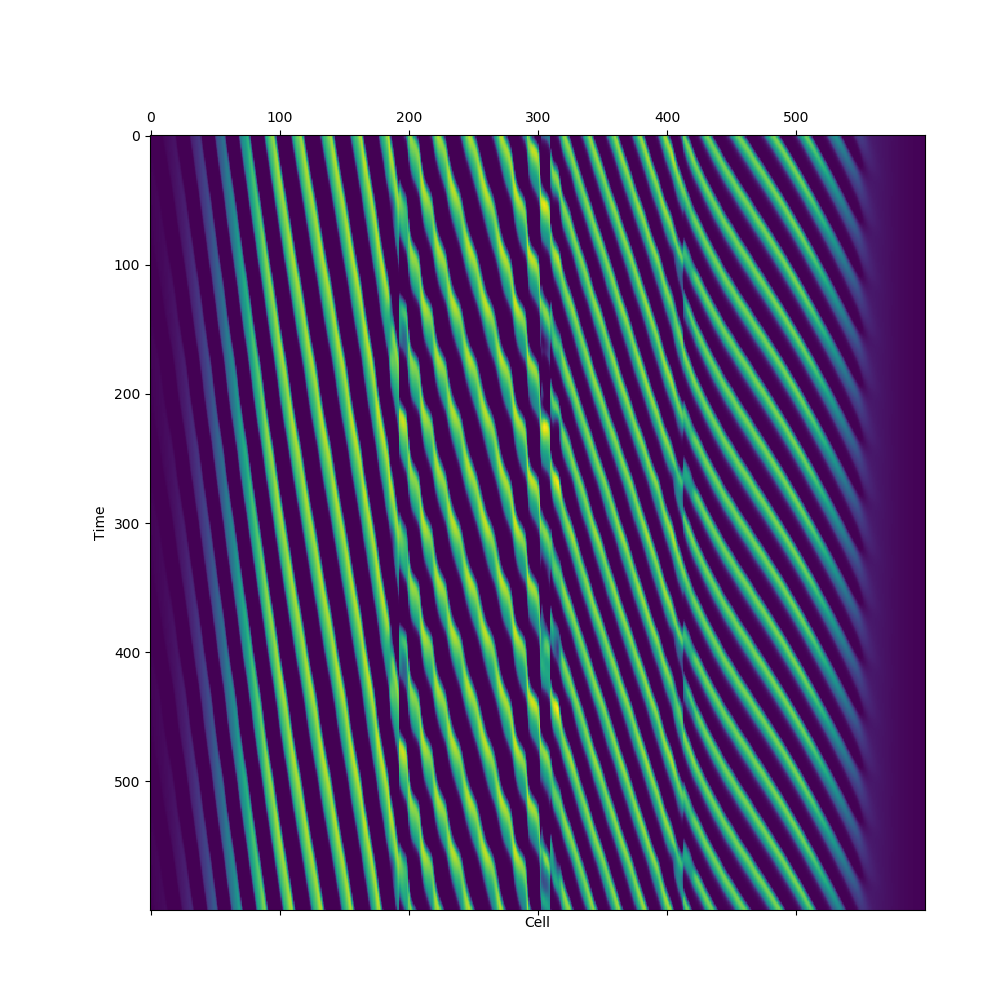

In [1758]:
plt.rcParams['figure.figsize'] = [5, 10]
plt.matshow(results[-600:, :])
plt.xlabel("Cell")
plt.ylabel("Time")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


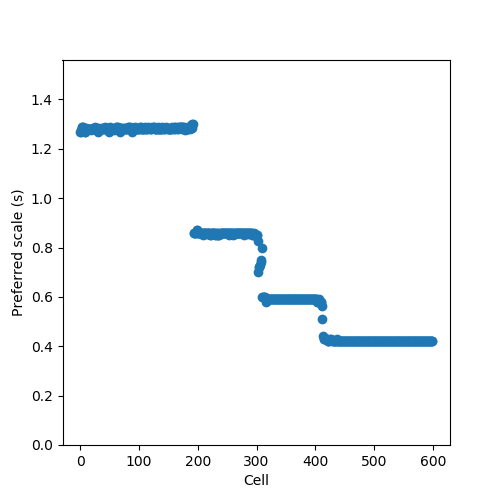

In [1759]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(results[100:, :]/np.mean(results[100:, :], axis=0, keepdims=True))/100.
fig = plt.figure()
ax = plt.gca()
ax.scatter(np.arange(activityScales.shape[0]), (activityScales))
mod = 0.25
plt.xlabel("Cell")
plt.ylabel("Preferred scale (s)")
plt.ylim((0, 1.2*max(activityScales)))
plt.show()

In [1516]:
for i in range(10):
    print(i)
    inhibGCN2.staticLearning(200,
                            logFreq=100000,
                            startFrom = 100.,
                            symmetrize=False)

0
1
2
3
4
5
6
7
8
9


In [1755]:
plt.rcParams['figure.figsize'] = [5, 5]
results, histResults, instResults = inhibGCN2.simulate(20,
                                                      logFreq=int(0.01/inhibGCN2.dt),
                                                      startFrom = 0.,
                                                      boosting=True)


At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 8.47
At 8.48
At 8.49
At 8.5
At 8.51
At 8.52
At 8.53
At 8.540000000000001
At 8.55
At 8.56
At 8.57
At 8.58
At 8.59
At 8.6
At 8.61
At 8.620000000000001
At 8.63
At 8.64
At 8.65
At 8.66
At 8.67
At 8.68
At 8.69
At 8.700000000000001
At 8.71
At 8.72
At 8.73
At 8.74
At 8.75
At 8.76
At 8.77
At 8.78
At 8.790000000000001
At 8.8
At 8.81
At 8.82
At 8.83
At 8.84
At 8.85
At 8.86
At 8.870000000000001
At 8.88
At 8.89
At 8.9
At 8.91
At 8.92
At 8.93
At 8.94
At 8.950000000000001
At 8.96
At 8.97
At 8.98
At 8.99
At 9.0
At 9.01
At 9.02
At 9.03
At 9.040000000000001
At 9.05
At 9.06
At 9.07
At 9.08
At 9.09
At 9.1
At 9.11
At 9.120000000000001
At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9.49
At 9.5
At 9.51
At 9.52
At 9.

At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At 17.26
At 17.27
At 17.28
At 17.29
At 17.3
At 17.31
At 17.32
At 17.330000000000002
At 17.34
At 17.35
At 17.36
At 17.37
At 17.38
At 17.39
At 17.400000000000002
At 17.41
At 17.42
At 17.43
At 17.44
At 17.45
At 17.46
At 17.47
At 17.48
At 17.490000000000002
At 17.5
At 17.51
At 17.52
At 17.53
At 17.54
At 17.55
At 17.56
At 17.57
At 17.580000000000002
At 17.59
At 17.6
At 17.61
At 17.62
At 17.63
At 17.64
At 17.650000000000002
At 17.66
At 17.67
At 17.68
At 17.69
At 17.7
At 17.71
At 17.72
At 17.73
At 17.740000000000002
At 17.75
At 17.76
At 17.77
At 17.78
At 17.79
At 17.8
At 17.81
At 17.82
At 17.830000000000002
At 17.84
At 17.85
At 17.86
At 17.87
At 17.88
At 17.89
At 17.900000000000002
At 17.91
At 17.92
At 17.93
At 17.94
At 17.95
At 17.96
At 17.97
At 17.98
At 17.990000000000002
At 18.0
At 18.01
At 18.02
At 18.03
At 18.04
At 18.05
At 18.06
At 18.07
At 18.080000000000002
At 18

<IPython.core.display.Javascript object>


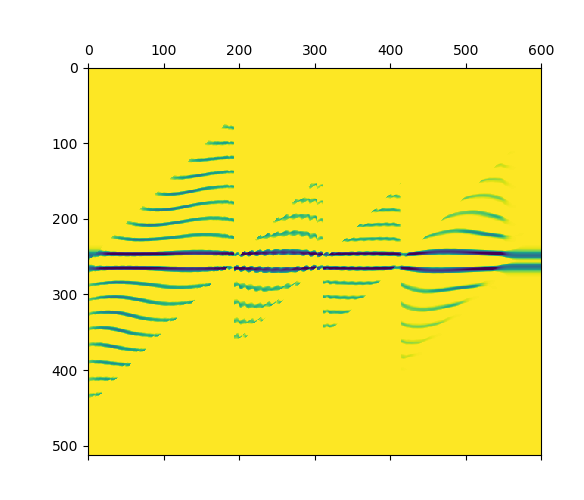

<IPython.core.display.Javascript object>


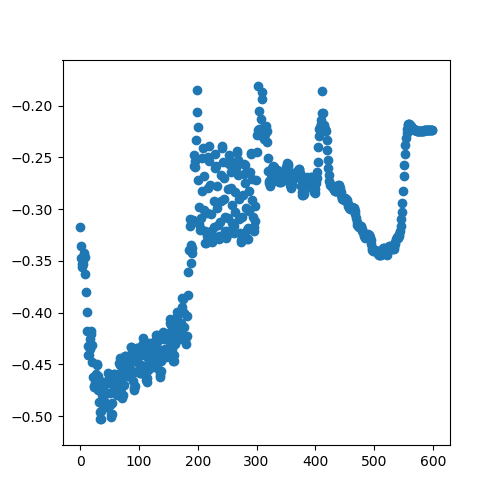

<IPython.core.display.Javascript object>


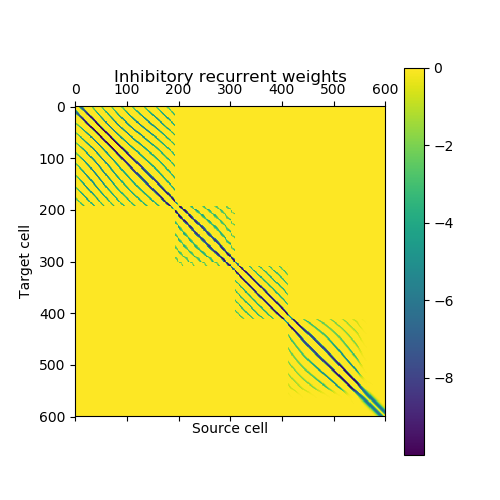

<IPython.core.display.Javascript object>


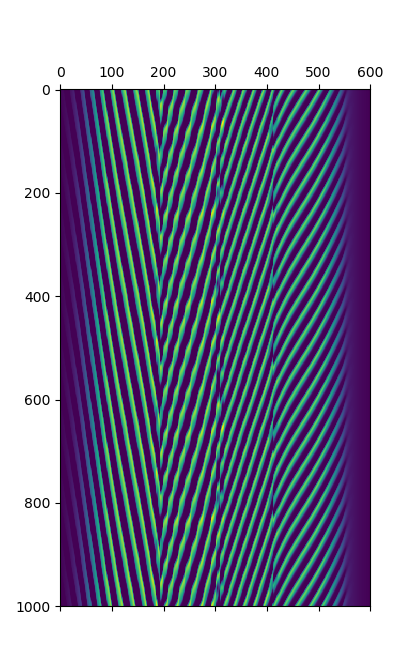

In [1518]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(inhibGCN2.inhibitoryWeights[0,:])
plt.show()

plt.figure()
plt.scatter(np.arange(inhibGCN2.numX),
            torch.mean(inhibGCN2.inhibitoryWeights[0, :], dim=0))
plt.show()

weights = np.zeros((inhibGCN2.numX, inhibGCN2.numX))
stride = inhibGCN2.inhibitoryWeights.shape[-2]//2
for i in range(inhibGCN2.inhibitoryWeights.shape[-1]):
    lowerBound = max(i-stride, 0)
    upperBound = min(i + stride + 1, inhibGCN2.numX)
    weightUpperBound = min(stride - i  + inhibGCN2.numX, 2*stride+1)
    weightLowerBound = max(stride - i, 0)
    weights[lowerBound:upperBound, i] = inhibGCN2.inhibitoryWeights[0, weightLowerBound:weightUpperBound, i]

plt.matshow(weights)
plt.colorbar()
plt.title("Inhibitory recurrent weights")
plt.xlabel("Source cell")
plt.ylabel("Target cell")
plt.tight_layout()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(results[-1000:, :])
plt.show()

<IPython.core.display.Javascript object>


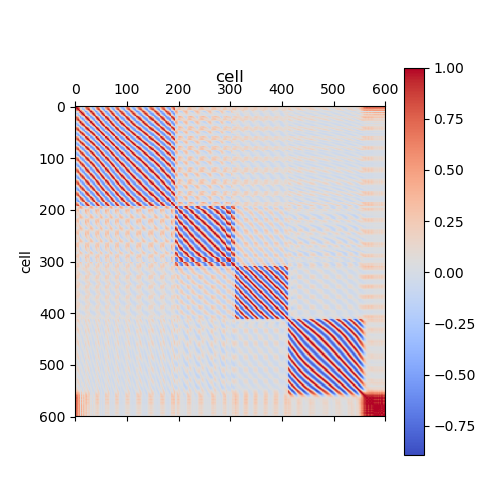

In [1761]:
corrs = np.corrcoef(results[:], rowvar=False)
plt.matshow(corrs, cmap="coolwarm")
plt.colorbar()
plt.ylabel("cell")
plt.title("cell")
# plt.title("Cell-cell correlation")
plt.tight_layout()

1.500833796553641
1.4527716994894238
1.3941862682220798
-42.29545454545455


<IPython.core.display.Javascript object>


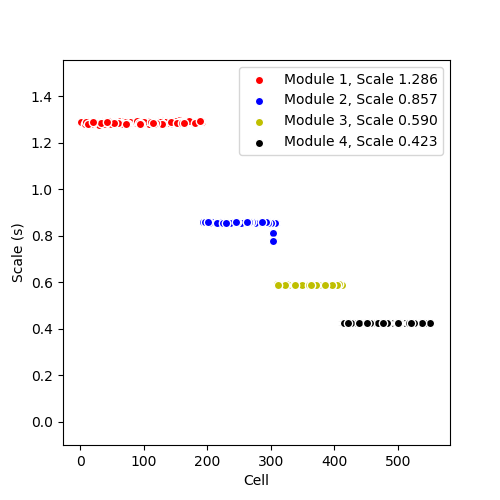

0 1 1.2857142857142858
1 2 0.8566666666666667
2 4 0.5896774193548387
3 0 0.42295454545454547
4 3 -0.01


In [1839]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(np.asarray(results[100:, :])/np.mean(np.asarray(results[100:, :]), axis=0, keepdims=True))/100.
clusters, scales = calculateModuleScales(activityScales, 5)
sortedScales = sorted(scales, reverse=True)
for i in range(len(sortedScales) - 1):
    print(sortedScales[i]/sortedScales[i+1])
fig = plt.figure()
ax = plt.gca()
scales = np.asarray(scales)
moduleNumbers = np.argsort(-scales)
for i, moduleNumber in enumerate(moduleNumbers):
    scale = scales[moduleNumber]
    print(i, moduleNumber, scale)
    if scale <= 0:
        continue
    indices = np.where(clusters == moduleNumber)[0]
    perm = np.random.permutation(len(indices)).astype("int")
    ax.scatter(indices[perm],
               activityScales[indices[perm]],
               c=colors[i],
               label="Module {}, Scale {:4.3f}".format(i + 1, scale),
               edgecolor="white")
plt.xlabel("Cell")
plt.ylabel("Scale (s)")
plt.ylim((-.1, 1.2*max(activityScales)))
plt.legend()


In [1544]:
inhibGCN2.placeWeightDecay = 30
inhibGCN2.learnFactorP = 5000
inhibGCN2.placeWeights.fill_(0.)

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]], device='cuda:0')

In [1545]:
(results,
instResults,
histResults,
placeResults) = inhibGCN2.learn(1,
                                plotting=False,
                                logFreq=(0.01/inhibGCN2.dt),
                                speed=1.,
                                preSimulateTime=5,
                                learnInhibitory=False,
                                learnExcitatory=False,
                                simulateTonicBoost=1.)

Starting run 0


<IPython.core.display.Javascript object>


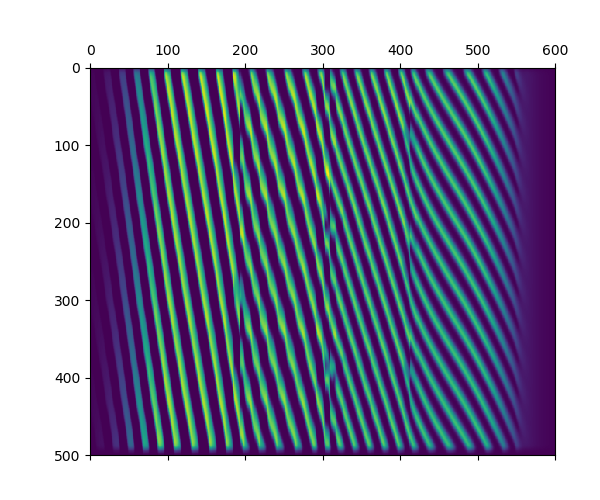

In [1546]:
plt.matshow(torch.transpose(inhibGCN2.placeWeights, 0, 1))

<IPython.core.display.Javascript object>


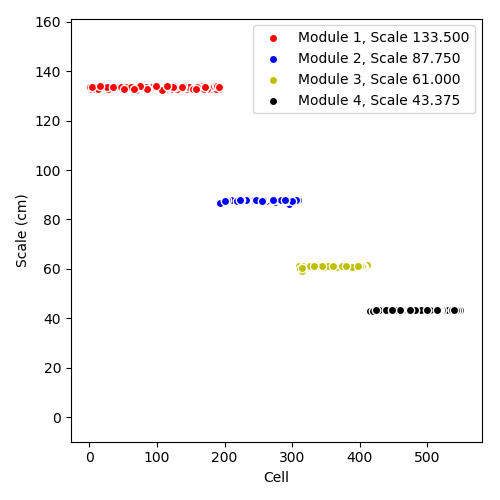

0 0 133.5
1 2 87.75
2 4 61.0
3 1 43.375
4 3 -1.0


In [1838]:
plt.rcParams['figure.figsize'] = [5, 5]
mat = torch.transpose(inhibGCN2.placeWeights, 0, 1).cpu().numpy()
activityScales = compute_scales(mat[50:-50, :]/np.mean(mat[50:-50, :], axis=0, keepdims=True))
fig = plt.figure()
ax = plt.gca()
clusters, scales = calculateModuleScales(activityScales, 5)
scales = np.asarray(scales)
moduleNumbers = np.argsort(-scales)
for i, moduleNumber in enumerate(moduleNumbers):
    scale = scales[moduleNumber]
    print(i, moduleNumber, scale)
    if scale <= 0:
        continue
    indices = np.where(clusters == moduleNumber)[0]
    perm = np.random.permutation(len(indices)).astype("int")
    ax.scatter(indices[perm],
               activityScales[indices[perm]],
               c=colors[i],
               label="Module {}, Scale {:4.3f}".format(i + 1, scale),
               edgecolor="white")
plt.xlabel("Cell")
plt.ylabel("Scale (cm)")
plt.ylim((-10, 1.2*max(activityScales)))
plt.legend()

plt.tight_layout()
plt.show()

In [1793]:
moduleNumbers

array([1, 3, 0, 2], dtype=int64)

<IPython.core.display.Javascript object>


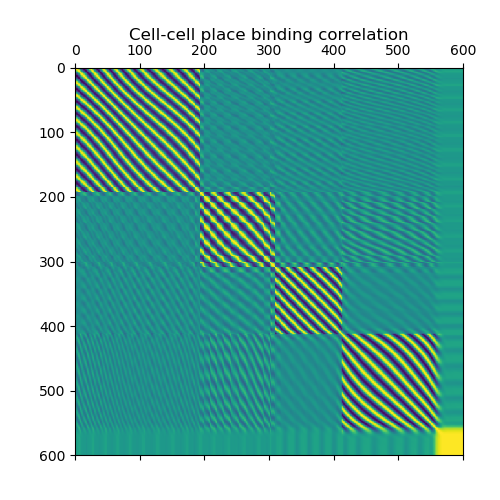

Text(0.5,1.05,'Cell-cell place binding correlation')

In [1550]:
corrs = np.corrcoef(inhibGCN2.placeWeights, rowvar=True)
plt.matshow(corrs)
plt.title("Cell-cell place binding correlation")

In [1866]:
import pickle as pkl
with open(os.getcwd() + "\\perfectmodel.pkl", "wb") as f:
    pkl.dump(inhibGCN2, f)

In [1711]:
inhibGCN2.excitatoryWeightDecay = 4000
inhibGCN2.learnFactorE = 10.

In [1653]:
inhibGCN2.negativeLearnFactorE

1.5

In [1602]:
inhibGCN2.excitatoryWeights["s"].fill_(0.)
inhibGCN2.excitatoryWeights["n"].fill_(0.)
# inhibGCN.excitationMask = inhibGCN2.excitationMask
# inhibGCN.excitatoryKernel = inhibGCN2.excitatoryKernel

tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]], device='cuda:0')

In [1864]:
(results,
histResults,
instResults,
placeResults) = inhibGCN2.learn(40,
                                preSimulateTime=5.,
                                plotting=False,
                                logFreq=(0.01/inhibGCN2.dt),
                                speed=1.,
                                learnInhibitory=False,
                                learnExcitatory=True,
                                learnPlace=False,
                                useExcitatory=False,
                                boosting=True,
                                learnStart=1.)

Starting run 0
Starting run 1
Starting run 2


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


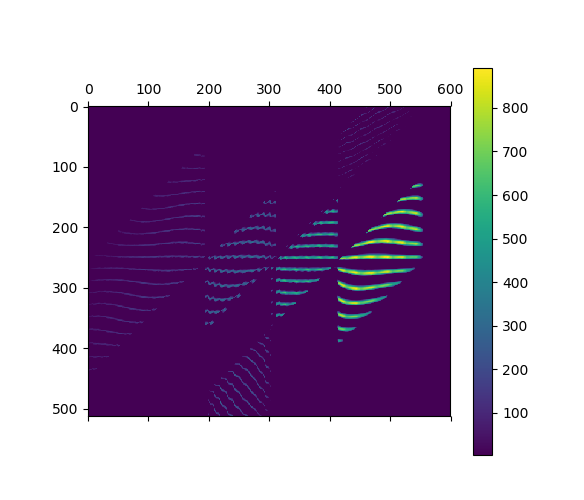

In [1856]:
plt.matshow(torch.exp(torch.exp(inhibGCN2.excitatoryWeights["s"][0])))
plt.colorbar()

<IPython.core.display.Javascript object>


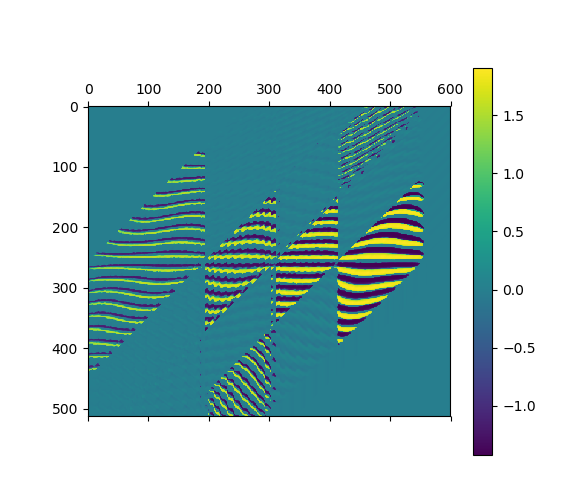

<IPython.core.display.Javascript object>


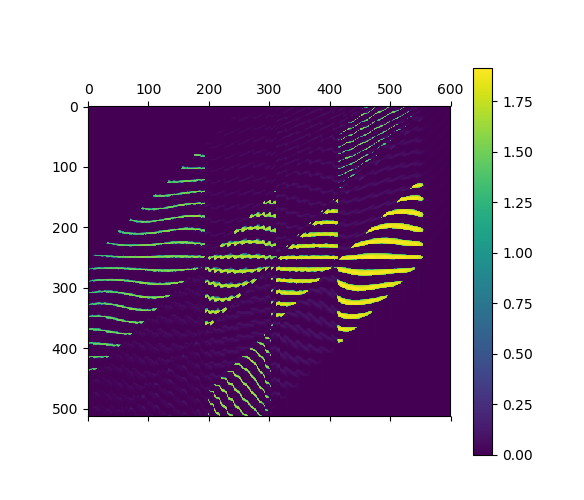

<IPython.core.display.Javascript object>


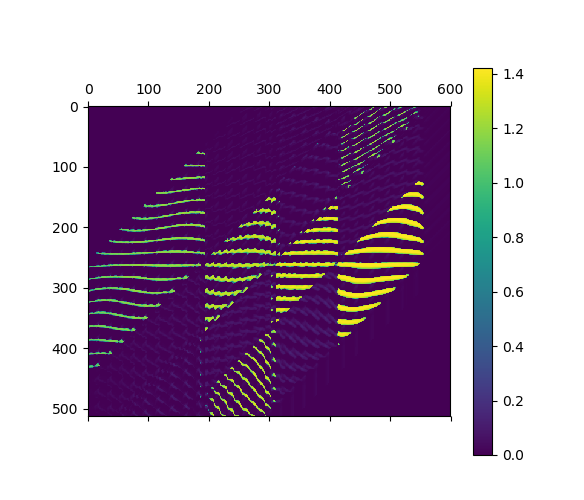

<IPython.core.display.Javascript object>


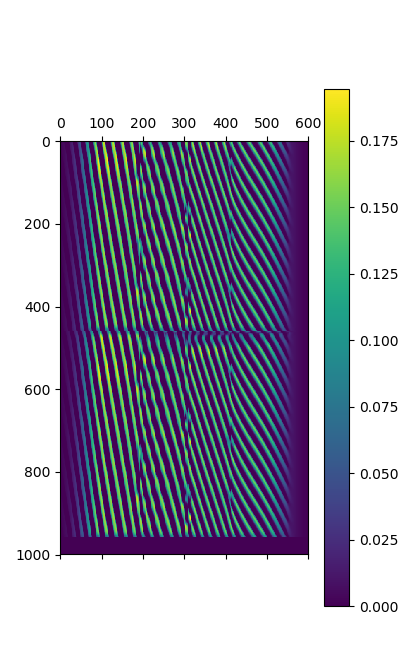

In [1857]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(inhibGCN2.excitatoryWeights["s"][0] - inhibGCN2.excitatoryWeights["n"][0])
plt.colorbar()
plt.matshow(inhibGCN2.excitatoryWeights["s"][0])
plt.colorbar()
plt.matshow(inhibGCN2.excitatoryWeights["n"][0])
plt.colorbar()
plt.matshow(results[-1000:])
plt.colorbar()

In [1858]:
plt.rcParams['figure.figsize'] = [5, 5]
simresults, simhistResults, siminstResults = inhibGCN2.simulate(100,
                                                      logFreq=int(0.01/inhibGCN2.dt),
                                                      startFrom = 0.,
                                                      vel=1.,
                                                      boosting=False)

At 0.0
At 0.01
At 0.02
At 0.03
At 0.04
At 0.05
At 0.06
At 0.07
At 0.08
At 0.09
At 0.1
At 0.11
At 0.12
At 0.13
At 0.14
At 0.15
At 0.16
At 0.17
At 0.18
At 0.19
At 0.2
At 0.21
At 0.22
At 0.23
At 0.24
At 0.25
At 0.26
At 0.27
At 0.28
At 0.29
At 0.3
At 0.31
At 0.32
At 0.33
At 0.34
At 0.35000000000000003
At 0.36
At 0.37
At 0.38
At 0.39
At 0.4
At 0.41000000000000003
At 0.42
At 0.43
At 0.44
At 0.45
At 0.46
At 0.47000000000000003
At 0.48
At 0.49
At 0.5
At 0.51
At 0.52
At 0.53
At 0.54
At 0.55
At 0.56
At 0.5700000000000001
At 0.58
At 0.59
At 0.6
At 0.61
At 0.62
At 0.63
At 0.64
At 0.65
At 0.66
At 0.67
At 0.68
At 0.6900000000000001
At 0.7000000000000001
At 0.71
At 0.72
At 0.73
At 0.74
At 0.75
At 0.76
At 0.77
At 0.78
At 0.79
At 0.8
At 0.81
At 0.8200000000000001
At 0.8300000000000001
At 0.84
At 0.85
At 0.86
At 0.87
At 0.88
At 0.89
At 0.9
At 0.91
At 0.92
At 0.93
At 0.9400000000000001
At 0.9500000000000001
At 0.96
At 0.97
At 0.98
At 0.99
At 1.0
At 1.01
At 1.02
At 1.03
At 1.04
At 1.05
At 1.06
At 1.07
At 

At 8.700000000000001
At 8.71
At 8.72
At 8.73
At 8.74
At 8.75
At 8.76
At 8.77
At 8.78
At 8.790000000000001
At 8.8
At 8.81
At 8.82
At 8.83
At 8.84
At 8.85
At 8.86
At 8.870000000000001
At 8.88
At 8.89
At 8.9
At 8.91
At 8.92
At 8.93
At 8.94
At 8.950000000000001
At 8.96
At 8.97
At 8.98
At 8.99
At 9.0
At 9.01
At 9.02
At 9.03
At 9.040000000000001
At 9.05
At 9.06
At 9.07
At 9.08
At 9.09
At 9.1
At 9.11
At 9.120000000000001
At 9.13
At 9.14
At 9.15
At 9.16
At 9.17
At 9.18
At 9.19
At 9.200000000000001
At 9.21
At 9.22
At 9.23
At 9.24
At 9.25
At 9.26
At 9.27
At 9.28
At 9.290000000000001
At 9.3
At 9.31
At 9.32
At 9.33
At 9.34
At 9.35
At 9.36
At 9.370000000000001
At 9.38
At 9.39
At 9.4
At 9.41
At 9.42
At 9.43
At 9.44
At 9.450000000000001
At 9.46
At 9.47
At 9.48
At 9.49
At 9.5
At 9.51
At 9.52
At 9.53
At 9.540000000000001
At 9.55
At 9.56
At 9.57
At 9.58
At 9.59
At 9.6
At 9.61
At 9.620000000000001
At 9.63
At 9.64
At 9.65
At 9.66
At 9.67
At 9.68
At 9.69
At 9.700000000000001
At 9.71
At 9.72
At 9.73
At 9.74

At 16.88
At 16.89
At 16.9
At 16.91
At 16.92
At 16.93
At 16.94
At 16.95
At 16.96
At 16.97
At 16.98
At 16.990000000000002
At 17.0
At 17.01
At 17.02
At 17.03
At 17.04
At 17.05
At 17.06
At 17.07
At 17.080000000000002
At 17.09
At 17.1
At 17.11
At 17.12
At 17.13
At 17.14
At 17.150000000000002
At 17.16
At 17.17
At 17.18
At 17.19
At 17.2
At 17.21
At 17.22
At 17.23
At 17.240000000000002
At 17.25
At 17.26
At 17.27
At 17.28
At 17.29
At 17.3
At 17.31
At 17.32
At 17.330000000000002
At 17.34
At 17.35
At 17.36
At 17.37
At 17.38
At 17.39
At 17.400000000000002
At 17.41
At 17.42
At 17.43
At 17.44
At 17.45
At 17.46
At 17.47
At 17.48
At 17.490000000000002
At 17.5
At 17.51
At 17.52
At 17.53
At 17.54
At 17.55
At 17.56
At 17.57
At 17.580000000000002
At 17.59
At 17.6
At 17.61
At 17.62
At 17.63
At 17.64
At 17.650000000000002
At 17.66
At 17.67
At 17.68
At 17.69
At 17.7
At 17.71
At 17.72
At 17.73
At 17.740000000000002
At 17.75
At 17.76
At 17.77
At 17.78
At 17.79
At 17.8
At 17.81
At 17.82
At 17.830000000000002
At

At 25.080000000000002
At 25.09
At 25.1
At 25.11
At 25.12
At 25.13
At 25.14
At 25.150000000000002
At 25.16
At 25.17
At 25.18
At 25.19
At 25.2
At 25.21
At 25.22
At 25.23
At 25.240000000000002
At 25.25
At 25.26
At 25.27
At 25.28
At 25.29
At 25.3
At 25.310000000000002
At 25.32
At 25.330000000000002
At 25.34
At 25.35
At 25.36
At 25.37
At 25.38
At 25.39
At 25.400000000000002
At 25.41
At 25.42
At 25.43
At 25.44
At 25.45
At 25.46
At 25.47
At 25.48
At 25.490000000000002
At 25.5
At 25.51
At 25.52
At 25.53
At 25.54
At 25.55
At 25.560000000000002
At 25.57
At 25.580000000000002
At 25.59
At 25.6
At 25.61
At 25.62
At 25.63
At 25.64
At 25.650000000000002
At 25.66
At 25.67
At 25.68
At 25.69
At 25.7
At 25.71
At 25.72
At 25.73
At 25.740000000000002
At 25.75
At 25.76
At 25.77
At 25.78
At 25.79
At 25.8
At 25.810000000000002
At 25.82
At 25.830000000000002
At 25.84
At 25.85
At 25.86
At 25.87
At 25.88
At 25.89
At 25.900000000000002
At 25.91
At 25.92
At 25.93
At 25.94
At 25.95
At 25.96
At 25.97
At 25.98
At 25.

At 32.52
At 32.53
At 32.54
At 32.55
At 32.56
At 32.57
At 32.58
At 32.59
At 32.6
At 32.61
At 32.62
At 32.63
At 32.64
At 32.65
At 32.660000000000004
At 32.67
At 32.68
At 32.69
At 32.7
At 32.71
At 32.72
At 32.730000000000004
At 32.74
At 32.75
At 32.76
At 32.77
At 32.78
At 32.79
At 32.8
At 32.81
At 32.82
At 32.83
At 32.84
At 32.85
At 32.86
At 32.87
At 32.88
At 32.89
At 32.9
At 32.910000000000004
At 32.92
At 32.93
At 32.94
At 32.95
At 32.96
At 32.97
At 32.980000000000004
At 32.99
At 33.0
At 33.01
At 33.02
At 33.03
At 33.04
At 33.05
At 33.06
At 33.07
At 33.08
At 33.09
At 33.1
At 33.11
At 33.12
At 33.13
At 33.14
At 33.15
At 33.160000000000004
At 33.17
At 33.18
At 33.19
At 33.2
At 33.21
At 33.22
At 33.230000000000004
At 33.24
At 33.25
At 33.26
At 33.27
At 33.28
At 33.29
At 33.3
At 33.31
At 33.32
At 33.33
At 33.34
At 33.35
At 33.36
At 33.37
At 33.38
At 33.39
At 33.4
At 33.410000000000004
At 33.42
At 33.43
At 33.44
At 33.45
At 33.46
At 33.47
At 33.480000000000004
At 33.49
At 33.5
At 33.51
At 33.

At 41.050000000000004
At 41.06
At 41.07
At 41.08
At 41.09
At 41.1
At 41.11
At 41.12
At 41.13
At 41.14
At 41.15
At 41.160000000000004
At 41.17
At 41.18
At 41.19
At 41.2
At 41.21
At 41.22
At 41.230000000000004
At 41.24
At 41.25
At 41.26
At 41.27
At 41.28
At 41.29
At 41.300000000000004
At 41.31
At 41.32
At 41.33
At 41.34
At 41.35
At 41.36
At 41.37
At 41.38
At 41.39
At 41.4
At 41.410000000000004
At 41.42
At 41.43
At 41.44
At 41.45
At 41.46
At 41.47
At 41.480000000000004
At 41.49
At 41.5
At 41.51
At 41.52
At 41.53
At 41.54
At 41.550000000000004
At 41.56
At 41.57
At 41.58
At 41.59
At 41.6
At 41.61
At 41.62
At 41.63
At 41.64
At 41.65
At 41.660000000000004
At 41.67
At 41.68
At 41.69
At 41.7
At 41.71
At 41.72
At 41.730000000000004
At 41.74
At 41.75
At 41.76
At 41.77
At 41.78
At 41.79
At 41.800000000000004
At 41.81
At 41.82
At 41.83
At 41.84
At 41.85
At 41.86
At 41.87
At 41.88
At 41.89
At 41.9
At 41.910000000000004
At 41.92
At 41.93
At 41.94
At 41.95
At 41.96
At 41.97
At 41.980000000000004
At 41

At 49.17
At 49.18
At 49.19
At 49.2
At 49.21
At 49.22
At 49.230000000000004
At 49.24
At 49.25
At 49.26
At 49.27
At 49.28
At 49.29
At 49.300000000000004
At 49.31
At 49.32
At 49.33
At 49.34
At 49.35
At 49.36
At 49.370000000000005
At 49.38
At 49.39
At 49.4
At 49.410000000000004
At 49.42
At 49.43
At 49.44
At 49.45
At 49.46
At 49.47
At 49.480000000000004
At 49.49
At 49.5
At 49.51
At 49.52
At 49.53
At 49.54
At 49.550000000000004
At 49.56
At 49.57
At 49.58
At 49.59
At 49.6
At 49.61
At 49.620000000000005
At 49.63
At 49.64
At 49.65
At 49.660000000000004
At 49.67
At 49.68
At 49.69
At 49.7
At 49.71
At 49.72
At 49.730000000000004
At 49.74
At 49.75
At 49.76
At 49.77
At 49.78
At 49.79
At 49.800000000000004
At 49.81
At 49.82
At 49.83
At 49.84
At 49.85
At 49.86
At 49.870000000000005
At 49.88
At 49.89
At 49.9
At 49.910000000000004
At 49.92
At 49.93
At 49.94
At 49.95
At 49.96
At 49.97
At 49.980000000000004
At 49.99
At 50.0
At 50.01
At 50.02
At 50.03
At 50.04
At 50.050000000000004
At 50.06
At 50.07
At 50.

At 56.7
At 56.71
At 56.72
At 56.730000000000004
At 56.74
At 56.75
At 56.76
At 56.77
At 56.78
At 56.79
At 56.800000000000004
At 56.81
At 56.82
At 56.83
At 56.84
At 56.85
At 56.86
At 56.870000000000005
At 56.88
At 56.89
At 56.9
At 56.910000000000004
At 56.92
At 56.93
At 56.94
At 56.95
At 56.96
At 56.97
At 56.980000000000004
At 56.99
At 57.0
At 57.01
At 57.02
At 57.03
At 57.04
At 57.050000000000004
At 57.06
At 57.07
At 57.08
At 57.09
At 57.1
At 57.11
At 57.120000000000005
At 57.13
At 57.14
At 57.15
At 57.160000000000004
At 57.17
At 57.18
At 57.19
At 57.2
At 57.21
At 57.22
At 57.230000000000004
At 57.24
At 57.25
At 57.26
At 57.27
At 57.28
At 57.29
At 57.300000000000004
At 57.31
At 57.32
At 57.33
At 57.34
At 57.35
At 57.36
At 57.370000000000005
At 57.38
At 57.39
At 57.4
At 57.410000000000004
At 57.42
At 57.43
At 57.44
At 57.45
At 57.46
At 57.47
At 57.480000000000004
At 57.49
At 57.5
At 57.51
At 57.52
At 57.53
At 57.54
At 57.550000000000004
At 57.56
At 57.57
At 57.58
At 57.59
At 57.6
At 57.6

At 64.58
At 64.59
At 64.6
At 64.61
At 64.62
At 64.63
At 64.64
At 64.65
At 64.66
At 64.67
At 64.68
At 64.69
At 64.7
At 64.71000000000001
At 64.72
At 64.73
At 64.74
At 64.75
At 64.76
At 64.77
At 64.78
At 64.79
At 64.8
At 64.81
At 64.82000000000001
At 64.83
At 64.84
At 64.85
At 64.86
At 64.87
At 64.88
At 64.89
At 64.9
At 64.91
At 64.92
At 64.93
At 64.94
At 64.95
At 64.96000000000001
At 64.97
At 64.98
At 64.99
At 65.0
At 65.01
At 65.02
At 65.03
At 65.04
At 65.05
At 65.06
At 65.07000000000001
At 65.08
At 65.09
At 65.1
At 65.11
At 65.12
At 65.13
At 65.14
At 65.15
At 65.16
At 65.17
At 65.18
At 65.19
At 65.2
At 65.21000000000001
At 65.22
At 65.23
At 65.24
At 65.25
At 65.26
At 65.27
At 65.28
At 65.29
At 65.3
At 65.31
At 65.32000000000001
At 65.33
At 65.34
At 65.35
At 65.36
At 65.37
At 65.38
At 65.39
At 65.4
At 65.41
At 65.42
At 65.43
At 65.44
At 65.45
At 65.46000000000001
At 65.47
At 65.48
At 65.49
At 65.5
At 65.51
At 65.52
At 65.53
At 65.54
At 65.55
At 65.56
At 65.57000000000001
At 65.58
At 65

At 73.07000000000001
At 73.08
At 73.09
At 73.10000000000001
At 73.11
At 73.12
At 73.13
At 73.14
At 73.15
At 73.16
At 73.17
At 73.18
At 73.19
At 73.2
At 73.21000000000001
At 73.22
At 73.23
At 73.24
At 73.25
At 73.26
At 73.27
At 73.28
At 73.29
At 73.3
At 73.31
At 73.32000000000001
At 73.33
At 73.34
At 73.35000000000001
At 73.36
At 73.37
At 73.38
At 73.39
At 73.4
At 73.41
At 73.42
At 73.43
At 73.44
At 73.45
At 73.46000000000001
At 73.47
At 73.48
At 73.49
At 73.5
At 73.51
At 73.52
At 73.53
At 73.54
At 73.55
At 73.56
At 73.57000000000001
At 73.58
At 73.59
At 73.60000000000001
At 73.61
At 73.62
At 73.63
At 73.64
At 73.65
At 73.66
At 73.67
At 73.68
At 73.69
At 73.7
At 73.71000000000001
At 73.72
At 73.73
At 73.74
At 73.75
At 73.76
At 73.77
At 73.78
At 73.79
At 73.8
At 73.81
At 73.82000000000001
At 73.83
At 73.84
At 73.85000000000001
At 73.86
At 73.87
At 73.88
At 73.89
At 73.9
At 73.91
At 73.92
At 73.93
At 73.94
At 73.95
At 73.96000000000001
At 73.97
At 73.98
At 73.99
At 74.0
At 74.01
At 74.02


At 81.23
At 81.24
At 81.25
At 81.26
At 81.27
At 81.28
At 81.29
At 81.3
At 81.31
At 81.32000000000001
At 81.33
At 81.34
At 81.35000000000001
At 81.36
At 81.37
At 81.38
At 81.39
At 81.4
At 81.41
At 81.42
At 81.43
At 81.44
At 81.45
At 81.46000000000001
At 81.47
At 81.48
At 81.49
At 81.5
At 81.51
At 81.52
At 81.53
At 81.54
At 81.55
At 81.56
At 81.57000000000001
At 81.58
At 81.59
At 81.60000000000001
At 81.61
At 81.62
At 81.63
At 81.64
At 81.65
At 81.66
At 81.67
At 81.68
At 81.69
At 81.7
At 81.71000000000001
At 81.72
At 81.73
At 81.74
At 81.75
At 81.76
At 81.77
At 81.78
At 81.79
At 81.8
At 81.81
At 81.82000000000001
At 81.83
At 81.84
At 81.85000000000001
At 81.86
At 81.87
At 81.88
At 81.89
At 81.9
At 81.91
At 81.92
At 81.93
At 81.94
At 81.95
At 81.96000000000001
At 81.97
At 81.98
At 81.99
At 82.0
At 82.01
At 82.02
At 82.03
At 82.04
At 82.05
At 82.06
At 82.07000000000001
At 82.08
At 82.09
At 82.10000000000001
At 82.11
At 82.12
At 82.13
At 82.14
At 82.15
At 82.16
At 82.17
At 82.18
At 82.19
At

At 89.56
At 89.57000000000001
At 89.58
At 89.59
At 89.60000000000001
At 89.61
At 89.62
At 89.63
At 89.64
At 89.65
At 89.66
At 89.67
At 89.68
At 89.69
At 89.7
At 89.71000000000001
At 89.72
At 89.73
At 89.74
At 89.75
At 89.76
At 89.77
At 89.78
At 89.79
At 89.8
At 89.81
At 89.82000000000001
At 89.83
At 89.84
At 89.85000000000001
At 89.86
At 89.87
At 89.88
At 89.89
At 89.9
At 89.91
At 89.92
At 89.93
At 89.94
At 89.95
At 89.96000000000001
At 89.97
At 89.98
At 89.99
At 90.0
At 90.01
At 90.02
At 90.03
At 90.04
At 90.05
At 90.06
At 90.07000000000001
At 90.08
At 90.09
At 90.10000000000001
At 90.11
At 90.12
At 90.13
At 90.14
At 90.15
At 90.16
At 90.17
At 90.18
At 90.19
At 90.2
At 90.21000000000001
At 90.22
At 90.23
At 90.24
At 90.25
At 90.26
At 90.27
At 90.28
At 90.29
At 90.3
At 90.31
At 90.32000000000001
At 90.33
At 90.34
At 90.35000000000001
At 90.36
At 90.37
At 90.38
At 90.39
At 90.4
At 90.41
At 90.42
At 90.43
At 90.44
At 90.45
At 90.46000000000001
At 90.47
At 90.48
At 90.49
At 90.5
At 90.51


At 97.39
At 97.4
At 97.41
At 97.42
At 97.43
At 97.44
At 97.45
At 97.46000000000001
At 97.47
At 97.48
At 97.49000000000001
At 97.5
At 97.51
At 97.52
At 97.53
At 97.54
At 97.55
At 97.56
At 97.57000000000001
At 97.58
At 97.59
At 97.60000000000001
At 97.61
At 97.62
At 97.63
At 97.64
At 97.65
At 97.66
At 97.67
At 97.68
At 97.69
At 97.7
At 97.71000000000001
At 97.72
At 97.73
At 97.74000000000001
At 97.75
At 97.76
At 97.77
At 97.78
At 97.79
At 97.8
At 97.81
At 97.82000000000001
At 97.83
At 97.84
At 97.85000000000001
At 97.86
At 97.87
At 97.88
At 97.89
At 97.9
At 97.91
At 97.92
At 97.93
At 97.94
At 97.95
At 97.96000000000001
At 97.97
At 97.98
At 97.99000000000001
At 98.0
At 98.01
At 98.02
At 98.03
At 98.04
At 98.05
At 98.06
At 98.07000000000001
At 98.08
At 98.09
At 98.10000000000001
At 98.11
At 98.12
At 98.13
At 98.14
At 98.15
At 98.16
At 98.17
At 98.18
At 98.19
At 98.2
At 98.21000000000001
At 98.22
At 98.23
At 98.24000000000001
At 98.25
At 98.26
At 98.27
At 98.28
At 98.29
At 98.3
At 98.31
At 

<IPython.core.display.Javascript object>


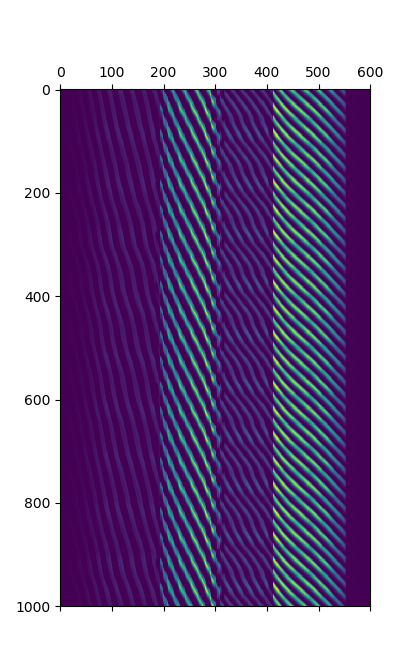

In [1859]:
plt.matshow(simresults[-1000:, :])

1.8560337310607473
1.5001523306590838
1.3332487523468717
-24.37530864197531


<IPython.core.display.Javascript object>


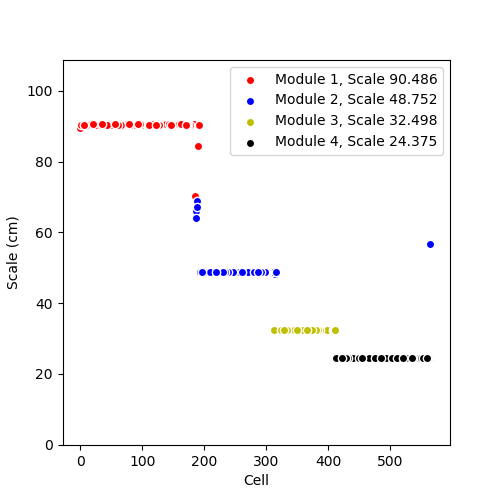

0 1 90.4862385321101
1 0 48.75247524752475
2 4 32.4983498349835
3 2 24.37530864197531
4 3 -1.0


In [1860]:
plt.rcParams['figure.figsize'] = [5, 5]
activityScales = compute_scales(np.asarray(simresults[100:, :])/np.mean(np.asarray(simresults[100:, :]), axis=0, keepdims=True))
activityScales[activityScales > 800] = 0
clusters, scales = calculateModuleScales(activityScales, 5)
sortedScales = sorted(scales, reverse=True)
for i in range(len(sortedScales) - 1):
    print(sortedScales[i]/sortedScales[i+1])
fig = plt.figure()
ax = plt.gca()
scales = np.asarray(scales)
moduleNumbers = np.argsort(-scales)
for i, moduleNumber in enumerate(moduleNumbers):
    scale = scales[moduleNumber]
    print(i, moduleNumber, scale)
    if scale <= 0:
        continue
    indices = np.where(clusters == moduleNumber)[0]
    perm = np.random.permutation(len(indices)).astype("int")
    ax.scatter(indices[perm],
               activityScales[indices[perm]],
               c=colors[i],
               label="Module {}, Scale {:4.3f}".format(i + 1, scale),
               edgecolor="white")
plt.xlabel("Cell")
plt.ylabel("Scale (cm)")
plt.ylim((-.1, 1.2*max(activityScales)))
plt.legend()

In [1660]:
vels = np.linspace(.1, 1.5, 15)
positiveModuleScales = calculatePathIntegrationSpeeds(vels, inhibGCN2, 3, simLength=20., dt=0.01)
negativeModuleScales = calculatePathIntegrationSpeeds(-vels, inhibGCN2, 3, simLength=20., dt=0.01)

At 10.0
At 10.01
At 10.02
At 10.03
At 10.040000000000001
At 10.05
At 10.06
At 10.07
At 10.08
At 10.09
At 10.1
At 10.11
At 10.120000000000001
At 10.13
At 10.14
At 10.15
At 10.16
At 10.17
At 10.18
At 10.19
At 10.200000000000001
At 10.21
At 10.22
At 10.23
At 10.24
At 10.25
At 10.26
At 10.27
At 10.28
At 10.290000000000001
At 10.3
At 10.31
At 10.32
At 10.33
At 10.34
At 10.35
At 10.36
At 10.370000000000001
At 10.38
At 10.39
At 10.4
At 10.41
At 10.42
At 10.43
At 10.44
At 10.450000000000001
At 10.46
At 10.47
At 10.48
At 10.49
At 10.5
At 10.51
At 10.52


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


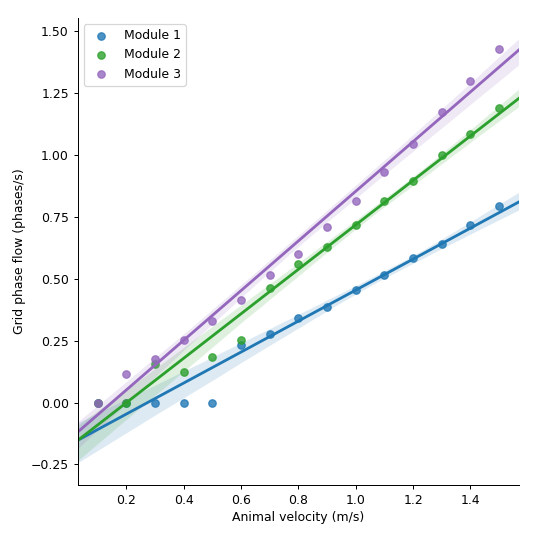

In [1320]:
g = sns.JointGrid(vels, 1/positiveModuleScales[:, 0]*1/inhibGCN2.dt, ratio=100)
for i in range(positiveModuleScales.shape[1]):
    g.y = 1/positiveModuleScales[:, i]*1/inhibGCN2.dt
    g.plot_joint(sns.regplot, label="Module {}".format(i + 1))
    g.annotate(stats.pearsonr)
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()
#     plt.figure()
#     fit = np.polyfit(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 1)
#     fit_fn = np.poly1d(fit) 
#     # fit_fn is now a function which takes in x and returns an estimate for y

#     plt.plot(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 'blue', vels, fit_fn(vels), '--k')

    plt.xlabel("Animal velocity (m/s)")
    plt.ylabel("Grid phase flow (phases/s)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


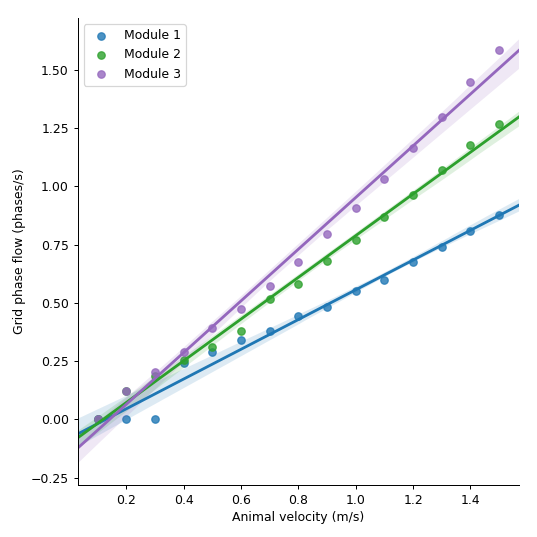

In [1321]:
g = sns.JointGrid(vels[:], 1/positiveModuleScales[:, 0]*1/inhibGCN2.dt, ratio=100)
for i in range(negativeModuleScales.shape[1]):
    g.y = 1/negativeModuleScales[:, i]*1/inhibGCN2.dt
    g.plot_joint(sns.regplot, label="Module {}".format(i + 1))
    g.annotate(stats.pearsonr)
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()
#     plt.figure()
#     fit = np.polyfit(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 1)
#     fit_fn = np.poly1d(fit) 
#     # fit_fn is now a function which takes in x and returns an estimate for y

#     plt.plot(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 'blue', vels, fit_fn(vels), '--k')

    plt.xlabel("Animal velocity (m/s)")
    plt.ylabel("Grid phase flow (phases/s)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


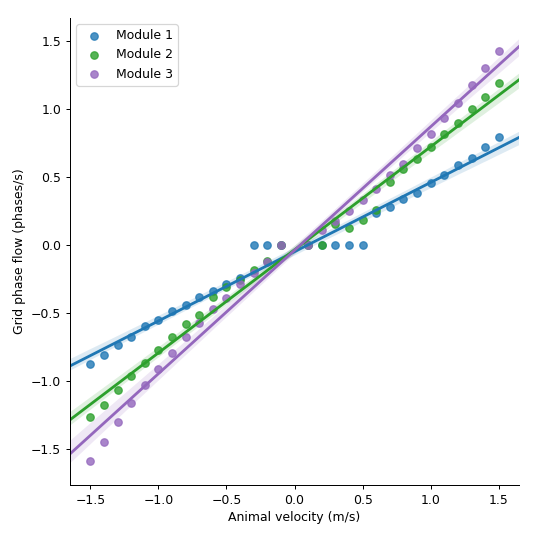

In [1322]:
totalVels = np.concatenate([-vels, vels])
totalModuleScales = np.concatenate([-negativeModuleScales, positiveModuleScales])

g = sns.JointGrid(totalVels[:], 1/totalModuleScales[:, i]*1/inhibGCN2.dt, ratio=100)
for i in range(totalModuleScales.shape[1]):
    g.y = 1/totalModuleScales[:, i]*1/inhibGCN2.dt
    g.plot_joint(sns.regplot, label="Module {}".format(i + 1))
    g.annotate(stats.pearsonr)
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()
#     plt.figure()
#     fit = np.polyfit(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 1)
#     fit_fn = np.poly1d(fit) 
#     # fit_fn is now a function which takes in x and returns an estimate for y

#     plt.plot(vels, 1/positiveModuleScales[:, i]*1/inhibGCN2.dt, 'blue', vels, fit_fn(vels), '--k')

    plt.xlabel("Animal velocity (m/s)")
    plt.ylabel("Grid phase flow (phases/s)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


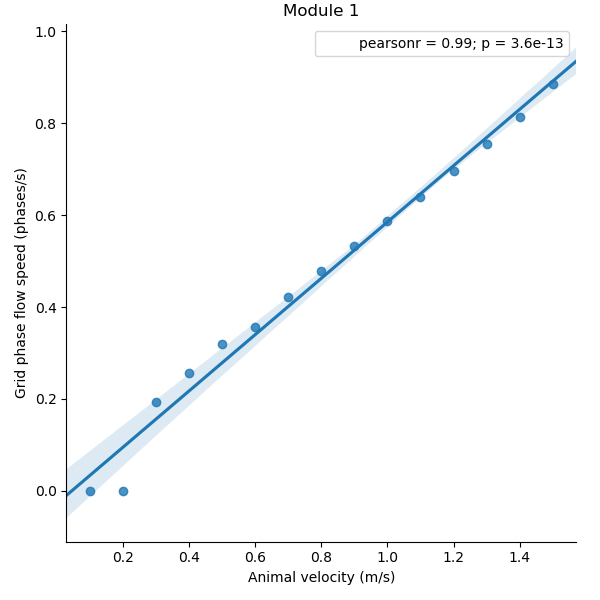

<IPython.core.display.Javascript object>


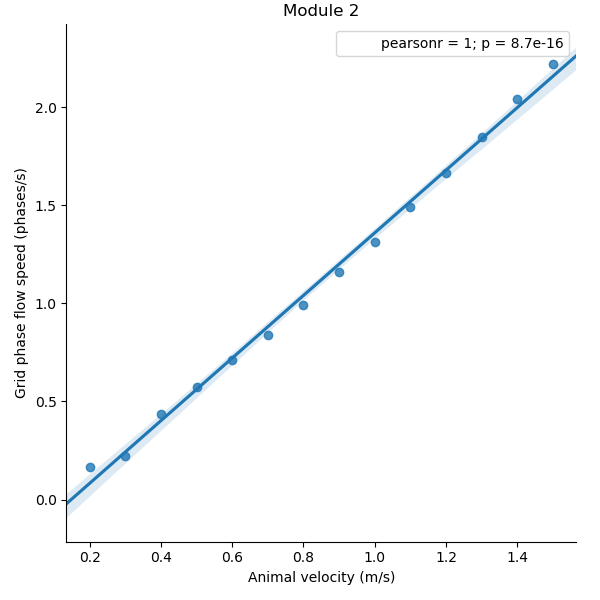

<IPython.core.display.Javascript object>


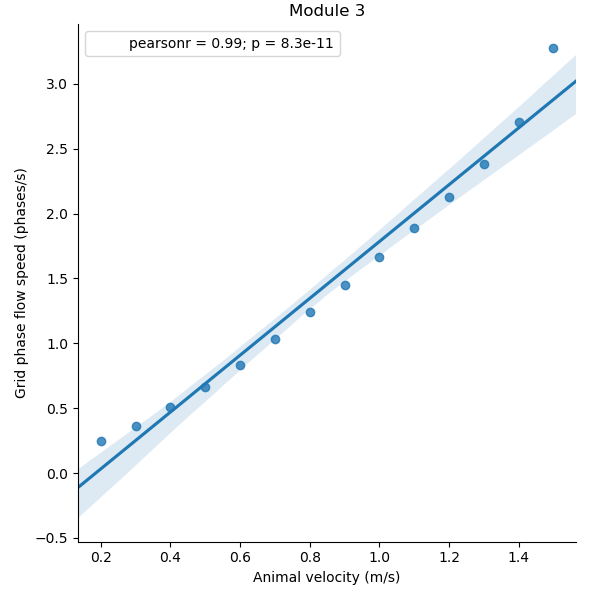

In [1053]:
for i in range(moduleScales.shape[1]):
    g = sns.JointGrid(vels, 1/negativeModuleScales[:, i]*1/inhibGCN2.dt, ratio=100)
    g.plot_joint(sns.regplot)
    g.annotate(stats.pearsonr)
    g.ax_marg_x.set_axis_off()
    g.ax_marg_y.set_axis_off()
    plt.xlabel("Animal velocity (m/s)")
    plt.ylabel("Grid phase flow speed (phases/s)")
    plt.title("Module {}".format(i+ 1))
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


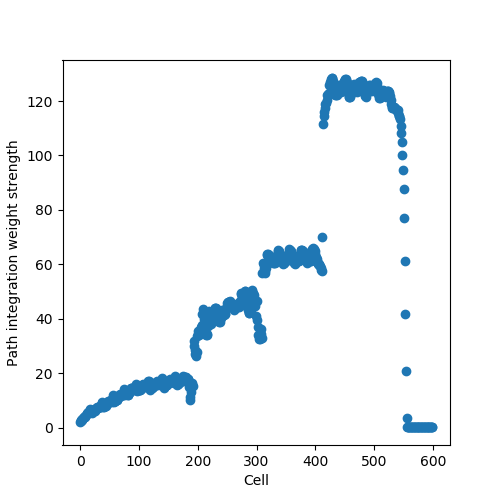

In [1675]:
testEnvelope = torch.sum(inhibGCN2.excitatoryWeights["s"][0] +
                                      inhibGCN2.excitatoryWeights["n"][0],
                                      dim = 0)

plt.figure()
plt.scatter(np.arange(testEnvelope.shape[0]), testEnvelope)
plt.xlabel("Cell")
plt.ylabel("Path integration weight strength")
plt.show()

In [1176]:
weights = np.zeros((inhibGCN2.numX, inhibGCN2.numX))
stride = inhibGCN2.excitatoryWeights["n"].shape[-2]//2
inputWeights = inhibGCN2.excitatoryWeights["n"] - inhibGCN2.excitatoryWeights["s"]
for i in range(inhibGCN2.excitatoryWeights["n"].shape[-1]):
    lowerBound = max(i-stride, 0)
    upperBound = min(i + stride + 1, inhibGCN2.numX)
    weightUpperBound = min(stride - i  + inhibGCN2.numX, 2*stride+1)
    weightLowerBound = max(stride - i, 0)
    weights[i, lowerBound:upperBound] = inputWeights[0, weightLowerBound:weightUpperBound, i]
    
plt.matshow(weights, cmap="coolwarm")
plt.colorbar()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


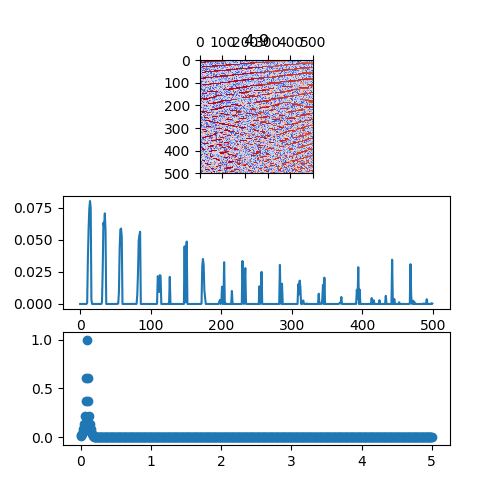

Starting run 0


UnboundLocalError: local variable 'output' referenced before assignment

In [61]:
plt.rcParams['figure.figsize'] = [5, 5]
inhibGCN.learn(1, plotting=True, plotInterval=10, speed=1., preSimulateTime=50.)

In [ ]:
alphas = np.asarray([20,
                    10,
                    15,
                    5,
                    20,
                    20,
                    10,
                    15,
                    40,
                    40,
                    10,
                    5,
                    5,
                    40,
                    15,
                    0.5,
                    5.,
                    2.,
                    1.,
                    1.,
                    ])

boostEffects = np.asarray([100,
                          200,
                          200,
                          200,
                          200,
                          400,
                          100,
                          100,
                          100,
                          400,
                          400,
                          100,
                          400,
                          200,
                          400,
                          50,
                          50.,
                          50.,
                          50.,
                          400.,
                          ])

scales = np.asarray([43.75,
                    37.3,
                    30,
                    60,
                    21.6,
                    14.5,
                    74,
                    55,
                    33.5,
                    9,
                    23,
                    106.5,
                    34.5,
                    15,
                    17.5,
                    700,
                    150.,
                    282.,
                    400.,
                    103.,
                    ])


fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_trisurf(1./(alphas)**.7,
                       1./(boostEffects)**.7,
                       scales,
                       linewidth=0,
                       #cmap=cm.coolwarm,
                       antialiased=True)


ax.set_xlabel("Moving average constant")
ax.set_ylabel("Boost effect")
ax.set_zlabel("Scale")
plt.title("Scale vs. boosting")

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


ax.view_init(15, 210)
plt.savefig("ScaleSurface.png", dpi = 250)
plt.draw()
plt.show()